In [1]:
import awkward as ak
#import uproot
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep
import numpy as np
import pandas as pd
import hist
import os
from pprint import pprint 
from glob import glob

hep.style.use(hep.style.ROOT)

from coffea import processor
from coffea.util import load
from coffea.nanoevents.methods import candidate
from coffea.nanoevents import NanoEventsFactory, BaseSchema
from coffea.processor import column_accumulator

import vector
vector.register_awkward()

In [3]:
output_folder = "/eos/user/d/dvalsecc/www/ECAL/Clustering/DeepCluster/RecoPlots/DataPlots/Zee_Run2018D/"
input_folder_must = "/eos/user/r/rdfexp/ecal/cluster/raw_files/EGamma/Dumper_Mustache_bugFix/220919_211119"
input_folder_deep = "/eos/user/r/rdfexp/ecal/cluster/raw_files/EGamma/Dumper_DeepSC_algoA_bugFix/220919_211359"

fileset = {
    "DeepSC": glob(input_folder_deep+"/*/*.root", recursive=True)[0:20],
    "Mustache": glob(input_folder_must+"/*/*.root", recursive=True)[0:20]
}

In [16]:
patEle_fields = list(map( lambda k: k.strip().replace("patElectron_",""),
                         open("patElectron_fields.txt").readlines()))

In [15]:
patEle_fields

NameError: name 'patEle_fields' is not defined

# Coffea processor

In [ ]:

class ZeeProcessor(processor.ProcessorABC):
    def __init__(self):
        pass

    def process(self, events):
        dataset = events.metadata['dataset']
        vector.register_awkward()
        electrons = ak.zip({k:events["patElectron_" + k] for k in patEle_fields},
                           with_name="Momentum4D")
        
        nele_init = ak.num(electrons, axis=1)
        
        id_mask = (electrons.egmCutBasedElectronIDloose==1)
        # Trying to replicate the skim selection
        #https://cmssdt.cern.ch/lxr/source/DPGAnalysis/Skims/python/ZElectronSkim_cff.py
#         mask_skim = (electrons.pt >= 10) &\
#                     ( ((abs(electrons.eta)<=1.4442) &(\
#                         (electrons.full5x5_refinedSCSigmaIEtaIEta < 0.0128)&\
#                         (electrons.deltaEtaIn < 0.00523)&\
#                         (electrons.deltaPhiIn < 0.159)&\
#                         (electrons.HoE < 0.247)&\
#                         (electrons.misHits<2)\
#                         ))|
#                         ((abs(electrons.eta)>=1.4442)&(abs(electrons.eta)<=2.5)&\
#                          (electrons.full5x5_refinedSCSigmaIEtaIEta < 0.0445)&\
#                          (electrons.deltaEtaIn < 0.00984)&\
#                          (electrons.deltaPhiIn < 0.157)&\
#                          (electrons.HoE < 0.0982)&\
#                          (electrons.misHits<3)
#                         )
#                     )
        
        # The only missing cuts
        #relCombIsolationWithEACut      = cms.vdouble(0.168  ,0.185  )  , # relCombIsolationWithEALowPtCut
        #EInverseMinusPInverseCut       = cms.vdouble(0.193  ,0.0962   )  ,                
        
        electrons = electrons[id_mask]
        nele_clean = ak.num(electrons, axis=1)
        # Ask for at least two remaining electrons
        electrons = electrons[ak.num(electrons, axis=1)>=2]
        lead_ele = electrons[:, 0]
        sublead_ele = electrons[:,1]
        Z =  lead_ele + sublead_ele
        # Cleaning the event asking for at lead Z.mass 40, leading 20 and sublead 10
        event_mask = (Z.mass>40.)&(lead_ele.pt >= 20.)&(sublead_ele.pt >= 10.)
        
        electrons = electrons[event_mask]
        Z = Z[event_mask]
        lead_ele = lead_ele[event_mask]
        sublead_ele = sublead_ele[event_mask]
        events = events[event_mask]
        
          
        efficiency_hist = hist.new.Integer(start=0, stop=10, name="nele_initial",label="N. ele initial")\
                                  .Integer(start=0, stop=10, name="nele_clean", label="N. ele cleaned")\
                                  .Double().fill(nele_init, nele_clean)
        
        
        hist_leading_ele = hist.new.Reg(name="et", label="Leading electron $E_T$",
                                       bins=50, start=0, stop=200,)\
                            .Var([0, 0.5, 1, 1.4442, 1.566, 2., 2.5],name="eta", 
                                 label="Leading electron $\eta$")\
                            .Integer(start=1, stop=15, name="ncls", label="Number of PF Clusters")\
                            .IntCategory([0,1,2,3,4], name="class",label="electron class")\
                            .Double()\
                            .fill(lead_ele.et, 
                                  abs(lead_ele.eta),
                                  lead_ele.nPFClusters,
                                  lead_ele.classification)
        
        hist_subleading_ele = hist.new.Reg(name="et", label="Subleading electron $E_T$",
                                       bins=50, start=0, stop=200)\
                            .Var([0, 0.5, 1, 1.4442, 1.566, 2., 2.5],name="eta", 
                                 label="Subleading electron $\eta$")\
                            .Integer(start=1, stop=15, name="ncls", label="Number of PF Clusters")\
                            .IntCategory([0,1,2,3,4], name="class",label="electron class")\
                            .Double()\
                            .fill(sublead_ele.et, 
                                  abs(sublead_ele.eta),
                                  sublead_ele.nPFClusters,
                                  sublead_ele.classification)
   

        hist_Z = hist.new.Reg(name="zmass", bins=120, start=60, stop=120, label="Zmass")\
                             .Reg(name="et", label="Leading electron $E_T$",
                                       bins=30, start=0, stop=200)\
                            .Var([0, 0.5, 1, 1.4442, 1.566, 2., 2.5],name="eta", 
                                 label="Leading electron $\eta$")\
                            .Integer(start=1, stop=15, name="ncls", label="Number of PF Clusters")\
                            .Reg(name="rho", start=0, stop=70, bins=30, label="$\rho$")\
                            .IntCategory([0,1,2,3,4], name="class",label="electron class")\
                            .Double()\
                            .fill(Z.mass,
                                  lead_ele.et,
                                  abs(lead_ele.eta),
                                  lead_ele.nPFClusters,
                                  events.rho,
                                  lead_ele.classification)
        
        return {
            dataset: {
                "entries": len(events),
                "histos": {
                    "Z": hist_Z,
                    "nele_eff": efficiency_hist,
                    "ele_lead": hist_leading_ele,
                    "ele_sublead": hist_subleading_ele
                },
                "Z": {
                    "mass": column_accumulator(ak.to_numpy(Z.mass)),
                    "ele_et": column_accumulator(ak.to_numpy(lead_ele.et)),
                    "ele_eta": column_accumulator(ak.to_numpy(lead_ele.eta)),
                    "ele_class": column_accumulator(ak.to_numpy(lead_ele.classification)),
                    "rho":column_accumulator(ak.to_numpy(events.rho)),
                    "nvtx":column_accumulator(ak.to_numpy(events.nVtx)),
                    "r9": column_accumulator(ak.to_numpy(lead_ele.full5x5_refinedSCR9))
                }       
            }
        }

    def postprocess(self, accumulator):
        pass


In [17]:
iterative_run = processor.Runner(
    executor = processor.FuturesExecutor(compression=None, workers=4),
    schema=BaseSchema,
    maxchunks=10,
    
)

out = iterative_run(
    fileset,
    treename="recosimdumper/caloTree",
    processor_instance=ZeeProcessor(),
)
out

Processing:   0%|          | 0/20 [00:00<?, ?chunk/s]

{'Mustache': {'Z': {'ele_class': column_accumulator(array([0, 1, 3, ..., 0, 3, 0], dtype=int32)),
   'ele_et': column_accumulator(array([50.829174, 43.697914, 31.751547, ..., 52.408344, 35.444435,
          46.58514 ], dtype=float32)),
   'ele_eta': column_accumulator(array([-2.029461  , -1.791851  ,  0.13757126, ..., -0.49773943,
           1.0391172 , -0.39091   ], dtype=float32)),
   'mass': column_accumulator(array([232.99066 , 303.52634 ,  49.526943, ...,  89.138916,  85.46639 ,
           90.830605], dtype=float32))},
  'entries': 4605,
  'histos': {'Z': Hist(
     Regular(120, 60, 120, name='zmass', label='Zmass'),
     Regular(30, 0, 200, name='et', label='Leading electron $E_T$'),
     Variable([0, 0.5, 1, 1.4442, 1.566, 2, 2.5], name='eta', label='Leading electron $\\eta$'),
     Integer(1, 15, name='ncls', label='Number of PF Clusters'),
     IntCategory([0, 1, 2, 3, 4], name='class', label='electron class'),
     storage=Double()) # Sum: 2169.0 (2986.0 with flow),
   'ele_s

# Output analysis

In [2]:
def plot_comparison(dfB, dfA, var, label, bins, xrange, output_folder, 
                    ylog=False, wA=None, wB=None, flatten=False,density=False,
                    legendB="Mustache", legendA="DeepSC", text=None, ratio_lim=(0.8,1.2),
                   texty=.75):
    
    fig = plt.figure(figsize=(10,11), dpi=72)
    gs = fig.add_gridspec(2,1, height_ratios=[0.75,0.25])
    plt.subplots_adjust(hspace=0.08)
    axs = gs.subplots(sharex=True)
    
    ax =  axs[0]
    axr =  axs[1]
    
    if flatten:
        dfA = ak.flatten(dfA)
        dfB = ak.flatten(dfB)
    
    B, binX, _ = ax.hist(dfB, bins=bins, range=xrange,  weights=wB,
                         label=legendB, histtype="step", linewidth=2, density=density)
    A, binX, _ = ax.hist(dfA, bins=bins, range=xrange, weights=wA,
                         label=legendA, histtype="step", linewidth=2, density=density)
    
    print("B:", np.sum(B))
    print("A.", np.sum(A))
    
    if density:
        errA,_ = np.histogram(dfA, bins=bins, range=xrange, weights=wA)
        errB,_ = np.histogram(dfB, bins=bins, range=xrange, weights=wB)
    else:
        errA = np.sqrt(A)
        errB = np.sqrt(B)

    ax.legend()
    axr.set_xlabel(label)
    
    if text!=None:
        ax.text(0.07, texty, text, transform=ax.transAxes, fontsize="small")
        
    hep.cms.label(llabel="Data", rlabel="Run2018C Zee skim", loc=0, ax=ax)
    
   
    mmax = max([max(A), max(B)])
    if ylog:
        ax.set_ylim(max([min(A), min(B),1e-3]), mmax*500)
        ax.set_yscale("log")
    else:
        ax.set_ylim(0, mmax*1.4)
         

    errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)

    ratio= np.where( (A>0)&(B>0),
                     A/B,
                     1.) 
    
    centers = (np.roll(binX, -1) + binX)/2
 
    axr.errorbar(centers[:-1], ratio, xerr=0, yerr=errR,
                                fmt=".", linestyle='none', elinewidth=1, c="black")
    
    if ratio_lim =="auto":
        deltaMax = max([np.max(ratio), 1.1])
        deltaMin = min([np.min(ratio), 0.9])

        #print(deltaM)
        axr.set_ylim(max(0, deltaMin*0.9), deltaMax*1.1)
    else:
        axr.set_ylim(*ratio_lim)
    axr.set_ylabel("ratio D/M")
    axr.grid(which="both",axis="y")
    axr.plot([binX[0], binX[-1]], [1.,1.], linewidth=2, c="black")

    if output_folder!=None:
        os.makedirs(output_folder, exist_ok=True)
        fig.savefig(output_folder + f"/{var}_comparison.png")
        fig.savefig(output_folder + f"/{var}_comparison.pdf")
        fig.savefig(output_folder + f"/{var}_comparison.svg")
        
        
def plot_comparison_H(Hb, Ha, var, output_folder, legendB="Mustache", legendA="DeepSC", 
                    ylog=False, density=False, ratio_lim=(0.9, 1.1)):
    
    fig = plt.figure(figsize=(10,11), dpi=72)
    gs = fig.add_gridspec(2,1, height_ratios=[0.75,0.25])
    axs = gs.subplots(sharex=True)
    
    ax =  axs[0]
    axr =  axs[1]
    
    hep.histplot(Hb, label=legendB, density=density, ax=ax, linewidth=2)
    hep.histplot(Ha, label=legendA, density=density, ax=ax, linewidth=2)
        
    A = Ha.values()
    B = Hb.values()
    errA = np.sqrt(A)
    errB = np.sqrt(B)

    ax.legend()
    axr.set_xlabel(Ha.axes[0].label)
    hep.cms.label(llabel="Data", rlabel="Run2018C Zee skim", loc=0, ax=ax)
    mmax = max([max(A), max(B)])
    if ylog:
        ax.set_ylim(max([min(A), min(B),1e-3]), mmax*500)
        ax.set_yscale("log")
    else:
        ax.set_ylim(0, mmax*1.4)


    errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)

    ratio= np.where( (A>0)&(B>0),
                     A/B,
                     1.) 
    
    if isinstance(Ha.axes[0], hist.axis.Integer):
        centers = Ha.axes[0].centers -1 
        edges = Ha.axes[0].edges -1
    else:
        centers = Ha.axes[0].centers
        edges = Ha.axes[0].edges
    
 
    axr.errorbar(centers, ratio, xerr=0, yerr=errR,
                fmt=".", linestyle='none', elinewidth=1, c="black")

    if ratio_lim =="auto":
        deltaMax = max([np.max(ratio), 1.1])
        deltaMin = min([np.min(ratio), 0.9])

        #print(deltaM)
        axr.set_ylim(max(0, deltaMin*0.9), deltaMax*1.1)
    else:
        axr.set_ylim(*ratio_lim)
    axr.set_ylabel("ratio")
    axr.grid(which="both",axis="y")
    axr.plot([edges[0], edges[-1]], [1.,1.], linewidth=2, c="black")

    if output_folder!=None:
        os.makedirs(output_folder, exist_ok=True)
        fig.savefig(output_folder + f"/{var}_comparison.png")
        fig.savefig(output_folder + f"/{var}_comparison.pdf")
        fig.savefig(output_folder + f"/{var}_comparison.svg")
    


In [3]:
out = load("Zee_events.coffea")

In [4]:
output_folder = "plots"
os.makedirs(output_folder, exist_ok=True)

In [5]:
Zd = pd.DataFrame({k:v.value for k,v in out["DeepSC"]["Z"].items()})
Zm = pd.DataFrame({k:v.value for k,v in out["Mustache"]["Z"].items()})

In [6]:
Zd

runId    eventId  lumiId        mass     ele_et  ele_sublead_et  \
0        319849  540162957     325   73.462776  35.487957       26.527273   
1        319849  540371707     325  101.261307  27.573423       26.011864   
2        319849  540344936     325   87.349892  46.177185       45.579781   
3        319849  539954244     325   87.031219  83.218605       23.171289   
4        319849  540081098     325   79.810783  48.121319       34.590004   
...         ...        ...     ...         ...        ...             ...   
2895322  319524  175634880     153   41.806915  26.798639       15.578993   
2895323  319524  174822876     153  109.790268  55.216545       49.367935   
2895324  319524  175503160     153   82.869774  49.746403       30.538166   
2895325  319524  175335686     153   95.288712  34.432907       32.924797   
2895326  319524  175377805     153  310.988861  54.763226       47.267017   

          ele_eta  ele_sublead_eta        rho  nvtx  ...    trkiso   ecaliso  \
0        0.755211        -0.406222  23.934990    35  ...  0.860450  6.042878   
1        0.314508        -2.041832  25.324623    29  ...  0.000000  2.498348   
2       -0.829870        -0.908696  26.784309    37  ...  1.554310  5.946510   
3       -0.466940         0.046799  31.405819    41  ...  0.869938  6.523536   
4       -1.929237        -1.269118  23.351553    35  ...  0.000000  3.274312   
...           ...              ...        ...   ...  ...       ...       ...   
2895322  0.575643        -0.396890  29.509220    40  ...  2.653373  5.997588   
2895323  0.640560         0.448829  27.420727    40  ...  0.000000  2.495894   
2895324 -0.742362         0.364689  25.854065    38  ...  0.000000  2.354013   
2895325 -1.176602         0.627765  19.076561    30  ...  0.000000  3.460590   
2895326 -1.381492        -2.441260  18.726805    23  ...  0.000000  2.383545   

          hcaliso  pfphoiso  ele_energy  ele_energyErr    seedid1    seedid2  \
0        9.179552  1.475288   46.098347       0.713181  838948420  838873847   
1        4.036648  1.320458   28.948425       0.311884  838935283  872422606   
2        5.541889  2.100413   63.011700       1.387612  838885586  838887971   
3        4.015389  3.592584   92.456833       0.715125  838875393  838926901   
4        4.494864  0.792308  169.134720       3.837207  872424523  838898926   
...           ...       ...         ...            ...        ...        ...   
2895322  6.330243  0.451083   31.362665       0.380760  838942842  838873851   
2895323  4.184364  0.408596   66.937378       0.927501  838945347  838939886   
2895324  5.402466  0.260629   64.095261       0.621893  838882934  838936862   
2895325  3.961277  1.383474   61.146961       2.359657  838896211  838943991   
2895326  2.796657  0.000000  115.880119       2.677385  838901929  872424243   

         ncls1  ncls2  
0            2      2  
1            1      1  
2            3      2  
3            1      1  
4            1      5  
...        ...    ...  
2895322      1      2  
2895323      1      1  
2895324      1      2  
2895325     10      2  
2895326      5      1  

[2895327 rows x 26 columns]

# Efficiency study

In [113]:
H = out["DeepSC"]["histos"]["nele_eff"]

In [114]:
H

Hist(
  Integer(0, 10, name='nele_initial', label='N. ele initial'),
  Integer(0, 10, name='nele_clean', label='N. ele cleaned'),
  storage=Double()) # Sum: 4393351.0 (4393358.0 with flow)

### Scaling

In [115]:
D_ov_M = out["Mustache"]["entries"]/out["DeepSC"]["entries"]
D_ov_M

1.0537162123656498

### Efficiency plots

/tmp/ipykernel_12955/1137808563.py:95: RuntimeWarning: divide by zero encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_12955/1137808563.py:95: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_12955/1137808563.py:95: RuntimeWarning: invalid value encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_12955/1137808563.py:98: RuntimeWarning: invalid value encountered in true_divide
  A/B,


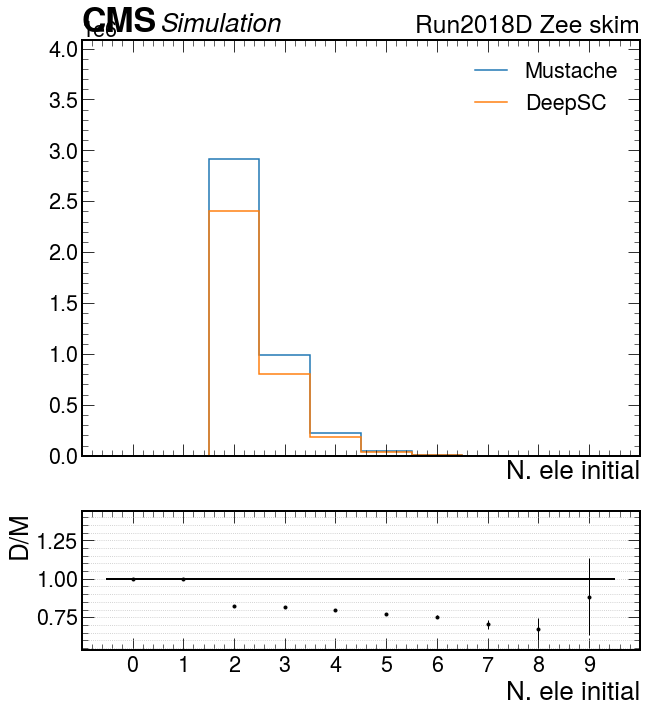

In [12]:
Hd = out["DeepSC"]["histos"]["nele_eff"].project("nele_initial")
Hm = out["Mustache"]["histos"]["nele_eff"].project("nele_initial")
plot_comparison_H(Hm, Hd, var="N_ele_initial", 
                output_folder=output_folder)

/tmp/ipykernel_12955/1137808563.py:95: RuntimeWarning: divide by zero encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_12955/1137808563.py:95: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_12955/1137808563.py:95: RuntimeWarning: invalid value encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_12955/1137808563.py:98: RuntimeWarning: invalid value encountered in true_divide
  A/B,


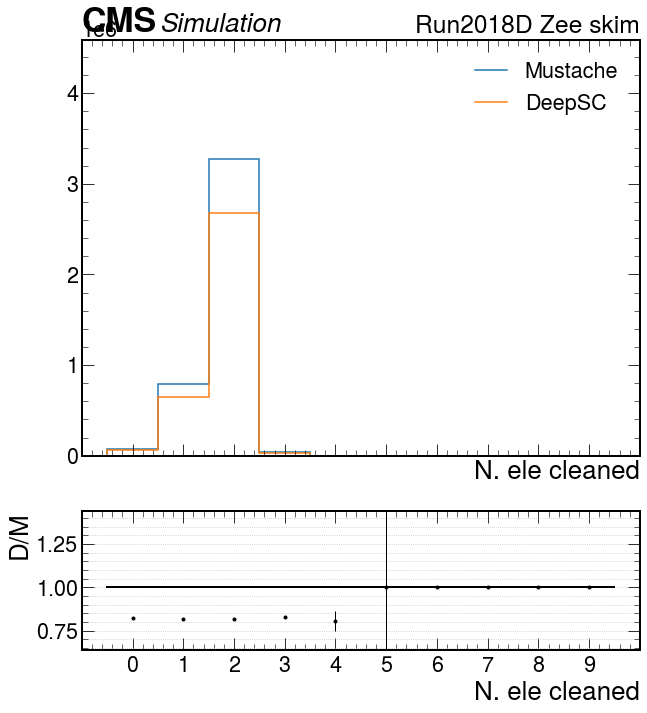

In [13]:
Hd = out["DeepSC"]["histos"]["nele_eff"].project("nele_clean")
Hm = out["Mustache"]["histos"]["nele_eff"].project("nele_clean")
plot_comparison_H(Hm, Hd, var="N_ele_clean", 
                output_folder=output_folder)

/tmp/ipykernel_12955/1137808563.py:95: RuntimeWarning: divide by zero encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_12955/1137808563.py:95: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_12955/1137808563.py:98: RuntimeWarning: divide by zero encountered in true_divide
  A/B,


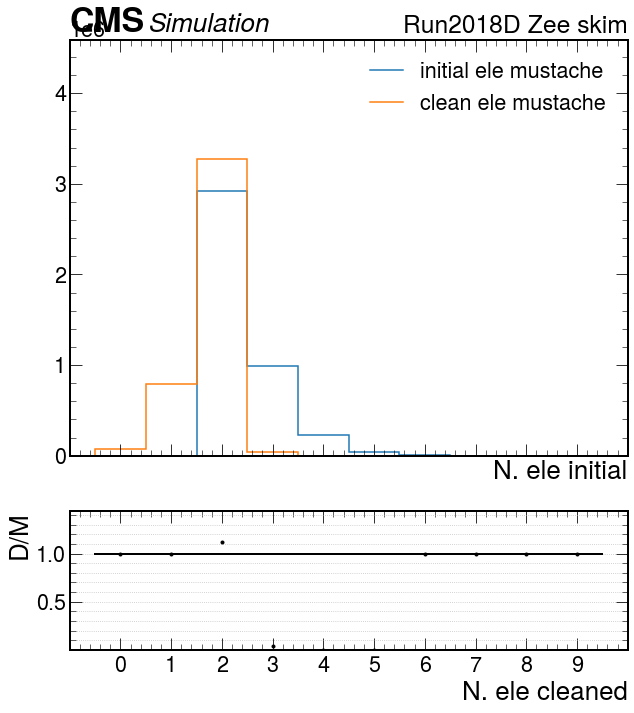

In [15]:
Hm = out["Mustache"]["histos"]["nele_eff"]
plot_comparison_H(Hm.project("nele_initial"), Hm.project("nele_clean"), var="N_ele_eff_must", 
                  legendB="initial ele mustache", legendA="clean ele mustache",
                output_folder=output_folder)

/tmp/ipykernel_8458/2429374711.py:95: RuntimeWarning: divide by zero encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_8458/2429374711.py:95: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_8458/2429374711.py:98: RuntimeWarning: divide by zero encountered in divide
  A/B,


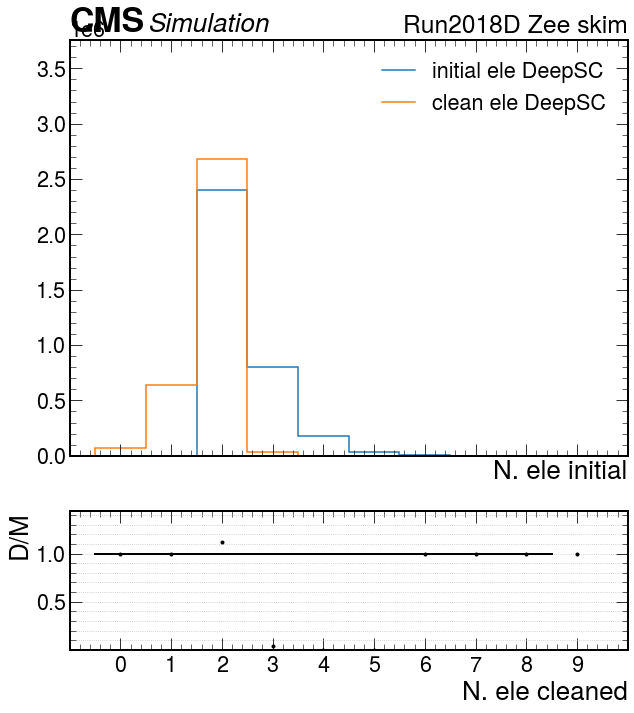

In [45]:
Hm = out["DeepSC"]["histos"]["nele_eff"]
plot_comparison_H(Hm.project("nele_initial"), Hm.project("nele_clean"), var="N_ele_eff_deepsc", 
                  legendB="initial ele DeepSC", legendA="clean ele DeepSC",
                output_folder=output_folder)

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f2e73146d90>, cbar=<matplotlib.colorbar.Colorbar object at 0x7f2e6d9e25b0>, text=[])

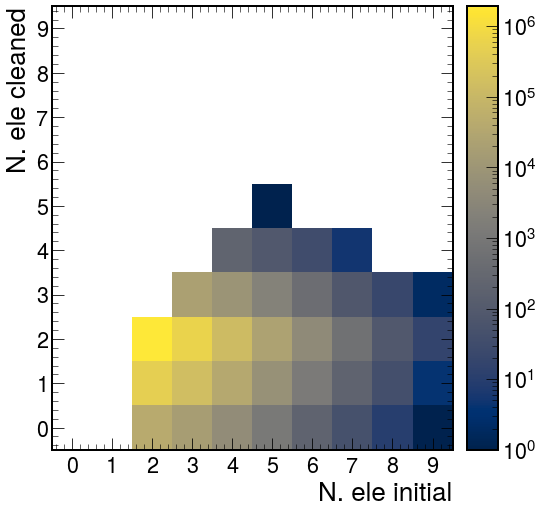

In [16]:
f = plt.figure(figsize=(8,8), dpi=72)
hep.hist2dplot(out["DeepSC"]["histos"]["nele_eff"], cmap="cividis", norm=LogNorm())

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f2e6d98cd30>, cbar=<matplotlib.colorbar.Colorbar object at 0x7f2e69c4c280>, text=[])

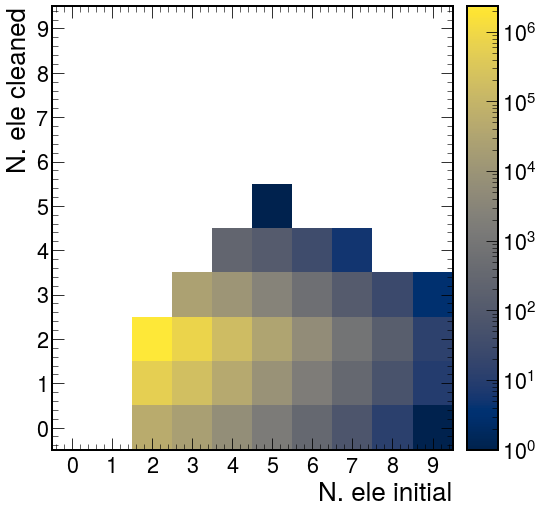

In [17]:
f = plt.figure(figsize=(8,8), dpi=72)
hep.hist2dplot(out["Mustache"]["histos"]["nele_eff"], cmap="cividis", norm=LogNorm())

Text(1, 9, 'DeepSC/Mustache')

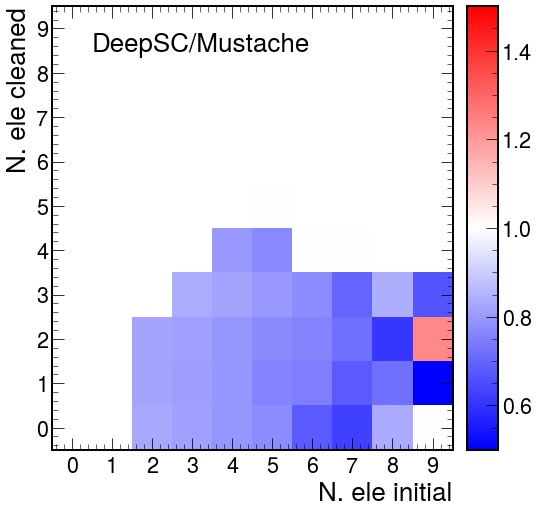

In [18]:
f = plt.figure(figsize=(8,8), dpi=72)
hep.hist2dplot(out["DeepSC"]["histos"]["nele_eff"]/out["Mustache"]["histos"]["nele_eff"], 
               cmap="bwr", vmin=0.5, vmax=1.5)
plt.text(1,9,"DeepSC/Mustache")

Text(1, 9, 'DeepSC/Mustache')

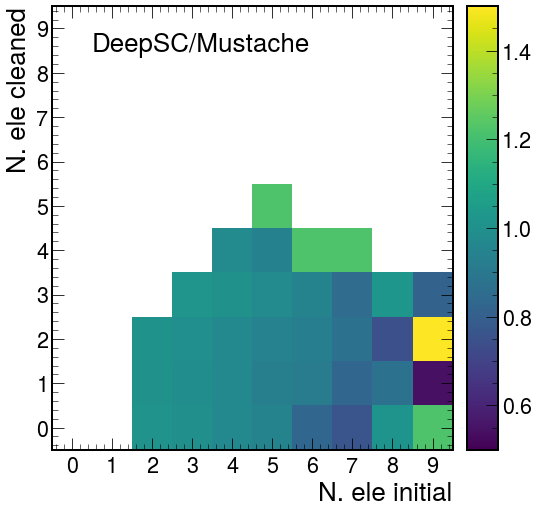

In [173]:
f = plt.figure(figsize=(8,8), dpi=72)
hep.hist2dplot(out["DeepSC"]["histos"]["nele_eff"]*D_ov_M/out["Mustache"]["histos"]["nele_eff"], 
               cmap="viridis", vmin=0.5, vmax=1.5)
plt.text(1,9,"DeepSC/Mustache")

### Miscellanea plots

B: 3040318.0
A. 3040394.866592133


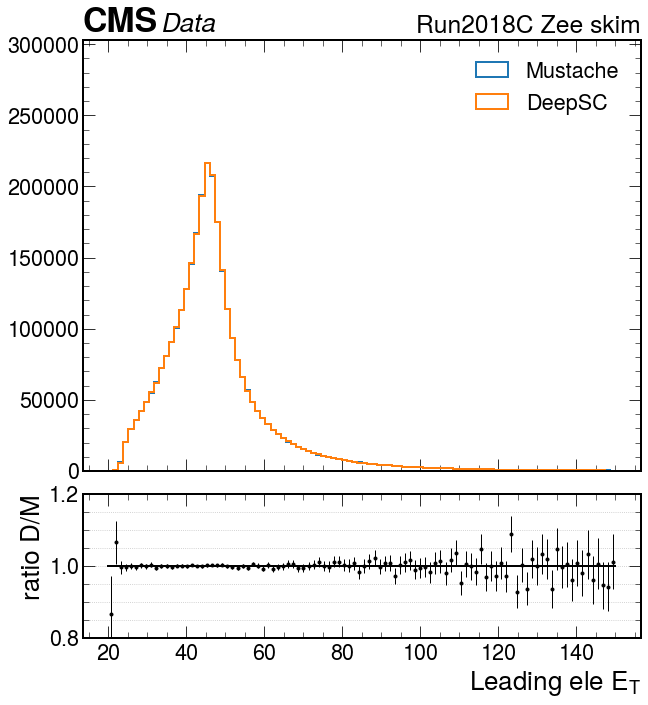

In [122]:
plot_comparison(Zm.ele_et,Zd.ele_et, var=f"ele_eta", output_folder=output_folder,
                  bins=100, xrange=(20,150), label="Leading ele $E_T$",
                wA= np.ones(len(Zd.ele_eta))*D_ov_M)

B: 3048981.0
A. 3048979.492574428


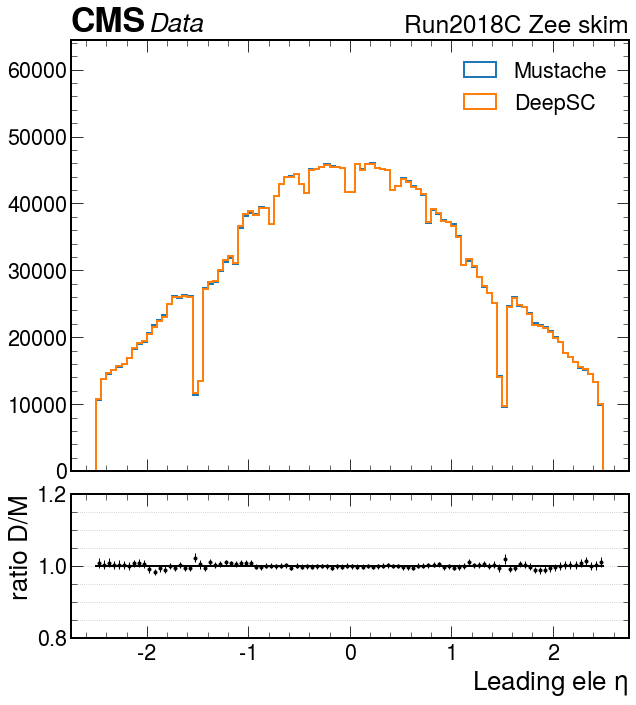

In [121]:
plot_comparison(Zm.ele_eta,Zd.ele_eta, var=f"ele_eta", output_folder=output_folder,
                  bins=100, xrange=(-2.5,2.5), label="Leading ele $\eta$",
                wA= np.ones(len(Zd.ele_eta))*D_ov_M)

## Electron plots

#### Classification

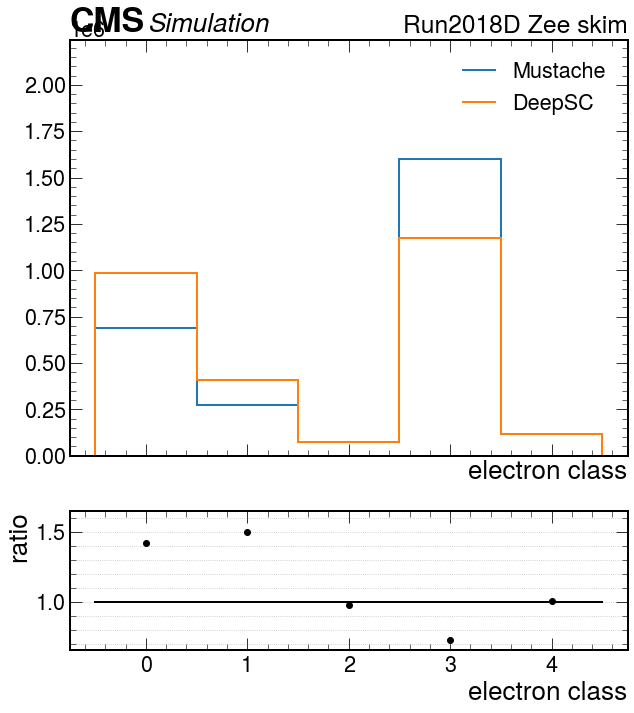

In [180]:
Hd = out["DeepSC"]["histos"]["ele_lead"].project("class")*D_ov_M
Hm = out["Mustache"]["histos"]["ele_lead"].project("class")
plot_comparison_H(Hm, Hd, var="ele_class",
                output_folder=output_folder)

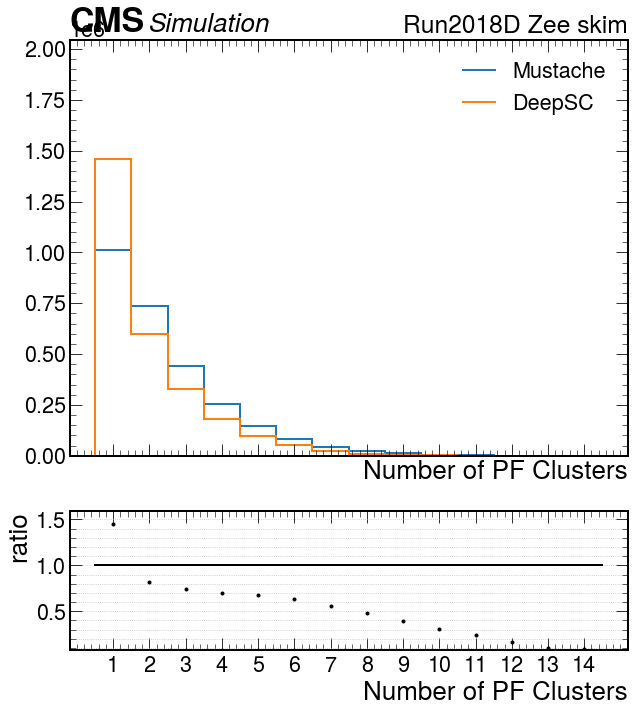

In [183]:
Hd = out["DeepSC"]["histos"]["ele_lead"].project("ncls")*D_ov_M
Hm = out["Mustache"]["histos"]["ele_lead"].project("ncls")
plot_comparison_H(Hm, Hd, var="npf_cls",
                output_folder=output_folder)

/tmp/ipykernel_12955/3951626944.py:95: RuntimeWarning: divide by zero encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_12955/3951626944.py:95: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_12955/3951626944.py:95: RuntimeWarning: invalid value encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_12955/3951626944.py:98: RuntimeWarning: invalid value encountered in true_divide
  A/B,


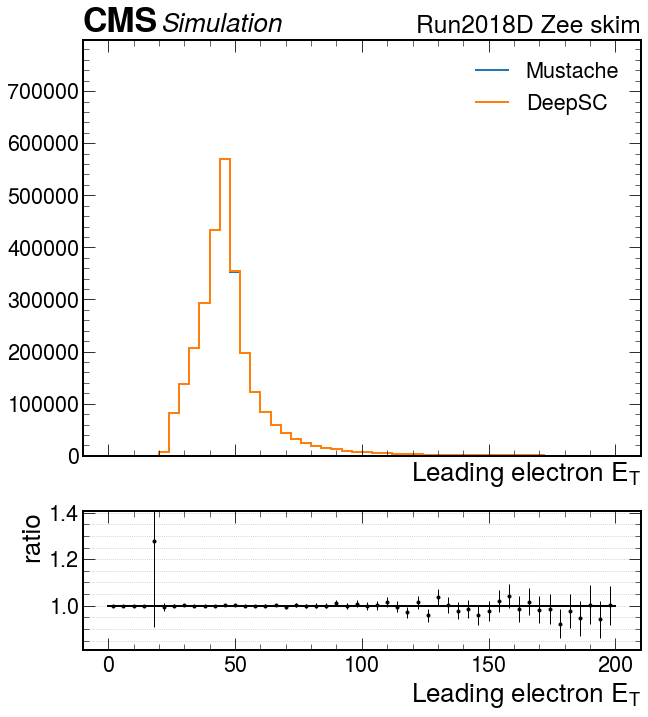

In [184]:
Hd = out["DeepSC"]["histos"]["ele_lead"].project("et")*D_ov_M
Hm = out["Mustache"]["histos"]["ele_lead"].project("et")
plot_comparison_H(Hm, Hd, var="lead_ele_et",
                output_folder=output_folder)

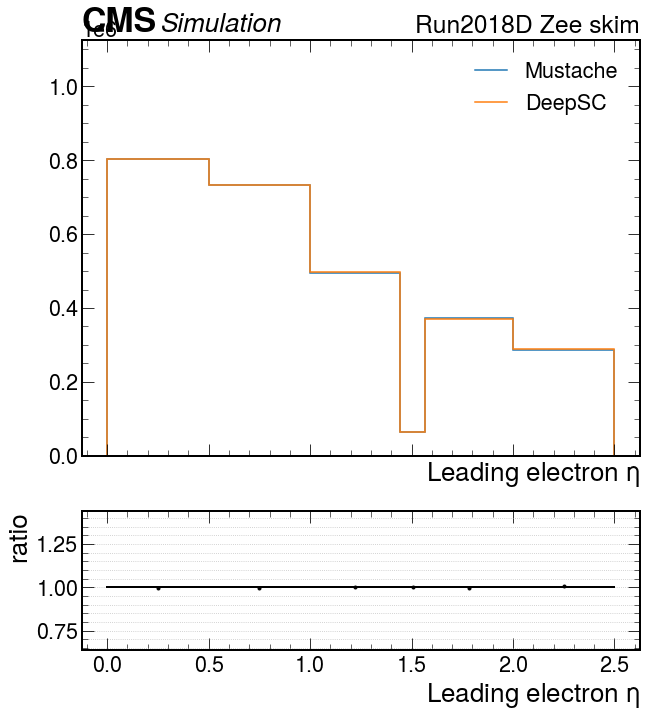

In [39]:
Hd = out["DeepSC"]["histos"]["ele_lead"].project("eta")*D_ov_M
Hm = out["Mustache"]["histos"]["ele_lead"].project("eta")
plot_comparison_H(Hm, Hd, var="lead_ele_eta",
                output_folder=output_folder)

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation'))

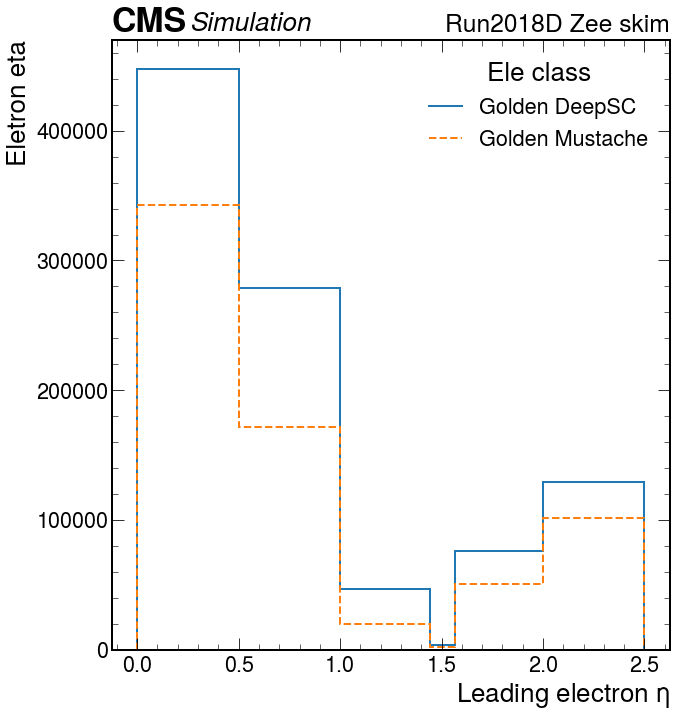

In [60]:
fig = plt.figure(figsize=(10,11), dpi=72)
Hd = out["DeepSC"]["histos"]["ele_lead"]*D_ov_M
Hm = out["Mustache"]["histos"]["ele_lead"]
hep.histplot(Hd[{"class":0}].project("eta"), label="Golden DeepSC", linewidth=2)
hep.histplot(Hm[{"class":0}].project("eta"), label="Golden Mustache", linewidth=2, linestyle="dashed")

plt.legend(title="Ele class")
plt.ylabel("Eletron eta")

hep.cms.label(rlabel="Run2018D Zee skim", loc=0, ax=plt.gca())

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation'))

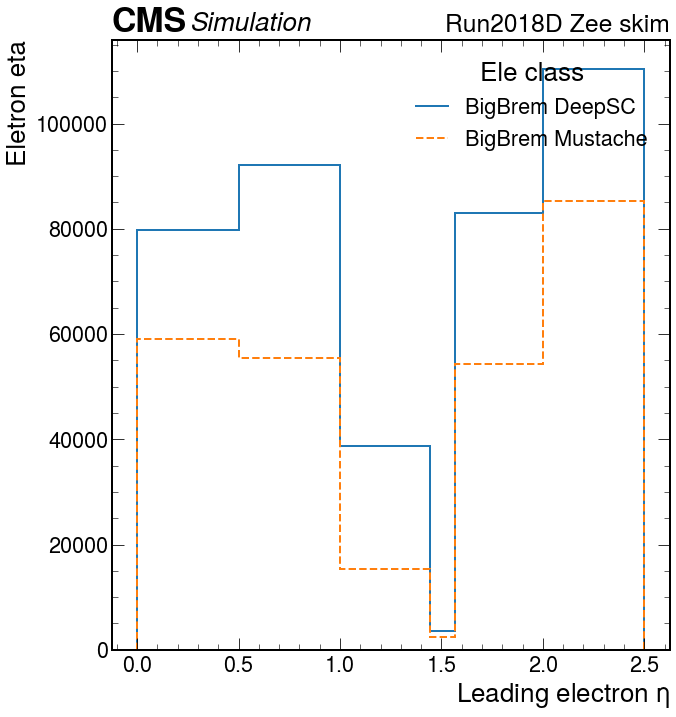

In [61]:
fig = plt.figure(figsize=(10,11), dpi=72)
Hd = out["DeepSC"]["histos"]["ele_lead"]*D_ov_M
Hm = out["Mustache"]["histos"]["ele_lead"]
hep.histplot(Hd[{"class":1}].project("eta"), label="BigBrem DeepSC",linewidth=2)
hep.histplot(Hm[{"class":1}].project("eta"), label="BigBrem Mustache",linestyle="dashed",linewidth=2)

plt.legend(title="Ele class")
plt.ylabel("Eletron eta")

hep.cms.label(rlabel="Run2018D Zee skim", loc=0, ax=plt.gca())

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation'))

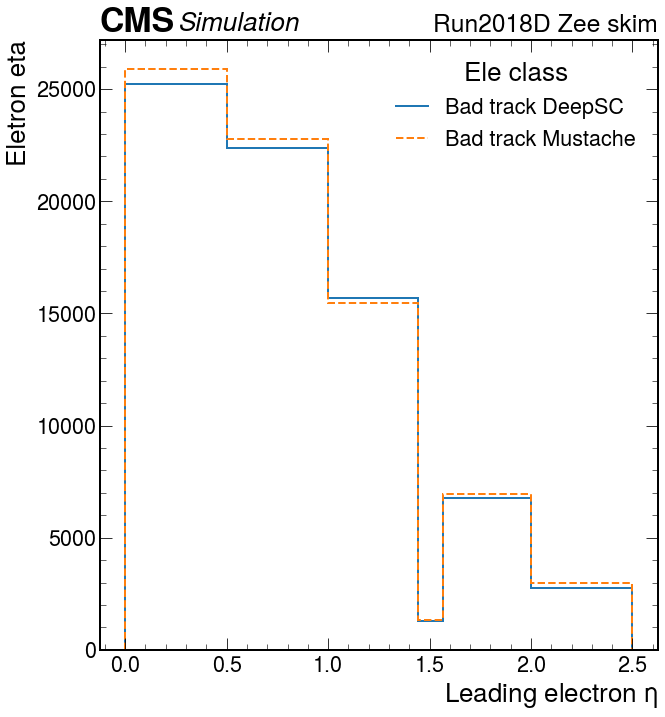

In [62]:
fig = plt.figure(figsize=(10,11), dpi=72)
Hd = out["DeepSC"]["histos"]["ele_lead"]*D_ov_M
Hm = out["Mustache"]["histos"]["ele_lead"]
hep.histplot(Hd[{"class":2}].project("eta"), label="Bad track DeepSC",linewidth=2)
hep.histplot(Hm[{"class":2}].project("eta"), label="Bad track Mustache",linestyle="dashed",linewidth=2)

plt.legend(title="Ele class")
plt.ylabel("Eletron eta")


hep.cms.label(rlabel="Run2018D Zee skim", loc=0, ax=plt.gca())

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation'))

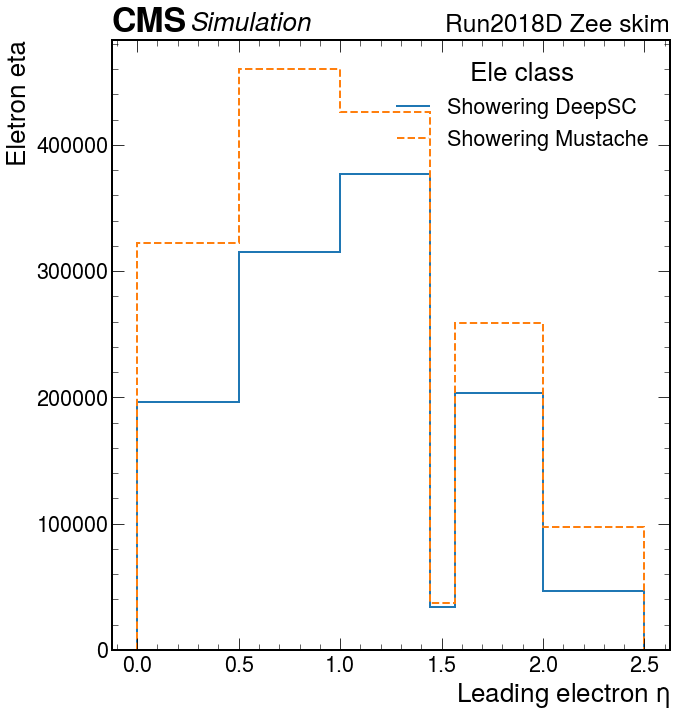

In [63]:
fig = plt.figure(figsize=(10,11), dpi=72)
Hd = out["DeepSC"]["histos"]["ele_lead"]*D_ov_M
Hm = out["Mustache"]["histos"]["ele_lead"]
hep.histplot(Hd[{"class":3}].project("eta"), label="Showering DeepSC",linewidth=2)
hep.histplot(Hm[{"class":3}].project("eta"), label="Showering Mustache",linestyle="dashed",linewidth=2)

plt.legend(title="Ele class")
plt.ylabel("Eletron eta")


hep.cms.label(rlabel="Run2018D Zee skim", loc=0, ax=plt.gca())

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation'))

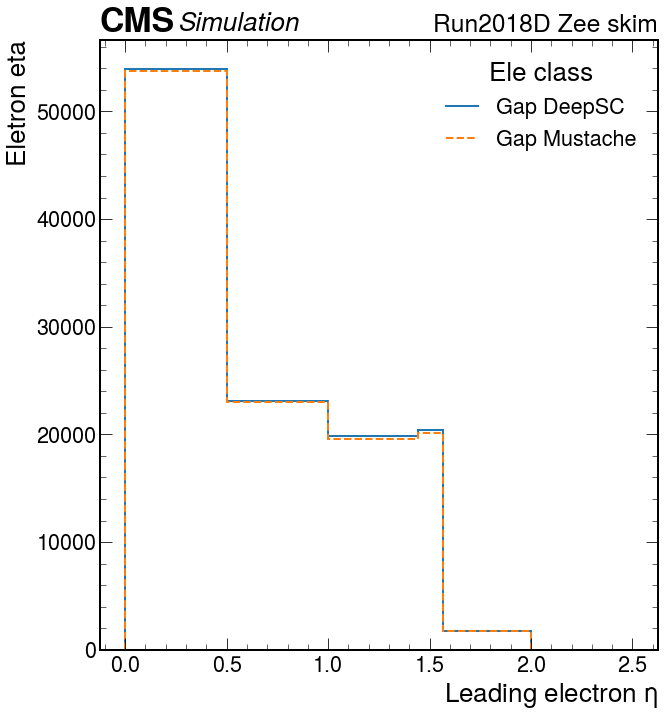

In [64]:
fig = plt.figure(figsize=(10,11), dpi=72)
Hd = out["DeepSC"]["histos"]["ele_lead"]*D_ov_M
Hm = out["Mustache"]["histos"]["ele_lead"]
hep.histplot(Hd[{"class":4}].project("eta"), label="Gap DeepSC",linewidth=2)
hep.histplot(Hm[{"class":4}].project("eta"), label="Gap Mustache",linestyle="dashed",linewidth=2)

plt.legend(title="Ele class")
plt.ylabel("Eletron eta")


hep.cms.label(rlabel="Run2018D Zee skim", loc=0, ax=plt.gca())

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation'))

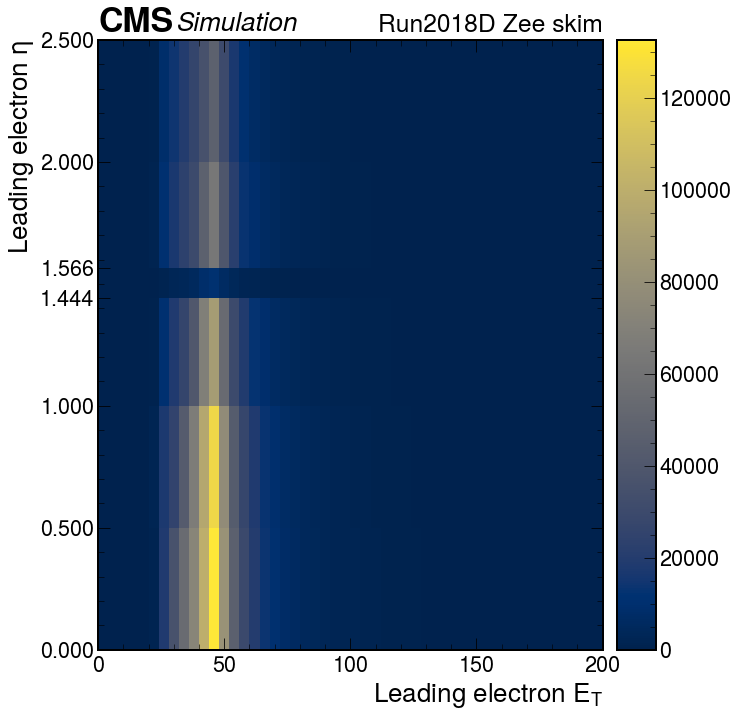

In [77]:
fig = plt.figure(figsize=(10,11), dpi=72)
hep.hist2dplot(out["DeepSC"]["histos"]["ele_lead"][{"class":sum, "ncls":sum}], cmap="cividis")
hep.cms.label(rlabel="Run2018D Zee skim", loc=0, ax=plt.gca())

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Simulation'))

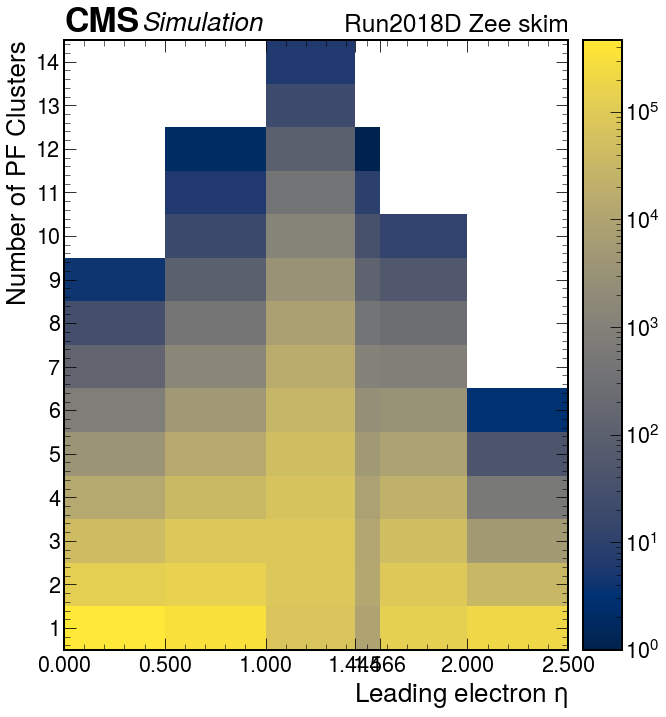

In [79]:
fig = plt.figure(figsize=(10,11), dpi=72)
hep.hist2dplot(out["DeepSC"]["histos"]["ele_lead"][{"class":sum, "et":sum}], cmap="cividis", norm=LogNorm())
hep.cms.label(rlabel="Run2018D Zee skim", loc=0, ax=plt.gca())

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Simulation'))

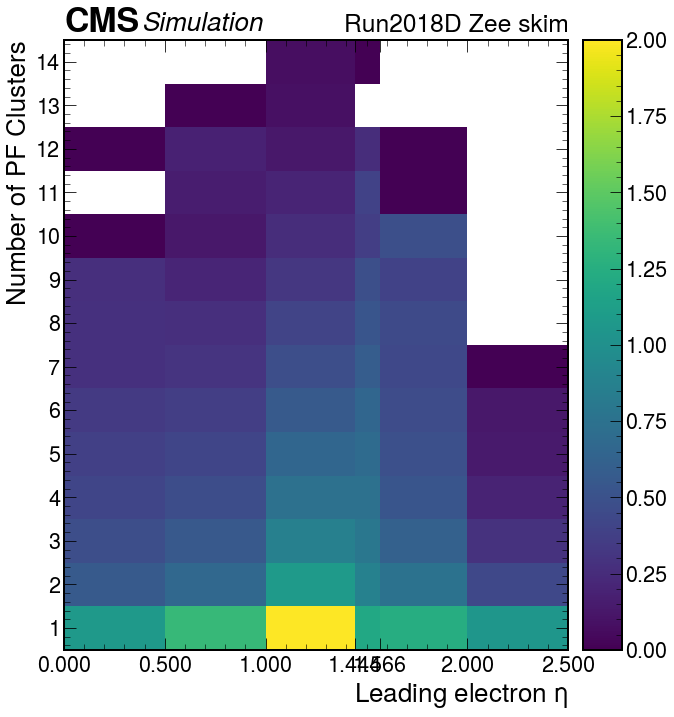

In [188]:
fig = plt.figure(figsize=(10,11), dpi=72)
hep.hist2dplot(out["DeepSC"]["histos"]["ele_lead"][{"class":sum, "et":sum}]/out["Mustache"]["histos"]["ele_lead"][{"class":sum, "et":sum}], 
               cmap="viridis", vmin=0, vmax=2)
hep.cms.label(rlabel="Run2018D Zee skim", loc=0, ax=plt.gca())

# Study the Z

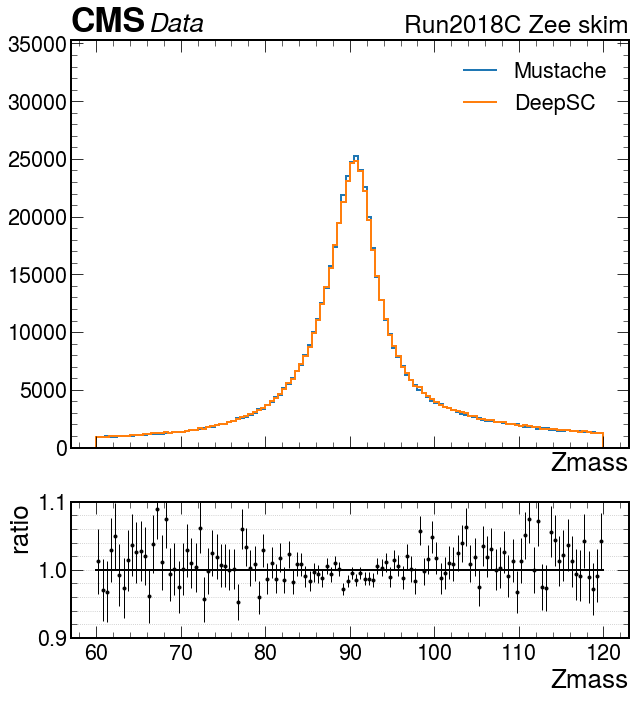

In [8]:
H_M = out["Mustache"]["histos"]["Z"][{"class":0}].project("zmass")
H_D = out["DeepSC"]["histos"]["Z"][{"class":0}].project("zmass")*D_ov_M
                                                        
dovm = np.sum(H_M.values())/  np.sum(H_D.values())

plot_comparison_H(H_M,H_D*dovm, var="Z_mass_golden", output_folder=output_folder)

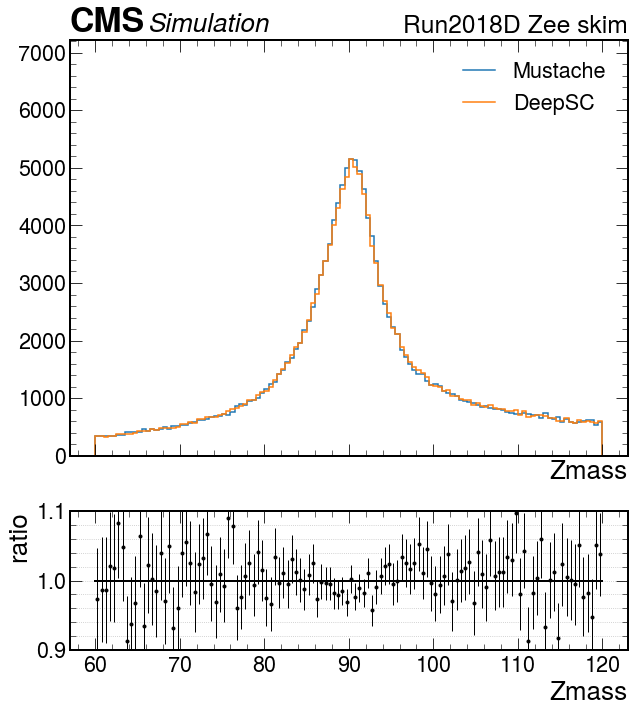

In [121]:
H_M = out["Mustache"]["histos"]["Z"][{"class":1}].project("zmass")
H_D = out["DeepSC"]["histos"]["Z"][{"class":1}].project("zmass")*D_ov_M
                                                        
dovm = np.sum(H_M.values())/  np.sum(H_D.values())

plot_comparison_H(H_M,H_D*dovm, var="Z_mass_bigbrem", output_folder=output_folder)

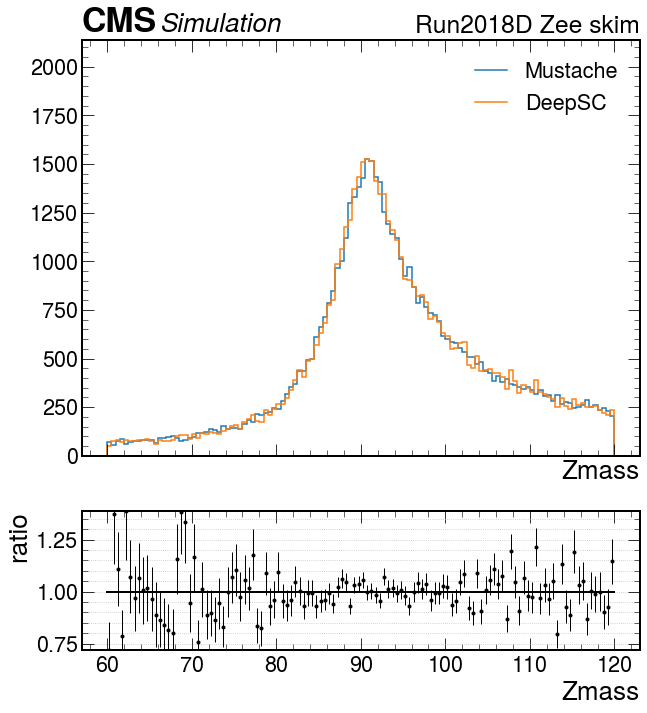

In [122]:
H_M = out["Mustache"]["histos"]["Z"][{"class":2}].project("zmass")
H_D = out["DeepSC"]["histos"]["Z"][{"class":2}].project("zmass")*D_ov_M
                                                        
dovm = np.sum(H_M.values())/  np.sum(H_D.values())

plot_comparison_H(H_M,H_D*dovm, var="Z_mass_badtrack", output_folder=output_folder)

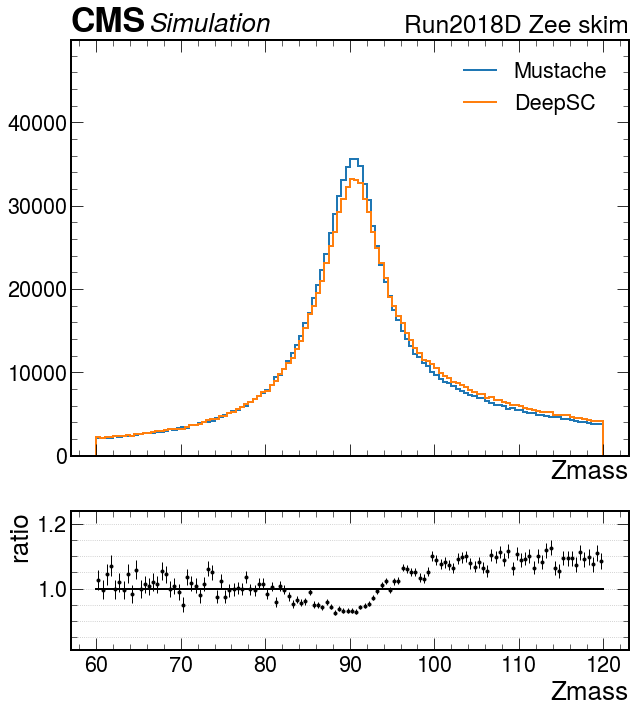

In [192]:
H_M = out["Mustache"]["histos"]["Z"][{"class":3}].project("zmass")
H_D = out["DeepSC"]["histos"]["Z"][{"class":3}].project("zmass")*D_ov_M
                                                        
dovm = np.sum(H_M.values())/  np.sum(H_D.values())

plot_comparison_H(H_M,H_D*dovm, var="Z_mass_showering", output_folder=output_folder)

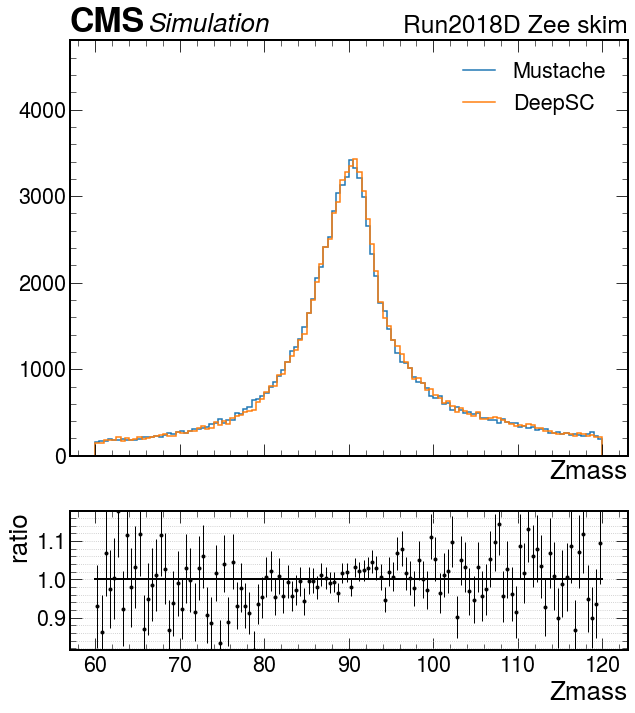

In [125]:
H_M = out["Mustache"]["histos"]["Z"][{"class":4}].project("zmass")
H_D = out["DeepSC"]["histos"]["Z"][{"class":4}].project("zmass")*D_ov_M
                                                        
dovm = np.sum(H_M.values())/  np.sum(H_D.values())

plot_comparison_H(H_M,H_D*dovm, var="Z_mass_gap", output_folder=output_folder)

### Going deeper looking at the PU

In [89]:
H_M = out["Mustache"]["histos"]["Z"]
H_D = out["DeepSC"]["histos"]["Z"]

H_M.axes["eta"].label="Leading electron $\eta$"
H_D.axes["eta"].label="Leading electron $\eta$"
H_M.axes["rho"].label="rho"
H_D.axes["rho"].label="rho"

In [86]:
H_D

Hist(
  Regular(120, 60, 120, name='zmass', label='Zmass'),
  Regular(30, 0, 200, name='et', label='Leading electron $E_T$'),
  Variable([0, 0.5, 1, 1.4442, 1.566, 2, 2.5], name='eta', label='Leading electron $\\eta$'),
  Integer(1, 15, name='ncls', label='Number of PF Clusters'),
  Regular(30, 0, 70, name='rho', label='$\rho$'),
  IntCategory([0, 1, 2, 3, 4], name='class', label='electron class'),
  storage=Double()) # Sum: 1664434.0 (2259418.0 with flow)

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation'))

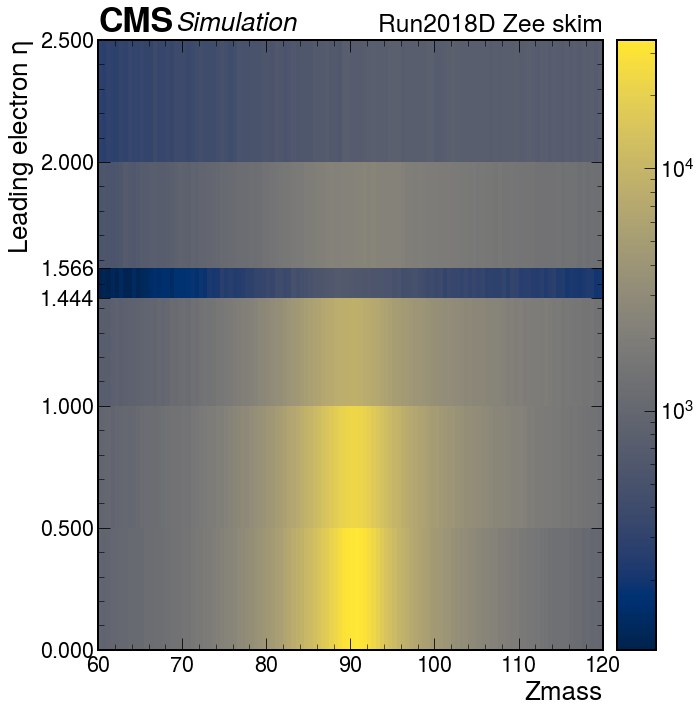

In [92]:
fig = plt.figure(figsize=(10,11), dpi=72)
hep.hist2dplot(H_M[{"class":sum, "et":sum, "rho":sum,"ncls":sum}], cmap="cividis", norm=LogNorm())
hep.cms.label(rlabel="Run2018D Zee skim", loc=0, ax=plt.gca())

### Mass peak by rho

/tmp/ipykernel_12955/564978946.py:95: RuntimeWarning: divide by zero encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_12955/564978946.py:95: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_12955/564978946.py:95: RuntimeWarning: invalid value encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_12955/564978946.py:98: RuntimeWarning: invalid value encountered in true_divide
  A/B,


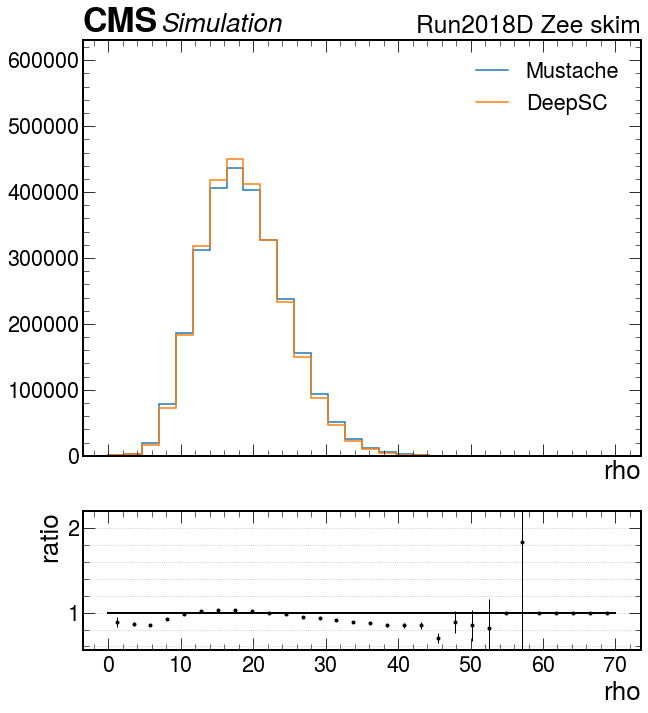

In [104]:
H_M = out["Mustache"]["histos"]["Z"].project("rho")
H_D = out["DeepSC"]["histos"]["Z"].project("rho")*D_ov_M
                                                        
#dovm = np.sum(H_M.values())/  np.sum(H_D.values())

plot_comparison_H(H_M,H_D, var="rho", output_folder=output_folder)

In [101]:
out["Mustache"]["histos"]["`Z"]

Hist(
  Regular(120, 60, 120, name='zmass', label='Zmass'),
  Regular(30, 0, 200, name='et', label='Leading electron $E_T$'),
  Variable([0, 0.5, 1, 1.4442, 1.566, 2, 2.5], name='eta', label='Leading electron $\\eta$'),
  Integer(1, 15, name='ncls', label='Number of PF Clusters'),
  Regular(30, 0, 70, name='rho'),
  IntCategory([0, 1, 2, 3, 4], name='class', label='electron class'),
  storage=Double()) # Sum: 2033201.0 (2757796.0 with flow)

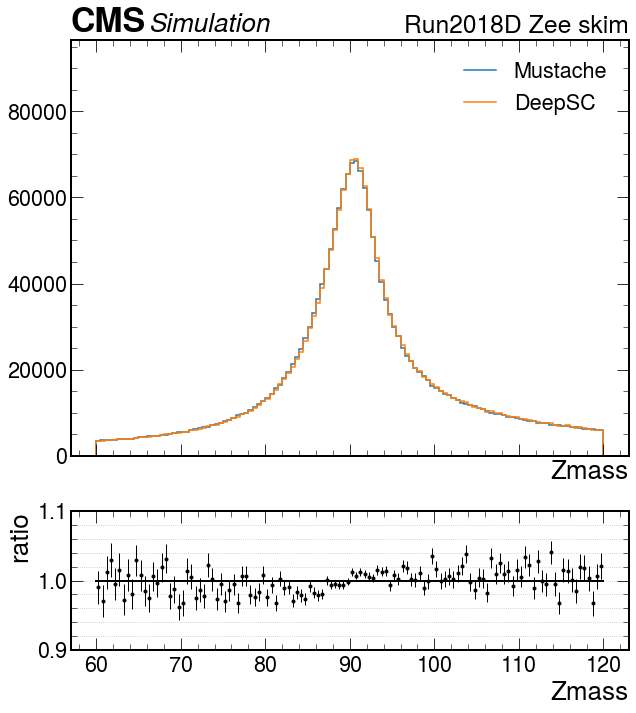

In [114]:
H_M = out["Mustache"]["histos"]["Z"][{"rho":slice(15j, 25j)}].project("zmass")
H_D = out["DeepSC"]["histos"]["Z"][{"rho":slice(15j, 25j)}].project("zmass")
                                                        
dovm = np.sum(H_M.values())/  np.sum(H_D.values())

plot_comparison_H(H_M,H_D*dovm, var="Z_mass_rho_15_25", output_folder=output_folder)

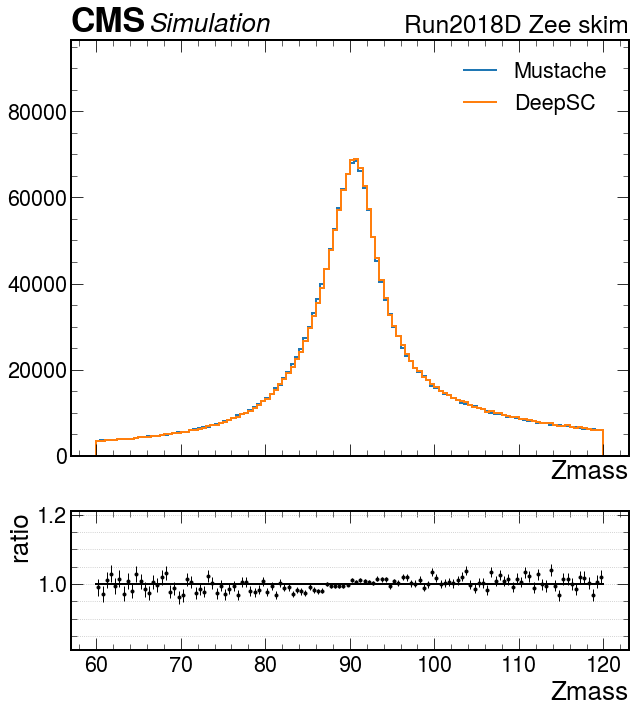

In [190]:
H_M = out["Mustache"]["histos"]["Z"][{"rho":slice(0j, 40j)}].project("zmass")
H_D = out["DeepSC"]["histos"]["Z"][{"rho":slice(0j, 40j)}].project("zmass")
                                                        
dovm = np.sum(H_M.values())/  np.sum(H_D.values())

plot_comparison_H(H_M,H_D*dovm, var="Z_mass_rho_0_40", output_folder=output_folder)

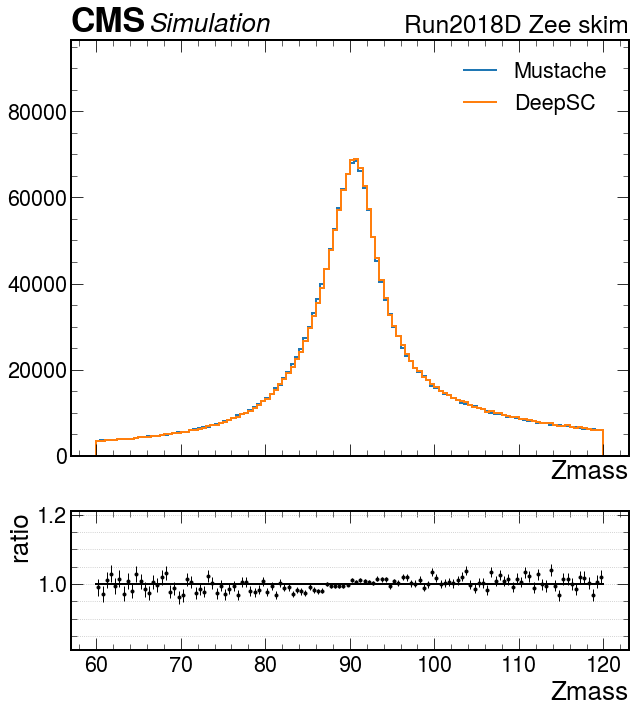

In [191]:
H_M = out["Mustache"]["histos"]["Z"][{"rho":slice(40j,70j)}].project("zmass")
H_D = out["DeepSC"]["histos"]["Z"][{"rho":slice(40j,70j)}].project("zmass")
                                                        
dovm = np.sum(H_M.values())/  np.sum(H_D.values())

plot_comparison_H(H_M,H_D*dovm, var="Z_mass_rho_40_70", output_folder=output_folder)

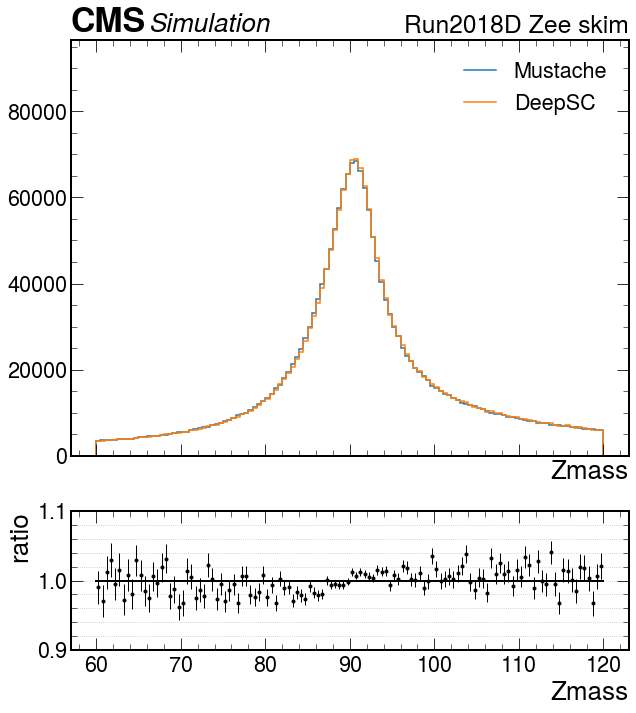

In [113]:
H_M = out["Mustache"]["histos"]["Z"][{"rho":slice(0j,15j)}].project("zmass")
H_D = out["DeepSC"]["histos"]["Z"][{"rho":slice(0j,15j)}].project("zmass")
                                                        
dovm = np.sum(H_M.values())/  np.sum(H_D.values())

plot_comparison_H(H_M,H_D*dovm, var="Z_mass_rho_15low", output_folder=output_folder)

### Mass peak by eta and class

In [130]:
ZH = out["Mustache"]["histos"]["Z"]
ZH

Hist(
  Regular(120, 60, 120, name='zmass', label='Zmass'),
  Regular(30, 0, 200, name='et', label='Leading electron $E_T$'),
  Variable([0, 0.5, 1, 1.4442, 1.566, 2, 2.5], name='eta', label='Leading electron $\\eta$'),
  Integer(1, 15, name='ncls', label='Number of PF Clusters'),
  Regular(30, 0, 70, name='rho'),
  IntCategory([0, 1, 2, 3, 4], name='class', label='electron class'),
  storage=Double()) # Sum: 2033201.0 (2757796.0 with flow)

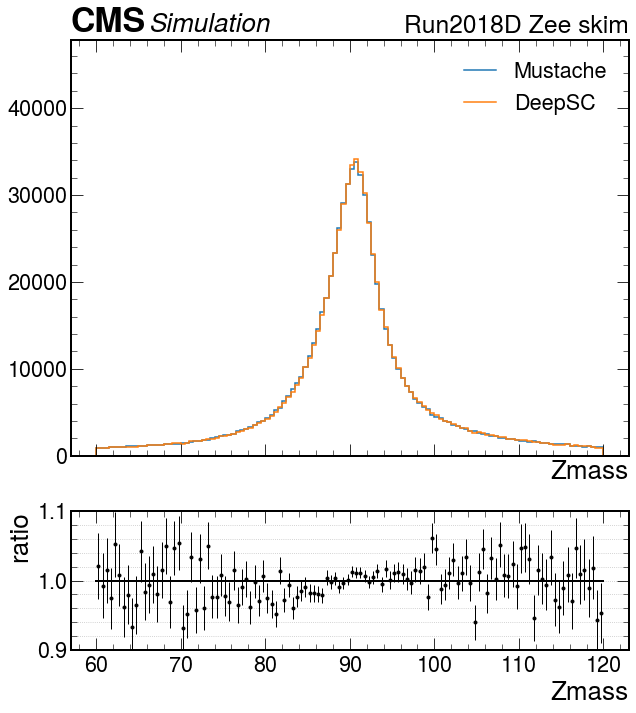

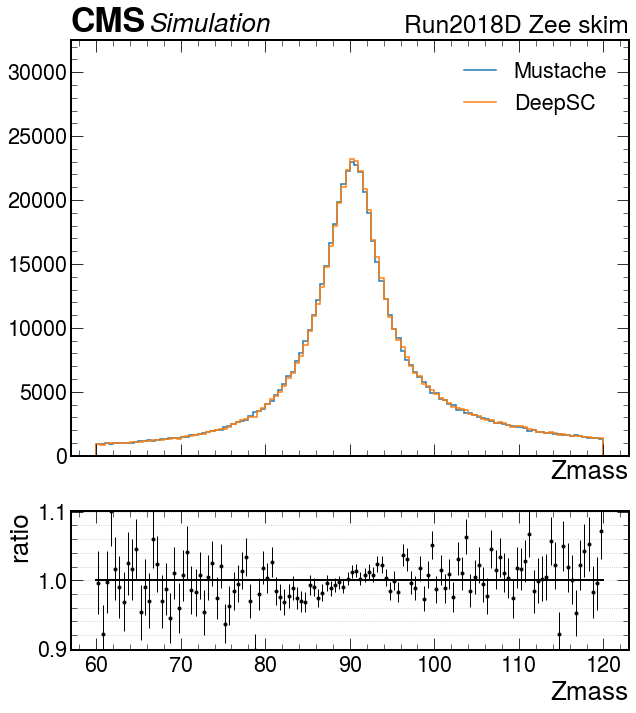

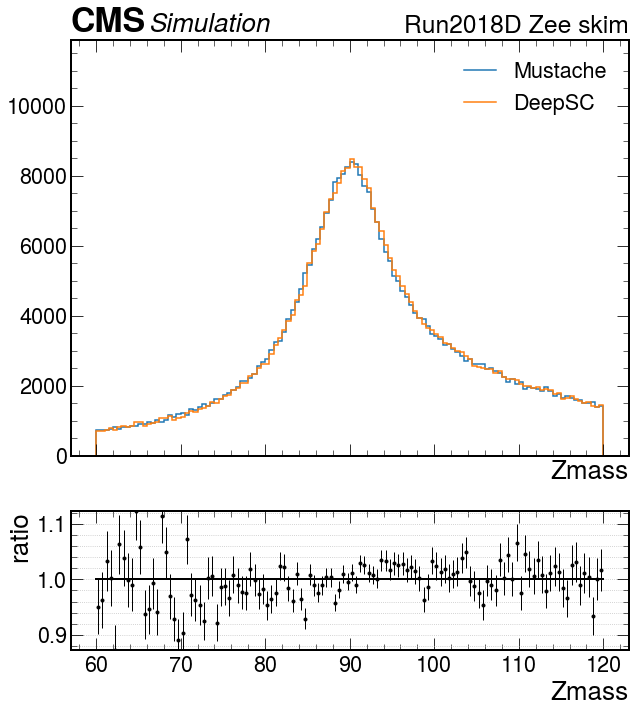

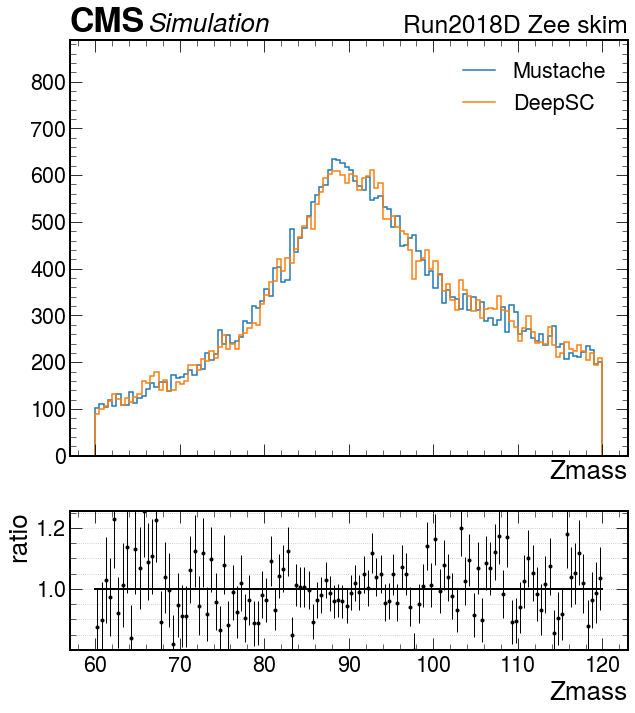

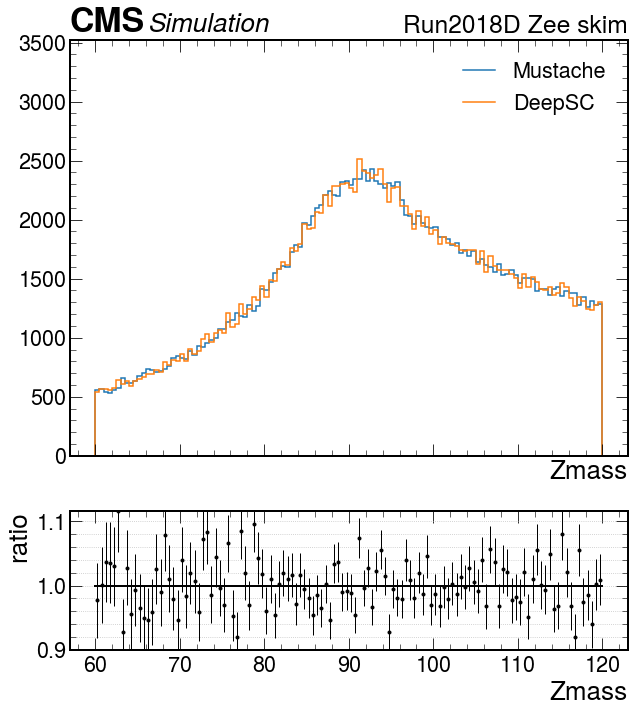

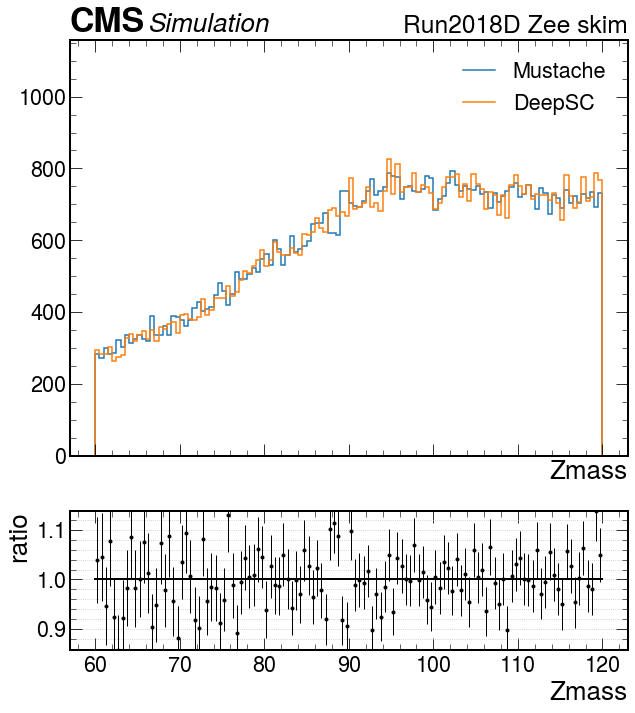

In [131]:
for ieta in range(6):
    H_M = out["Mustache"]["histos"]["Z"][{"eta":ieta}].project("zmass")
    H_D = out["DeepSC"]["histos"]["Z"][{"eta":ieta}].project("zmass")

    dovm = np.sum(H_M.values())/  np.sum(H_D.values())

    plot_comparison_H(H_M,H_D*dovm, var=f"Z_mass_eta_{ZH.axes[0][ieta]}_{ZH.axes[0][ieta+1]}", output_folder=output_folder)

In [152]:
H_M

0          102.890564
1           91.826904
9           87.522133
10          95.972389
19          65.401886
              ...    
2757776     90.537422
2757783     93.162903
2757790    109.667313
2757791     99.847992
2757793     88.768745
Name: mass, Length: 804069, dtype: float32

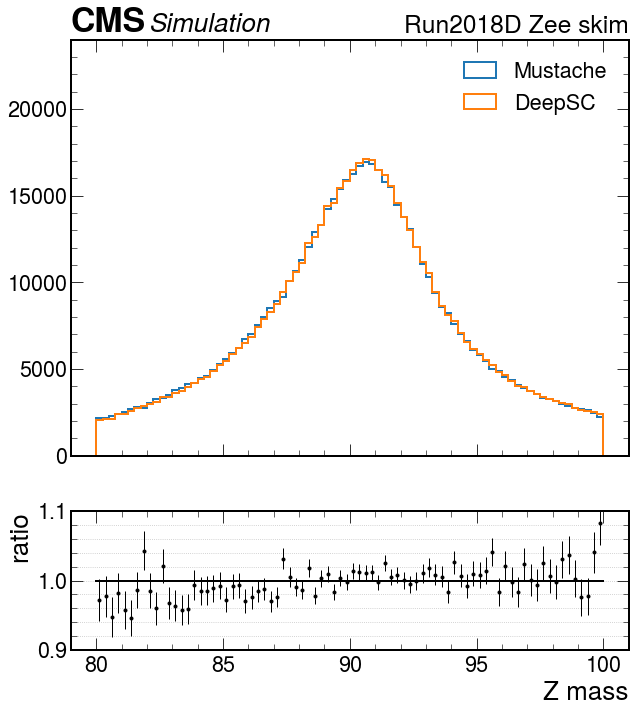

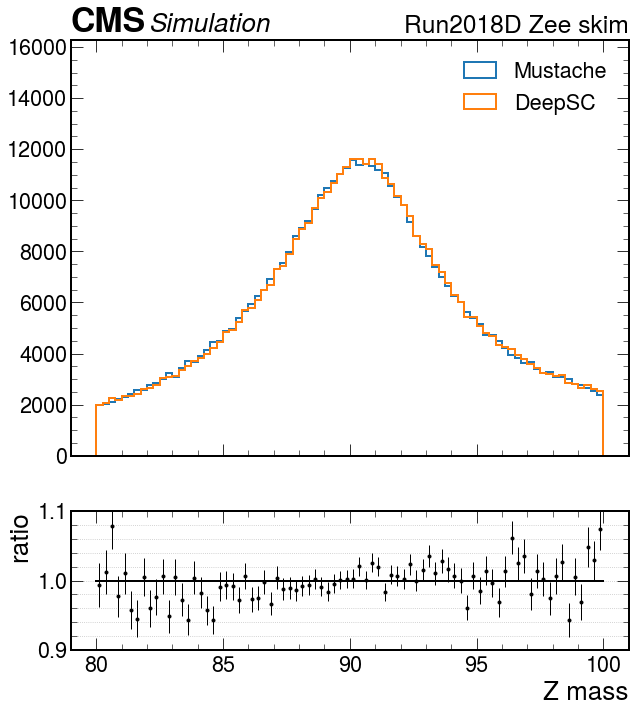

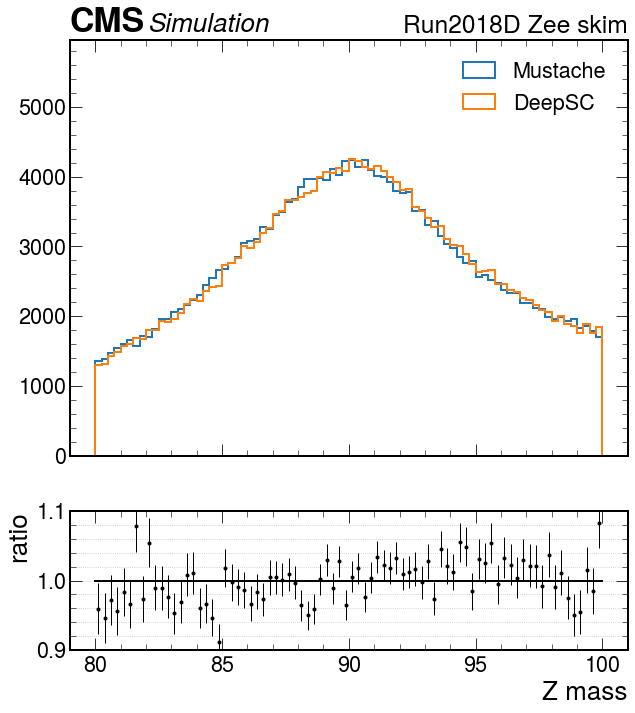

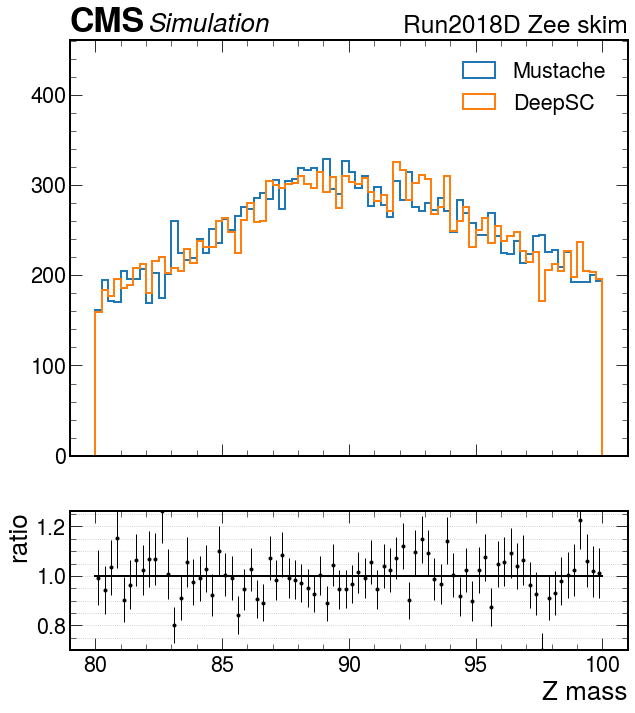

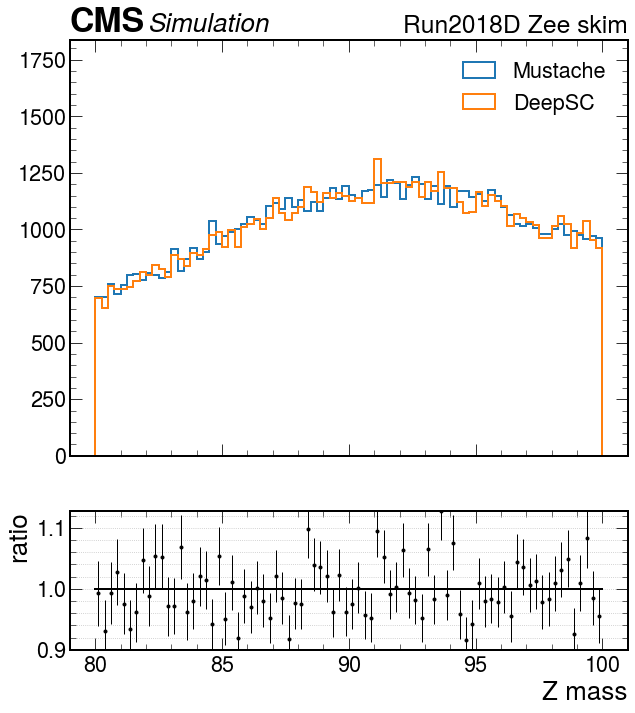

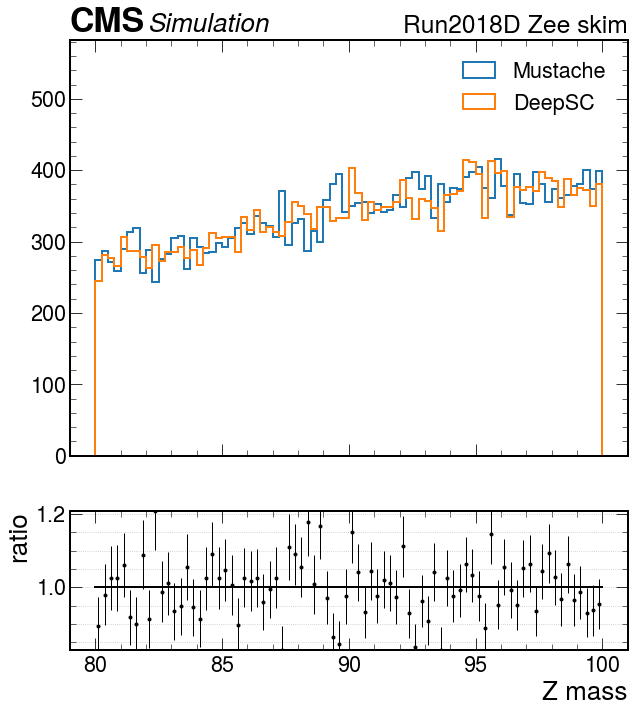

In [156]:
etas = [0, 0.5, 1, 1.4442, 1.566, 2, 2.5]

for ieta in range(len(etas)-1):
    H_M = Zm[(abs(Zm.ele_eta)>etas[ieta])&(abs(Zm.ele_eta)<etas[ieta+1])].mass
    H_D = Zd[(abs(Zd.ele_eta)>etas[ieta])&(abs(Zd.ele_eta)<etas[ieta+1])].mass

    plot_comparison(H_M,H_D, var=f"Z_mass_eta_{ZH.axes[0][ieta]}_{ZH.axes[0][ieta+1]}", output_folder=output_folder,
                      bins=80, xrange=(80,100), label="Z mass", wA= np.ones(len(H_D))*len(H_M)/len(H_D) )

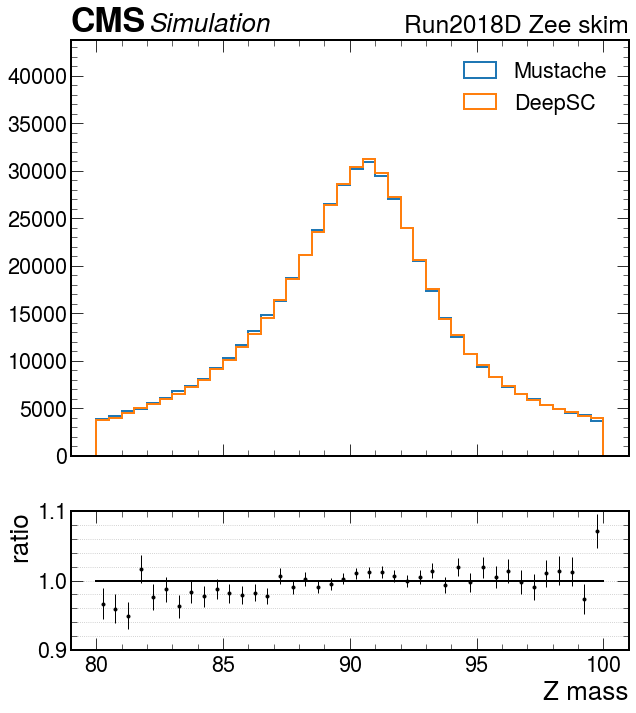

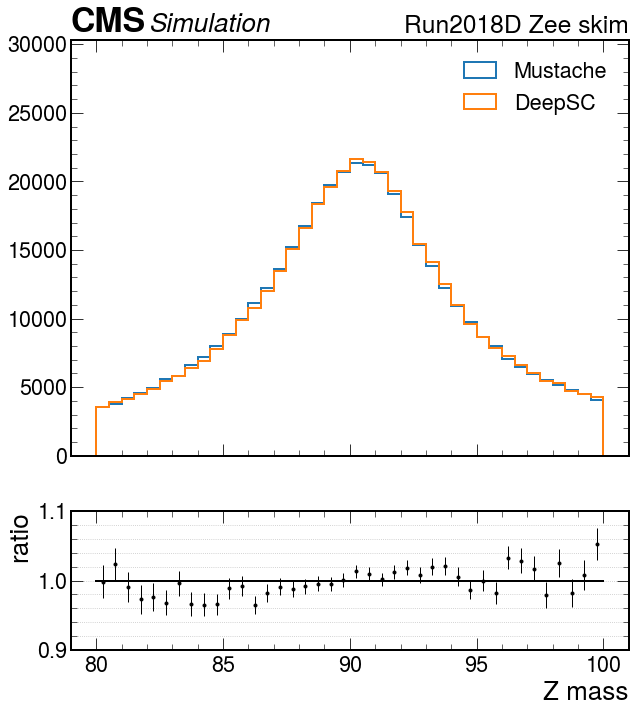

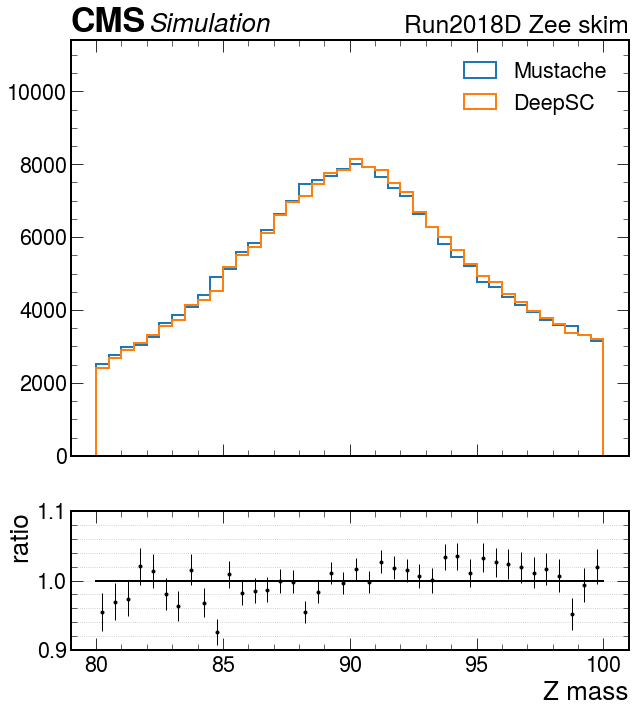

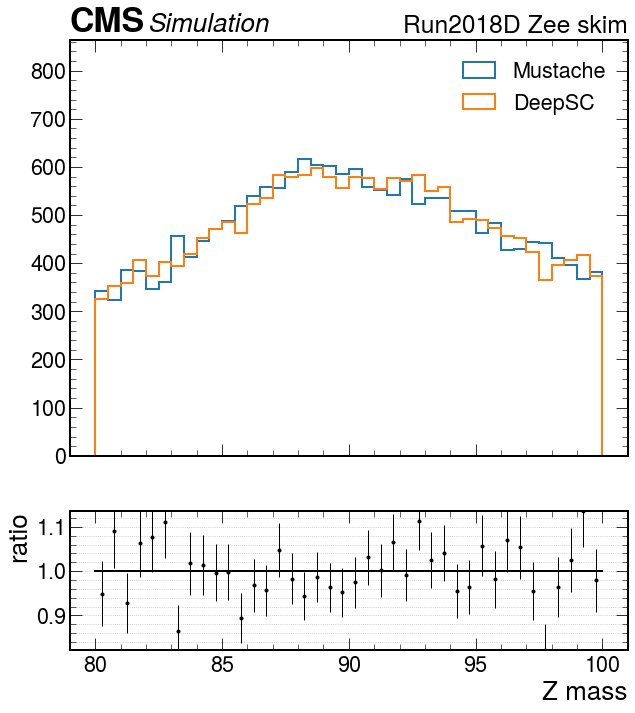

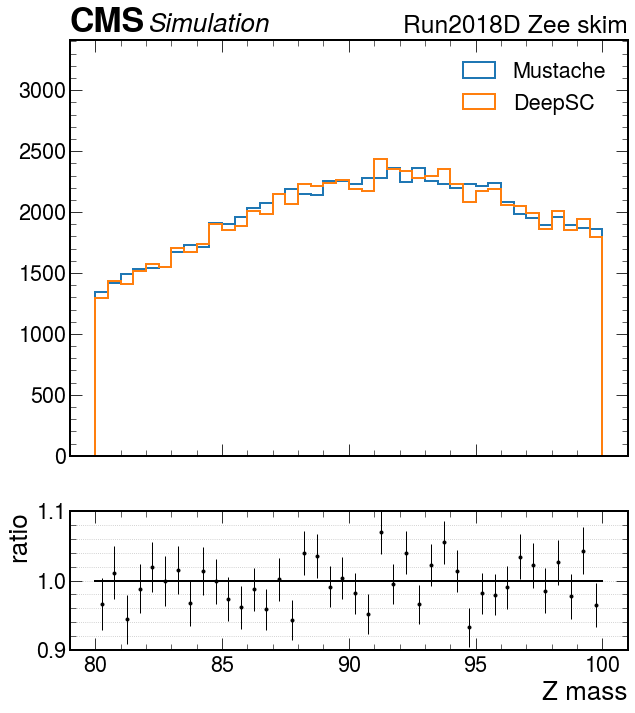

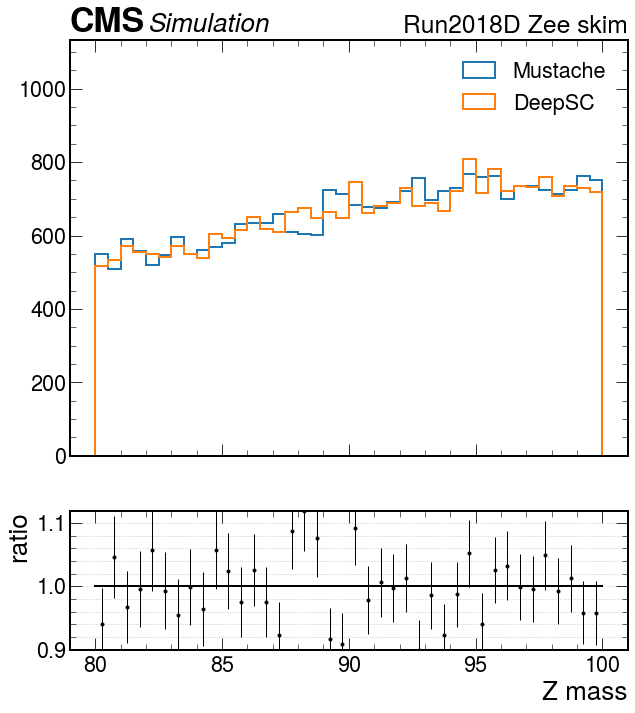

In [159]:
etas = [0, 0.5, 1, 1.4442, 1.566, 2, 2.5]

for ieta in range(len(etas)-1):
    H_M = Zm[(abs(Zm.ele_eta)>etas[ieta])&(abs(Zm.ele_eta)<etas[ieta+1])&(Zm.ele_et < 60)].mass
    H_D = Zd[(abs(Zd.ele_eta)>etas[ieta])&(abs(Zd.ele_eta)<etas[ieta+1])&(Zd.ele_et < 60)].mass

    plot_comparison(H_M,H_D, var=f"Z_mass_eta_{ZH.axes[0][ieta]}_{ZH.axes[0][ieta+1]}_eleet_20_60", output_folder=output_folder,
                      bins=40, xrange=(80,100), label="Z mass", wA= np.ones(len(H_D))*len(H_M)/len(H_D) )

In [162]:
Zm

ele_eta        mass      ele_et        r9  nvtx  ele_class  \
0        0.108496  102.890564   32.488907  0.946306    36          3   
1        0.010547   91.826904   41.667603  0.997720    31          0   
2        2.486633  157.666992   40.526669  0.991934    22          1   
3        2.441360  229.449066   40.835987  1.000716    20          0   
4        1.870251  299.550171   73.279114  0.972651    20          1   
...           ...         ...         ...       ...   ...        ...   
2757791 -0.224917   99.847992  217.387207  0.958393    34          0   
2757792 -1.294590   88.956627   43.903740  0.573559    41          3   
2757793  0.442682   88.768745   44.129726  0.774813    35          3   
2757794  1.697847  127.916870   59.261810  0.835378    32          3   
2757795  0.731955   96.881638   38.805927  0.969499    32          3   

               rho ele_eta_bin ele_et_bin  
0        19.561445           0          1  
1        25.562391           0          2  
2        17.672285           5          2  
3        15.906266           5          2  
4        13.504101           4          3  
...            ...         ...        ...  
2757791  25.198494           0        NaN  
2757792  28.362663           2          2  
2757793  24.362032           0          2  
2757794  22.317822           4          2  
2757795  20.645901           1          1  

[2757796 rows x 9 columns]

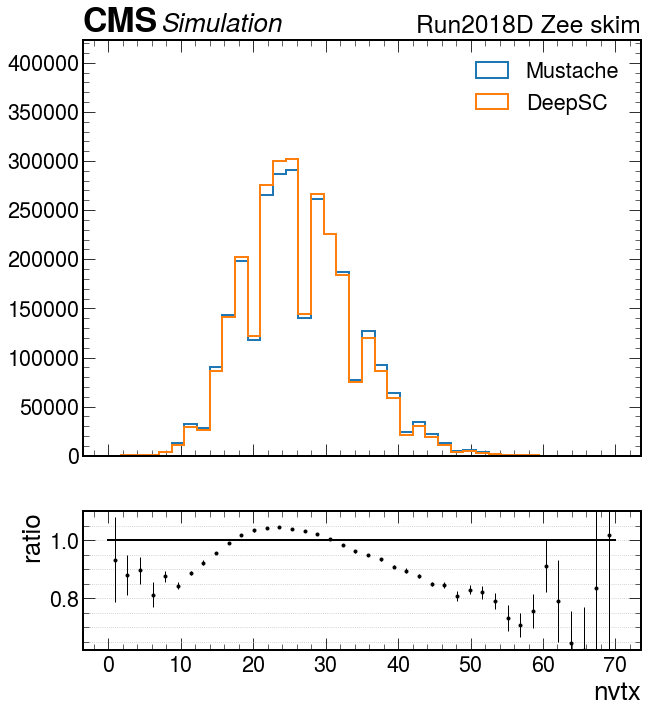

In [167]:
plot_comparison(Zm.nvtx,Zd.nvtx, var=f"nvtx", output_folder=output_folder,
                  bins=40, xrange=(0,70), label="nvtx" , wA= np.ones(len(Zd.nvtx))*D_ov_M)

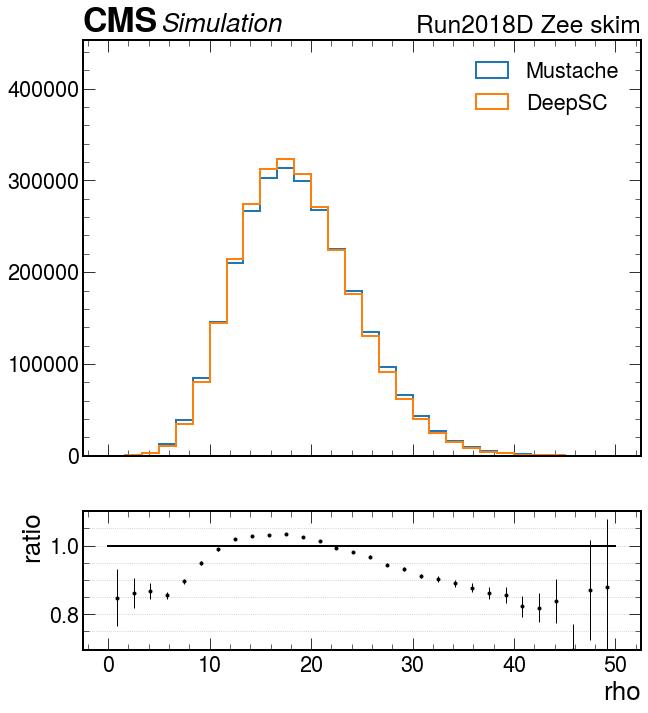

In [170]:
plot_comparison(Zm.rho,Zd.rho, var=f"rho", output_folder=output_folder,
                  bins=30, xrange=(0,50), label="rho" , wA= np.ones(len(Zd.rho))*D_ov_M)

# Category by R9

/tmp/ipykernel_12955/3951626944.py:39: RuntimeWarning: divide by zero encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_12955/3951626944.py:39: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_12955/3951626944.py:39: RuntimeWarning: invalid value encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_12955/3951626944.py:42: RuntimeWarning: invalid value encountered in true_divide
  A/B,


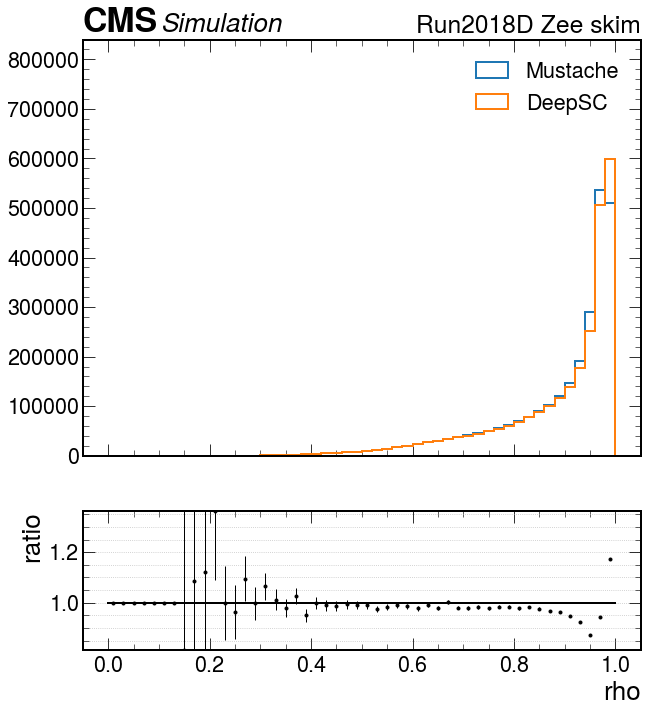

In [195]:
plot_comparison(Zm.r9,Zd.r9, var=f"R9", output_folder=output_folder,
                  bins=50, xrange=(0,1), label="rho" , wA= np.ones(len(Zd.r9))*D_ov_M)

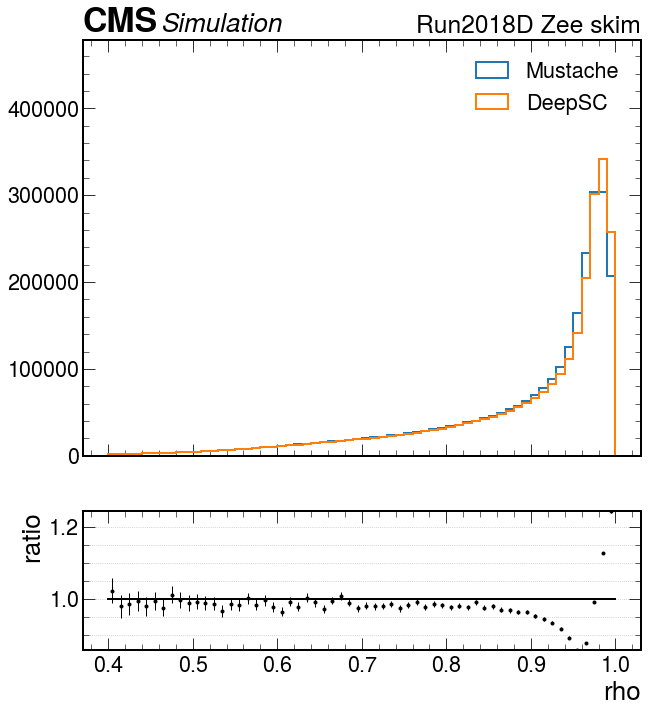

In [196]:
plot_comparison(Zm.r9,Zd.r9, var=f"R9", output_folder=output_folder,
                  bins=60, xrange=(0.4,1), label="rho" , wA= np.ones(len(Zd.r9))*D_ov_M)

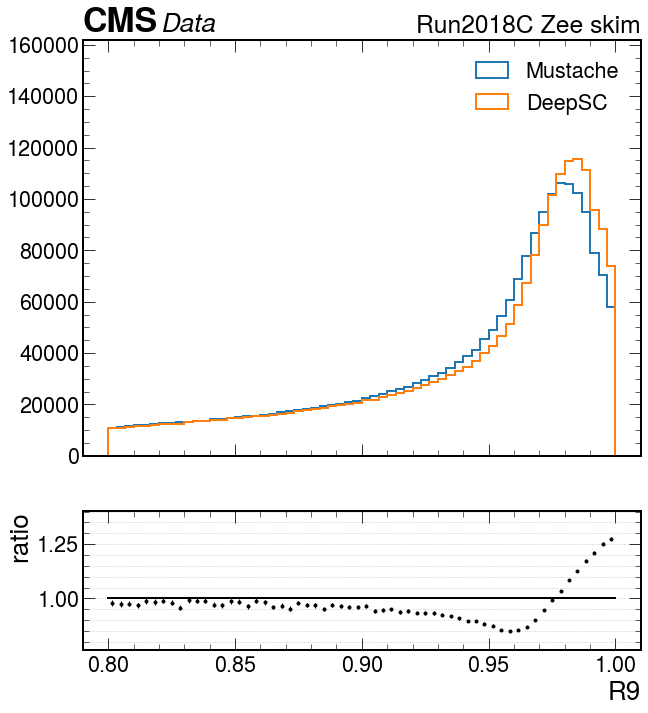

In [202]:
plot_comparison(Zm.r9,Zd.r9, var=f"R9", output_folder=output_folder,
                  bins=60, xrange=(0.8,1), label="R9" , wA= np.ones(len(Zd.r9))*D_ov_M)

In [207]:
Hd = Zd[Zd.r9<0.95].mass

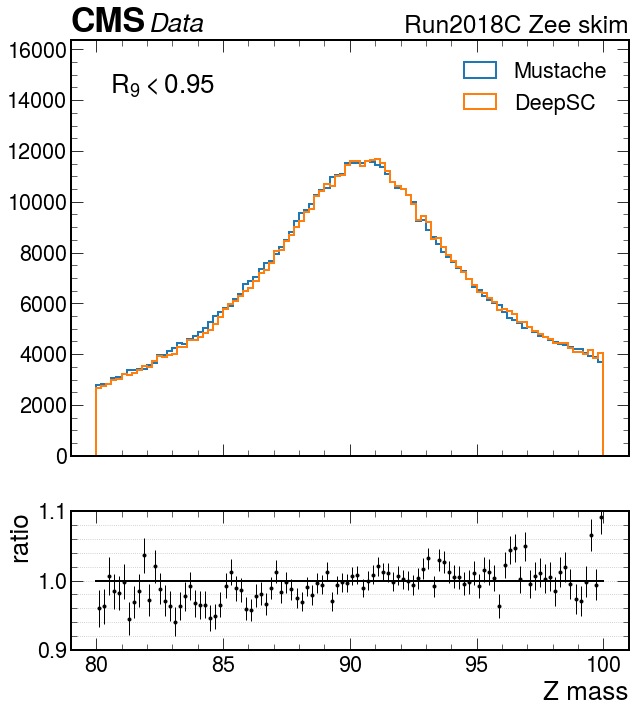

In [225]:
Hm = Zm[Zm.r9<0.95].mass
Hd = Zd[Zd.r9<0.95].mass

norm = np.sum(Hm)/ np.sum(Hd)

plot_comparison(Hm,Hd,
                var=f"Z_mass_r9_0_0.95", 
                output_folder=output_folder,
                bins=100, xrange=(80,100), label="Z mass",
               wA= np.ones(len(Hd))*norm  ,  text="$R_9 < 0.95$",
               ratio_lim=(0.9,1.1))


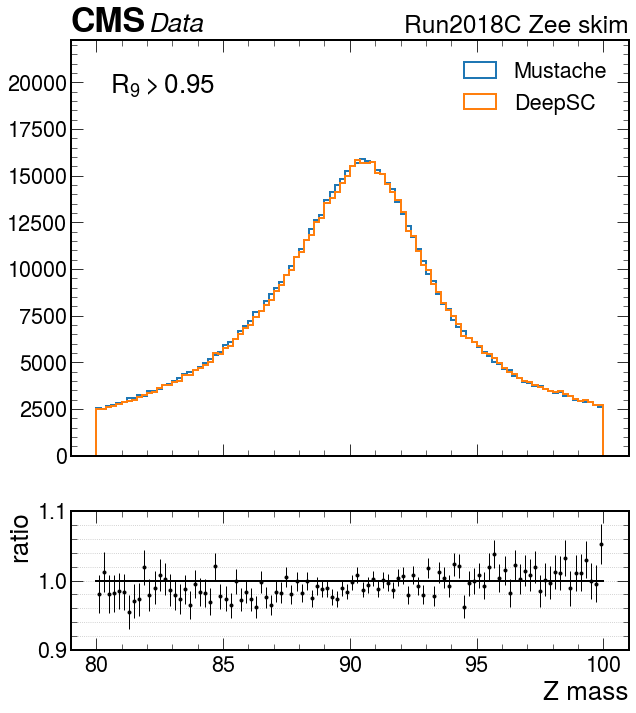

In [226]:
Hm = Zm[Zm.r9>0.95].mass
Hd = Zd[Zd.r9>0.95].mass

norm = np.sum(Hm)/ np.sum(Hd)

plot_comparison(Hm,Hd,
                var=f"Z_mass_r9_0.95_1", 
                output_folder=output_folder,
                bins=100, xrange=(80,100), label="Z mass",
               wA= np.ones(len(Hd))*norm,
               text="$R_9 > 0.95$", ratio_lim=(0.9,1.1))


### Cut in nvtx

In [233]:
np.quantile(Zm.nvtx, 0.7)

30.0

In [239]:
v = 25
q = np.sum(Zm.nvtx>v)/ len(Zm)
print(q)

0.5187907299887301


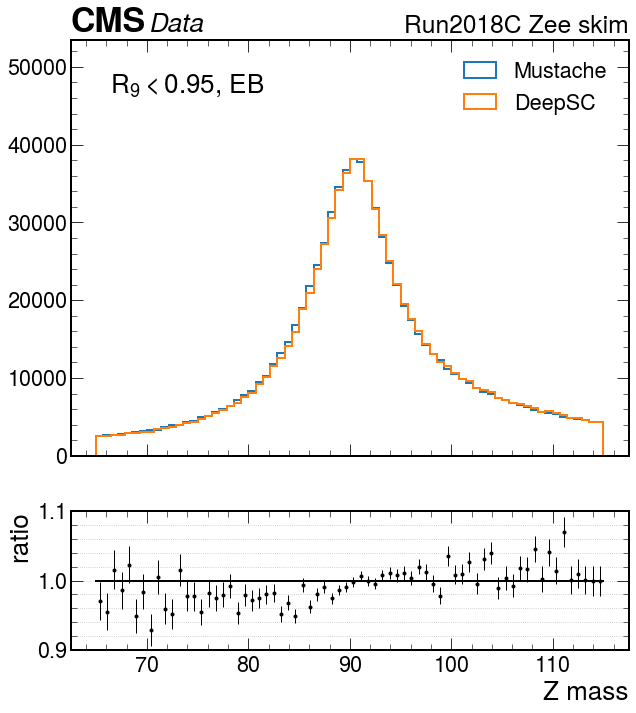

In [278]:
Hm = Zm[(Zm.r9<0.95)&(Zm.ele_et<100)&(abs(Zm.ele_eta)<1.442)].mass
Hd = Zd[(Zd.r9<0.95)&(Zd.ele_et<100)&(abs(Zd.ele_eta)<1.442)].mass

norm = np.sum(Hm)/ np.sum(Hd)

plot_comparison(Hm,Hd,
                var=f"Z_mass_r9_0_0.95_EB", 
                output_folder=output_folder,
                bins=70, xrange=(65,115), label="Z mass",
               wA= np.ones(len(Hd))*norm  ,  text="$R_9 < 0.95$, EB",
               ratio_lim=(0.9,1.1))


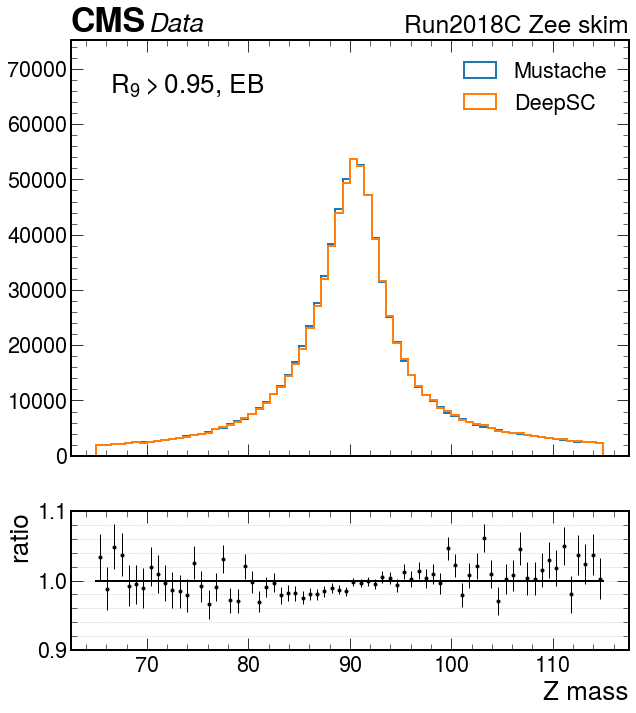

In [279]:
Hm = Zm[(Zm.r9>0.95)&(Zm.ele_et<100)&(abs(Zm.ele_eta)<1.442)].mass
Hd = Zd[(Zd.r9>0.95)&(Zd.ele_et<100)&(abs(Zd.ele_eta)<1.442)].mass

norm = np.sum(Hm)/ np.sum(Hd)

plot_comparison(Hm,Hd,
                var=f"Z_mass_r9_gr0.95_EB", 
                output_folder=output_folder,
                bins=70, xrange=(65,115), label="Z mass",
               wA= np.ones(len(Hd))*norm  ,  text="$R_9 > 0.95$, EB",
               ratio_lim=(0.9,1.1))


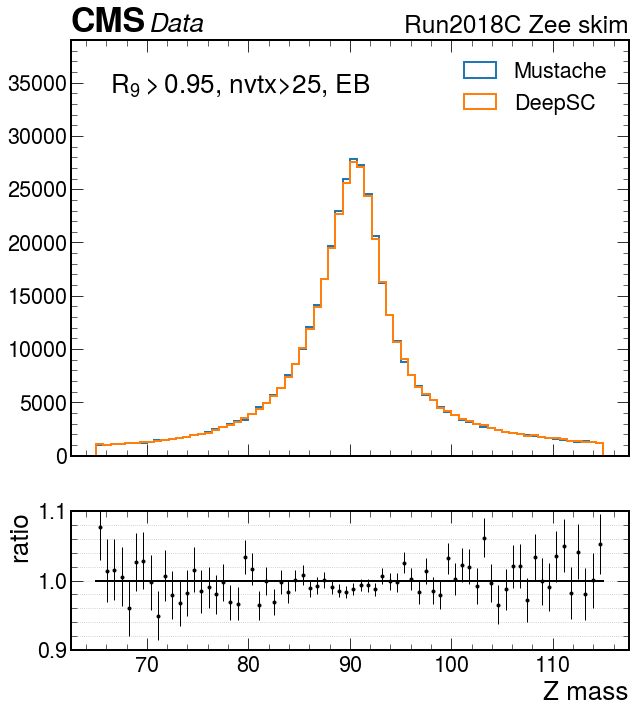

In [281]:
Hm = Zm[(Zm.r9>0.95)&(Zm.ele_et<100)&(abs(Zm.ele_eta)<1.442)*(Zm.nvtx>25)].mass
Hd = Zd[(Zd.r9>0.95)&(Zd.ele_et<100)&(abs(Zd.ele_eta)<1.442)*(Zd.nvtx>25)].mass

norm = np.sum(Hm)/ np.sum(Hd)

plot_comparison(Hm,Hd,
                var=f"Z_mass_r9_gr0.95_EB", 
                output_folder=output_folder,
                bins=70, xrange=(65,115), label="Z mass",
               wA= np.ones(len(Hd))*norm  ,  text="$R_9 > 0.95$, nvtx>25, EB",
               ratio_lim=(0.9,1.1))


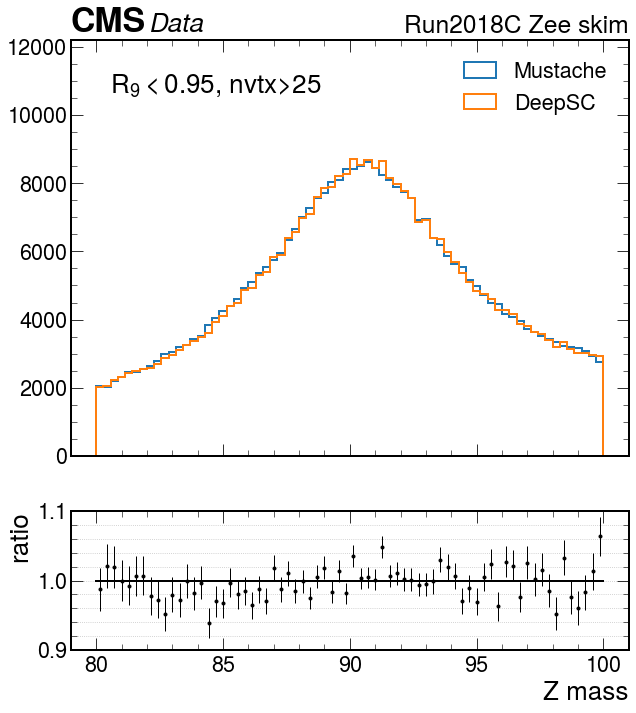

In [259]:
Hm = Zm[(Zm.r9<0.95)&(Zm.nvtx>25)&(Zm.ele_et<100)].mass
Hd = Zd[(Zd.r9<0.95)&(Zd.nvtx>25)&(Zd.ele_et<100)].mass

norm = np.sum(Hm)/ np.sum(Hd)

plot_comparison(Hm,Hd,
                var=f"Z_mass_r9_0_0.95_nvtx25", 
                output_folder=output_foalder,
                bins=70, xrange=(80,100), label="Z mass",
               wA= np.ones(len(Hd))*norm  ,  text="$R_9 < 0.95$, nvtx>25",
               ratio_lim=(0.9,1.1))


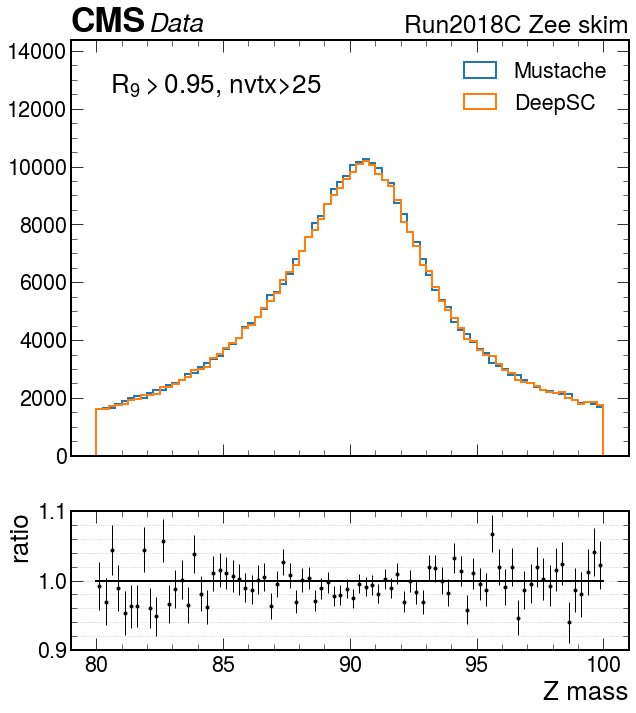

In [258]:
Hm = Zm[(Zm.r9>0.95)&(Zm.nvtx>25)&(Zm.ele_et<100)].mass
Hd = Zd[(Zd.r9>0.95)&(Zd.nvtx>25)&(Zd.ele_et<100)].mass

norm = np.sum(Hm)/ np.sum(Hd)

plot_comparison(Hm,Hd,
                var=f"Z_mass_r9_0.95_1_nvtx25", 
                output_folder=output_folder,
                bins=80, xrange=(80,100), label="Z mass",
               wA= np.ones(len(Hd))*norm  ,  text="$R_9 > 0.95$, nvtx>25",
               ratio_lim=(0.9,1.1))


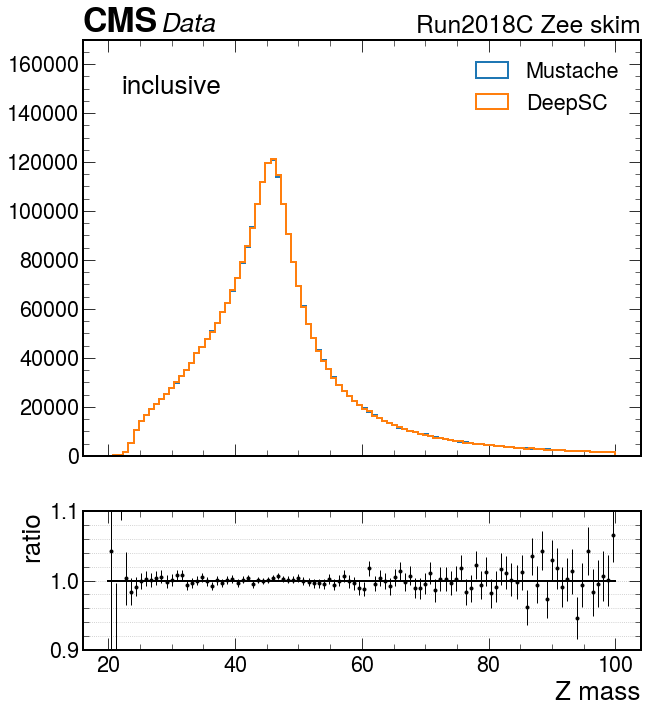

In [252]:
Hm = Zm.ele_et
Hd = Zd.ele_et

norm = np.sum(Hm)/ np.sum(Hd)

plot_comparison(Hm,Hd,
                var=f"ele_pt", 
                output_folder=output_folder,
                bins=100, xrange=(20,100), label="Z mass",
               wA= np.ones(len(Hd))*norm  ,  text="inclusive",
               ratio_lim=(0.9,1.1))


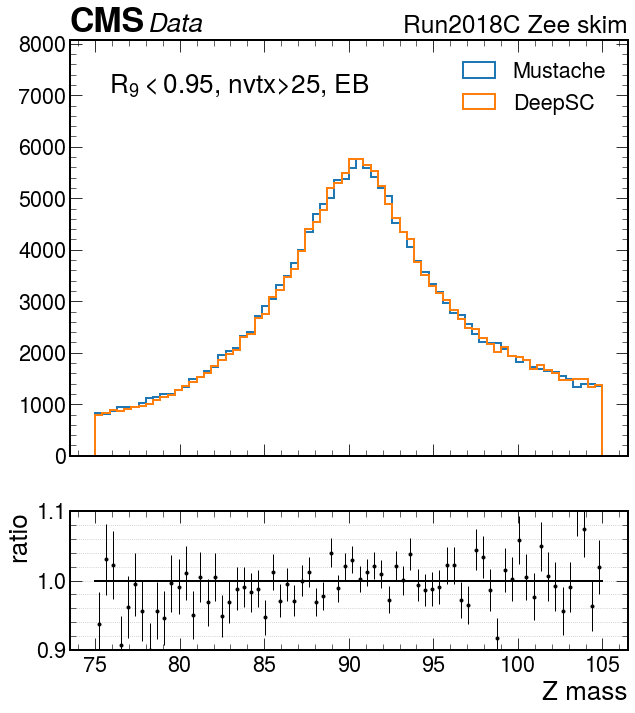

In [269]:
Hm = Zm[(Zm.r9<0.85)&(Zm.nvtx>25)&(Zm.ele_et<100)&(abs(Zm.ele_eta)<1.442)].mass
Hd = Zd[(Zd.r9<0.85)&(Zd.nvtx>25)&(Zd.ele_et<100)&(abs(Zd.ele_eta)<1.442)].mass

norm = np.sum(Hm)/ np.sum(Hd)

plot_comparison(Hm,Hd,
                var=f"Z_mass_r9_0_0.95_nvtx25_EB", 
                output_folder=output_folder,
                bins=70, xrange=(75,105), label="Z mass",
               wA= np.ones(len(Hd))*norm  ,  text="$R_9 < 0.95$, nvtx>25, EB",
               ratio_lim=(0.9,1.1))


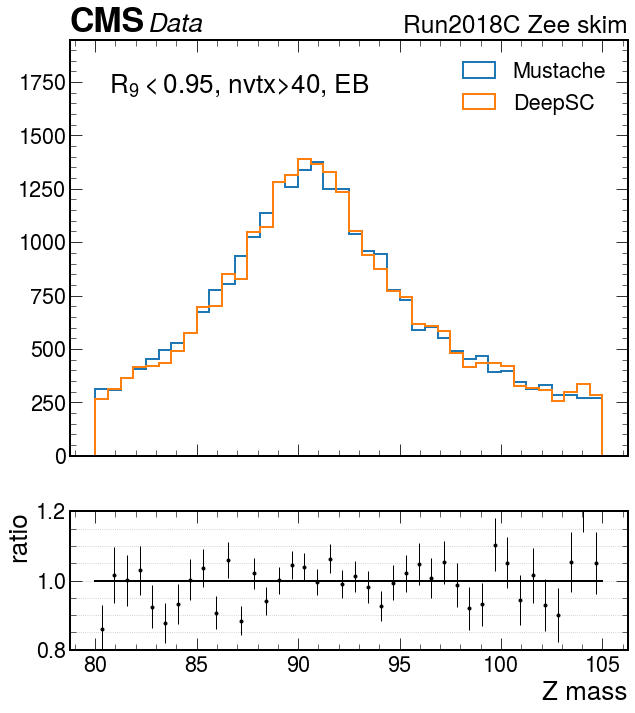

In [277]:
Hm = Zm[(Zm.r9<0.95)&(Zm.nvtx>40)&(Zm.ele_et<100)&(abs(Zm.ele_eta)<1.442)].mass
Hd = Zd[(Zd.r9<0.95)&(Zd.nvtx>40)&(Zd.ele_et<100)&(abs(Zd.ele_eta)<1.442)].mass

norm = np.sum(Hm)/ np.sum(Hd)

plot_comparison(Hm,Hd,
                var=f"Z_mass_r9_0_0.95_nvtx40_EB", 
                output_folder=output_folder,
                bins=40, xrange=(80,105), label="Z mass",
               wA= np.ones(len(Hd))*norm  ,  text="$R_9 < 0.95$, nvtx>40, EB",
               ratio_lim=(0.8,1.2))


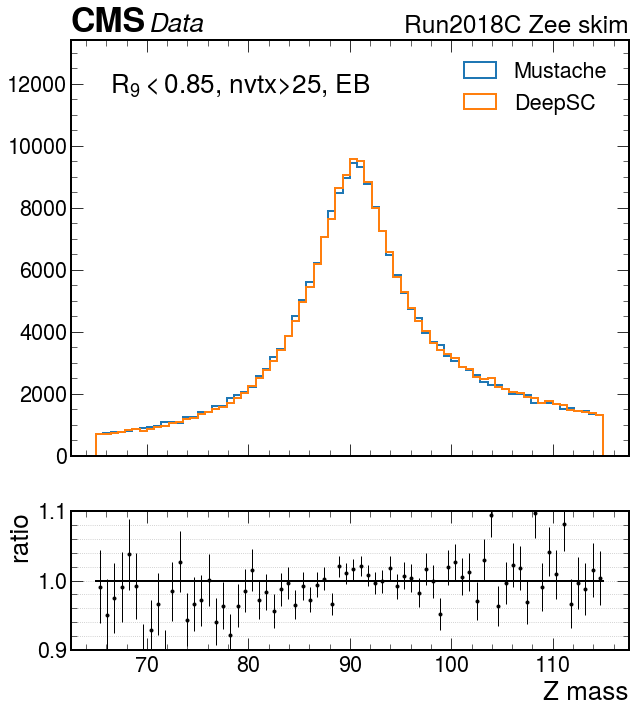

In [273]:
Hm = Zm[(Zm.r9<0.85)&(Zm.nvtx>25)&(Zm.ele_et<100)&(abs(Zm.ele_eta)<1.442)].mass
Hd = Zd[(Zd.r9<0.85)&(Zd.nvtx>25)&(Zd.ele_et<100)&(abs(Zd.ele_eta)<1.442)].mass

norm = np.sum(Hm)/ np.sum(Hd)

plot_comparison(Hm,Hd,
                var=f"Z_mass_r9_0_0.95_nvtx25_EB", 
                output_folder=output_folder,
                bins=70, xrange=(65,115), label="Z mass",
               wA= np.ones(len(Hd))*norm  ,  text="$R_9 < 0.85$, nvtx>25, EB",
               ratio_lim=(0.9,1.1))


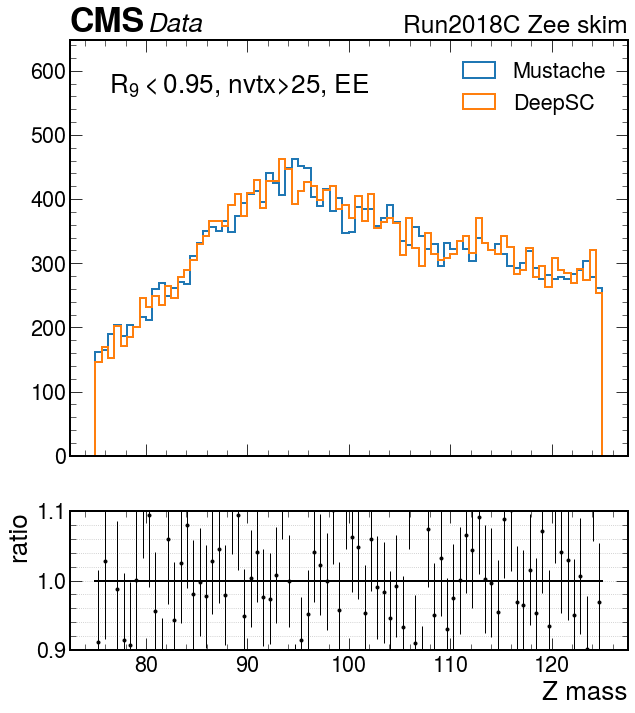

In [268]:
Hm = Zm[(Zm.r9<0.85)&(Zm.nvtx>25)&(Zm.ele_et<100)&(abs(Zm.ele_eta)>1.556)].mass
Hd = Zd[(Zd.r9<0.85)&(Zd.nvtx>25)&(Zd.ele_et<100)&(abs(Zd.ele_eta)>1.556)].mass

norm = np.sum(Hm)/ np.sum(Hd)

plot_comparison(Hm,Hd,
                var=f"Z_mass_r9_0_0.95_nvtx25_EE", 
                output_folder=output_folder,
                bins=80, xrange=(75,125), label="Z mass",
               wA= np.ones(len(Hd))*norm  ,  text="$R_9 < 0.95$, nvtx>25, EE",
               ratio_lim=(0.9,1.1))


# Sigma E

In [ ]:
Hm = Zm[(Zm.r9<0.85)&(Zm.nvtx>25)&(Zm.ele_et<100)&(abs(Zm.ele_eta)>1.556)].mass
Hd = Zd[(Zd.r9<0.85)&(Zd.nvtx>25)&(Zd.ele_et<100)&(abs(Zd.ele_eta)>1.556)].mass

norm = np.sum(Hm)/ np.sum(Hd)

plot_comparison(Hm,Hd,
                var=f"Z_mass_r9_0_0.95_nvtx25_EE", 
                output_folder=output_folder,
                bins=80, xrange=(75,125), label="Z mass",
               wA= np.ones(len(Hd))*norm  ,  text="$R_9 < 0.95$, nvtx>25, EE",
               ratio_lim=(0.9,1.1))


# Matching obj to obj

In [9]:
df_ev = Zd.join(Zm.set_index(["eventId", "lumiId", "runId"]),
             on=["eventId", "lumiId", "runId"], how="inner", lsuffix="_d", rsuffix="_m")

In [10]:
len(df_ev)

2762458

In [6]:
df = Zd.join(Zm.set_index(["eventId", "lumiId", "runId", "seedid1", "seedid2"]),
             on=["eventId", "lumiId", "runId", "seedid1", "seedid2"], how="inner", lsuffix="_d", rsuffix="_m")

In [12]:
len(df)

2712219

In [13]:
len(df)/len(df_ev)

0.9818136601533851

B: 2712219.0
A. 2712219.0


<ipython-input-2-d52c1d4c16a5>:49: RuntimeWarning: divide by zero encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-2-d52c1d4c16a5>:49: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-2-d52c1d4c16a5>:49: RuntimeWarning: invalid value encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-2-d52c1d4c16a5>:52: RuntimeWarning: invalid value encountered in divide
  A/B,


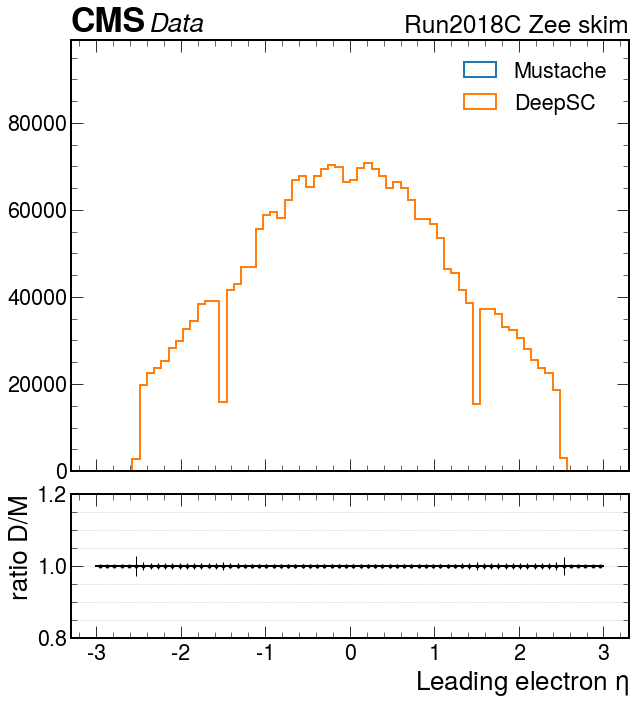

In [14]:
plot_comparison(df.ele_eta_m, df.ele_eta_d,
                var=f"ele_eta", 
                output_folder=output_folder,
                bins=70, xrange=(-3,3), label="Leading electron $\eta$",
                )

B: 2105629.0
A. 2105665.0


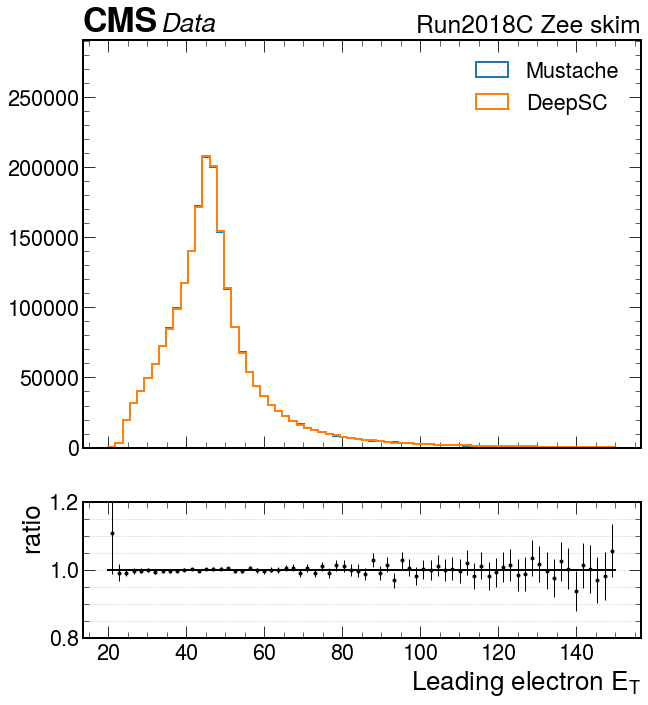

In [16]:
plot_comparison(df.ele_et_m, df.ele_et_d,
                var=f"ele_et", 
                output_folder=output_folder,
                bins=70, xrange=(20,150), label="Leading electron $E_T$",
                )

Text(0, 1, 'Ele $\\eta$ Mustache')

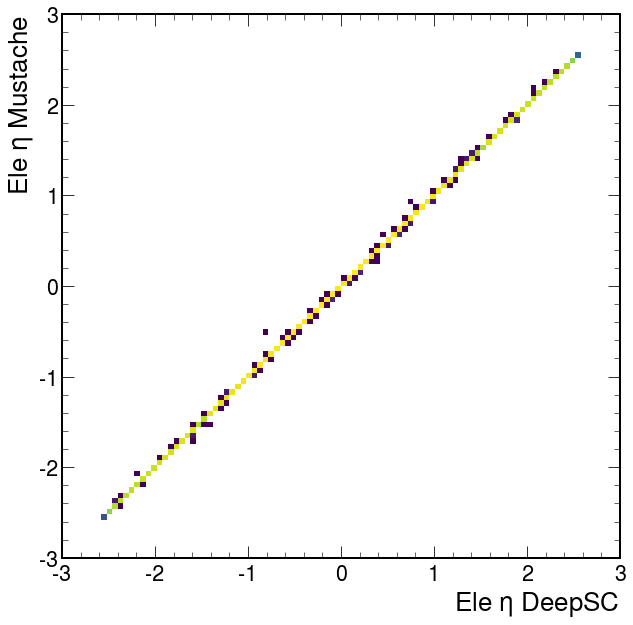

In [25]:
plt.hist2d(df.ele_eta_d, df.ele_eta_m, bins=100, range=((-3,3),(-3,3)), norm=LogNorm())
plt.xlabel("Ele $\eta$ DeepSC")
plt.ylabel("Ele $\eta$ Mustache")

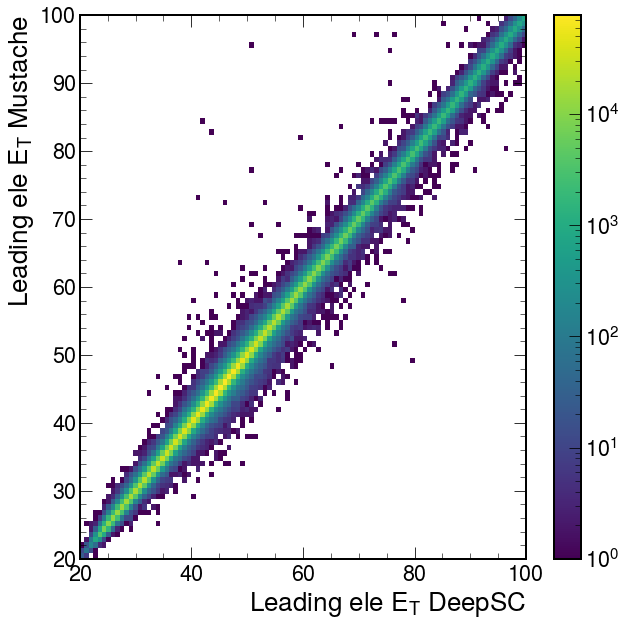

In [94]:
plt.hist2d(df.ele_et_d, df.ele_et_m, bins=100, range=((20,100),(20,100)), norm=LogNorm())
plt.xlabel("Leading ele $E_T$ DeepSC")
plt.ylabel("Leading ele $E_T$ Mustache")
plt.colorbar()

Text(0, 1, 'Z mass Mustache')

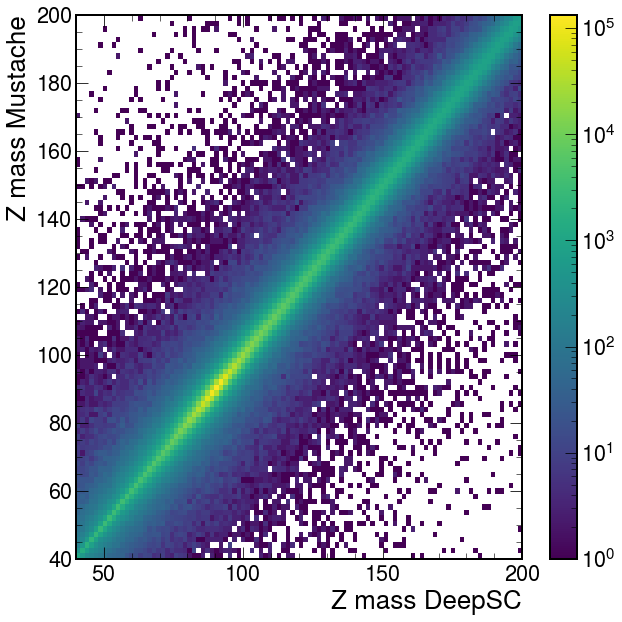

In [112]:
plt.hist2d(df.mass_d, df.mass_m, bins=100, range=((40,200),(40,200)), norm=LogNorm())
plt.colorbar()
plt.xlabel("Z mass DeepSC")
plt.ylabel("Z mass Mustache")

In [68]:
df.sigmaietaieta_m

0          0.009876
1          0.009311
2          0.009578
3          0.010274
4          0.008999
             ...   
2259416    0.008937
2259417    0.024422
2259418    0.026379
2259419    0.009358
2259420    0.009305
Name: sigmaietaieta_m, Length: 2112907, dtype: float32

### Iso and width variables

<ipython-input-30-be3926a7de82>:45: RuntimeWarning: divide by zero encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-30-be3926a7de82>:45: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-30-be3926a7de82>:45: RuntimeWarning: invalid value encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-30-be3926a7de82>:48: RuntimeWarning: invalid value encountered in true_divide
  A/B,


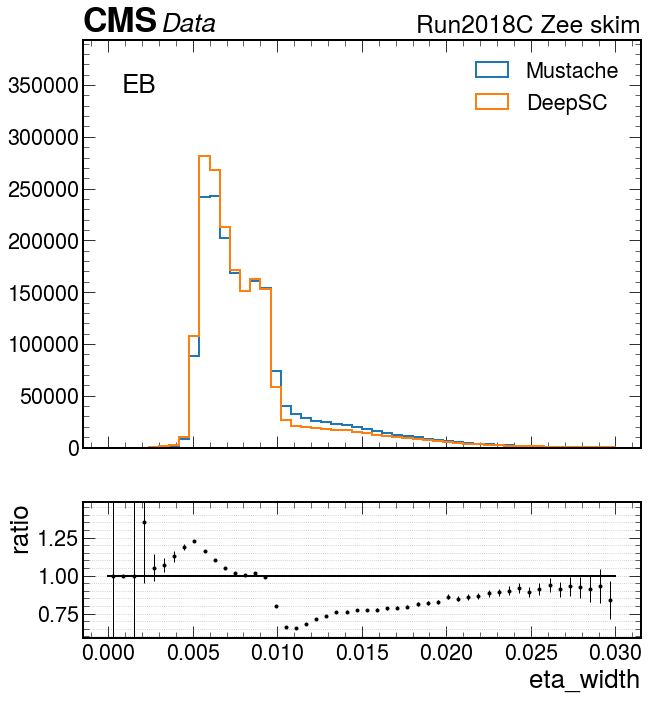

In [100]:
df_cut = df[abs(df.ele_eta_m<1.4452)]

plot_comparison(df_cut.etawidth_m,df_cut.etawidth_d, var="$\eta$ width", 
                output_folder=output_folder,
                 bins=50, xrange=(0,0.03), label="eta_width",
                text="EB",
               ratio_lim="auto")

B: 348190.0
A. 348219.0


<ipython-input-2-d52c1d4c16a5>:49: RuntimeWarning: divide by zero encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-2-d52c1d4c16a5>:49: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-2-d52c1d4c16a5>:49: RuntimeWarning: invalid value encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-2-d52c1d4c16a5>:52: RuntimeWarning: invalid value encountered in divide
  A/B,


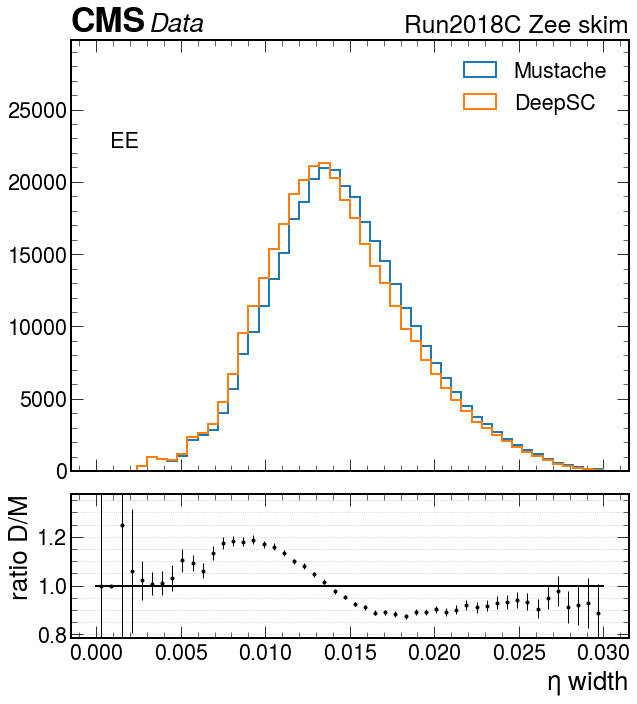

In [93]:
df_cut = df[abs(df.ele_eta_m>1.4452)]

plot_comparison(df_cut.etawidth_m,df_cut.etawidth_d, var="eta_width", 
                output_folder=output_folder,
                 bins=50, xrange=(0,0.03), label="$\eta$ width",
                text="EE",
               ratio_lim="auto")

<ipython-input-30-be3926a7de82>:45: RuntimeWarning: divide by zero encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-30-be3926a7de82>:45: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-30-be3926a7de82>:45: RuntimeWarning: invalid value encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-30-be3926a7de82>:48: RuntimeWarning: invalid value encountered in true_divide
  A/B,


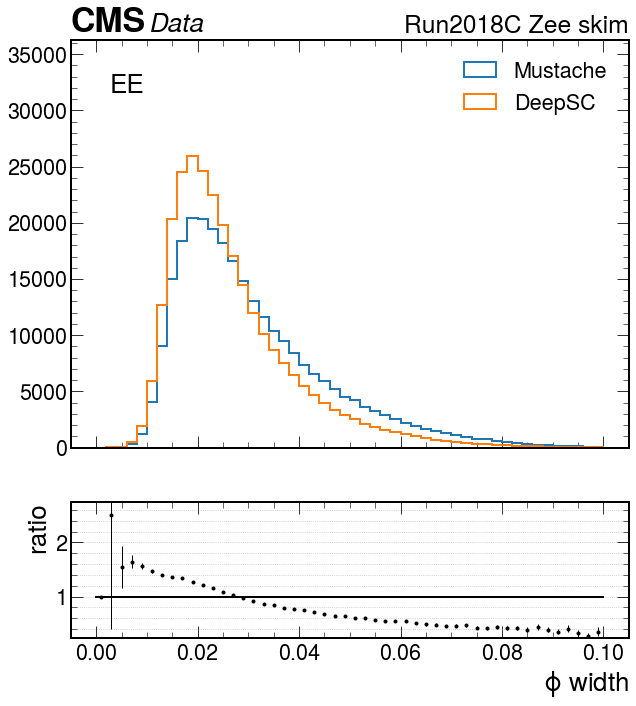

In [102]:
df_cut = df[abs(df.ele_eta_m>1.4452)]

plot_comparison(df_cut.phiwidth_m,df_cut.phiwidth_d, var="phi_width", 
                output_folder=output_folder,
                 bins=50, xrange=(0,0.1), label="$\phi$ width",
                text="EE",
               ratio_lim="auto")

<ipython-input-30-be3926a7de82>:45: RuntimeWarning: divide by zero encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-30-be3926a7de82>:45: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-30-be3926a7de82>:45: RuntimeWarning: invalid value encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-30-be3926a7de82>:48: RuntimeWarning: invalid value encountered in true_divide
  A/B,


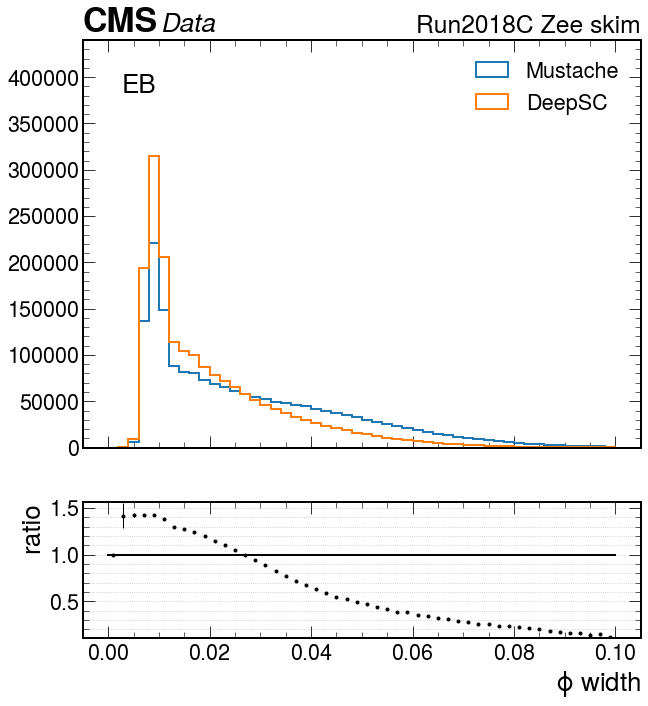

In [103]:
df_cut = df[abs(df.ele_eta_m<1.4452)]

plot_comparison(df_cut.phiwidth_m,df_cut.phiwidth_d, var="phi_width", 
                output_folder=output_folder,
                 bins=50, xrange=(0,0.1), label="$\phi$ width",
                text="EB",
               ratio_lim="auto")

In [ ]:
df_cut = df[abs(df.ele_eta_m<1.4452)]

plot_comparison(df_cut.ecaliso_m,df_cut.ecaliso_d, var="ecaliso", 
                output_folder=output_folder,
                 bins=50, xrange=(0,15), label="Ecal Iso",
                text="EB",
               ratio_lim="auto")

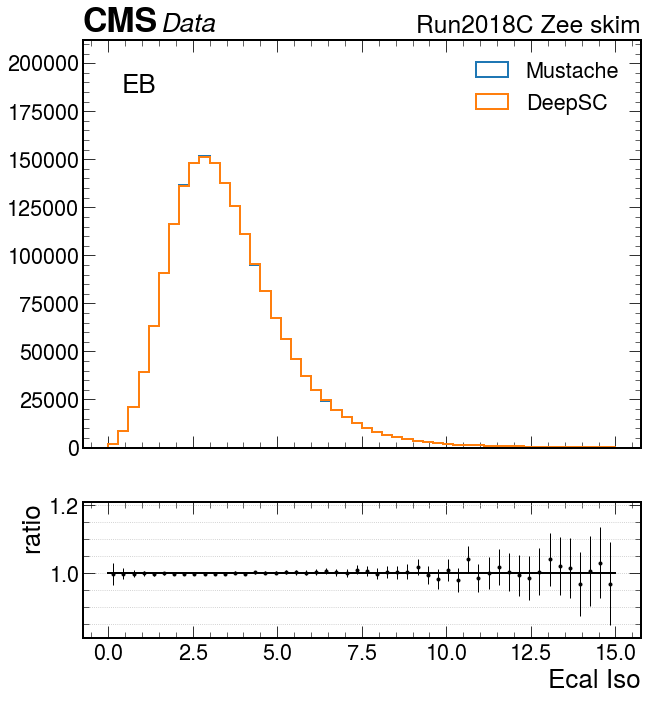

In [106]:
df_cut = df[abs(df.ele_eta_m<1.4452)]

plot_comparison(df_cut.ecaliso_m,df_cut.ecaliso_d, var="ecaliso", 
                output_folder=output_folder,
                 bins=50, xrange=(0,15), label="Ecal Iso",
                text="EB",
               ratio_lim="auto")

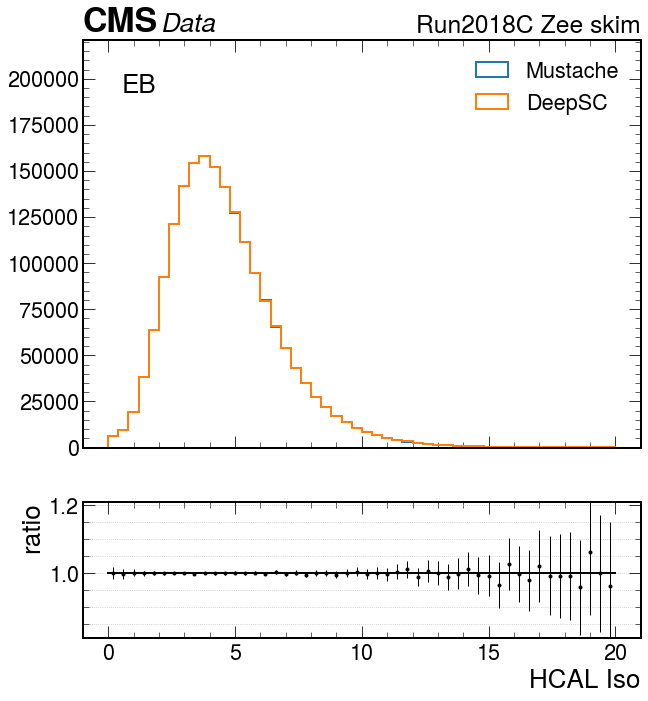

In [115]:
df_cut = df[abs(df.ele_eta_m<1.4452)]

plot_comparison(df_cut.hcaliso_m,df_cut.hcaliso_d, var="ecaliso", 
                output_folder=output_folder,
                 bins=50, xrange=(0,20), label="HCAL Iso",
                text="EB",
               ratio_lim="auto")

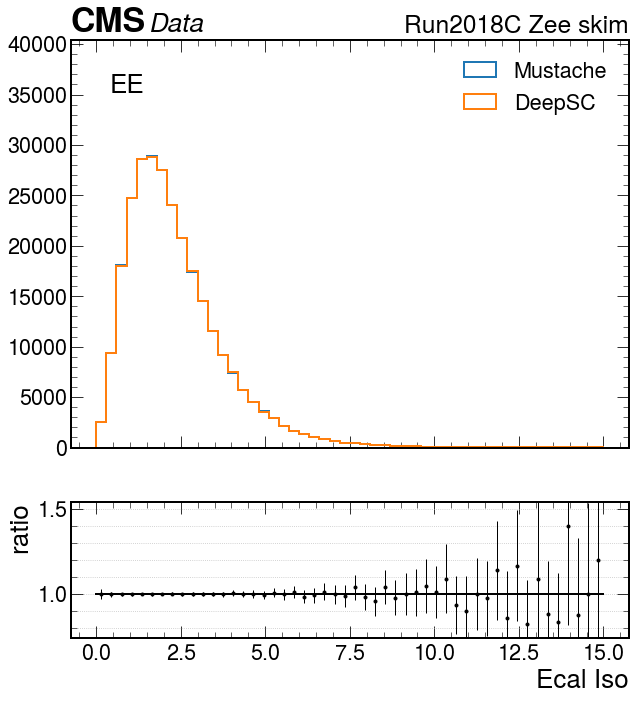

In [111]:
df_cut = df[abs(df.ele_eta_m>1.4452)]

plot_comparison(df_cut.ecaliso_m,df_cut.ecaliso_d, var="ecaliso", 
                output_folder=output_folder,
                 bins=50, xrange=(0,15), label="Ecal Iso",
                text="EE",
               ratio_lim="auto")

### R9

B: 2204077.0
A. 2214190.0


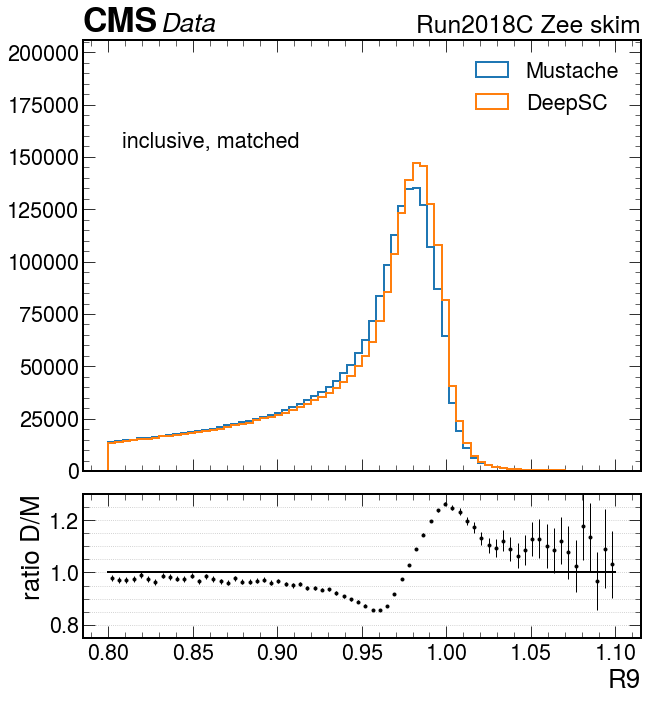

In [96]:
plot_comparison(df.r9_m,df.r9_d, var=f"R9", 
                output_folder=output_folder,
                 bins=70, xrange=(0.8,1.1), label="R9",
                text="inclusive, matched",
               ratio_lim=(0.75, 1.3))

B: 1965362.0
A. 1981195.0


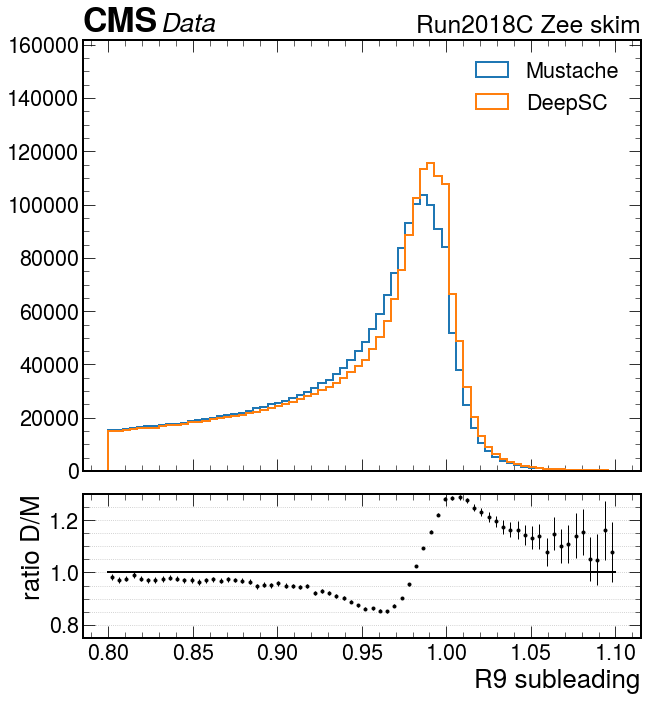

In [85]:
plot_comparison(df.r9_sublead_m,df.r9_sublead_d, var=f"R9", 
                output_folder=output_folder,
                 bins=70, xrange=(0.8,1.1), label="R9 subleading",
               ratio_lim=(0.75, 1.3))

B: 1094465.0
A. 1100324.0


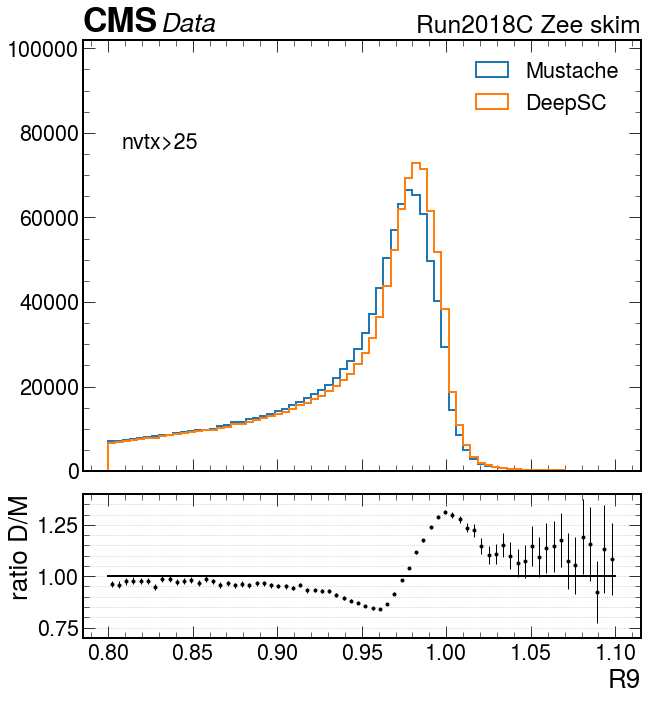

In [19]:
df_cut = df[df.nvtx_m> 25]

plot_comparison(df_cut.r9_m,df_cut.r9_d, var=f"R9", 
                output_folder=output_folder,
                text="nvtx>25",
                 bins=70, xrange=(0.8,1.1), label="R9",
               ratio_lim=(0.7, 1.4))

B: 703803.0
A. 705021.0


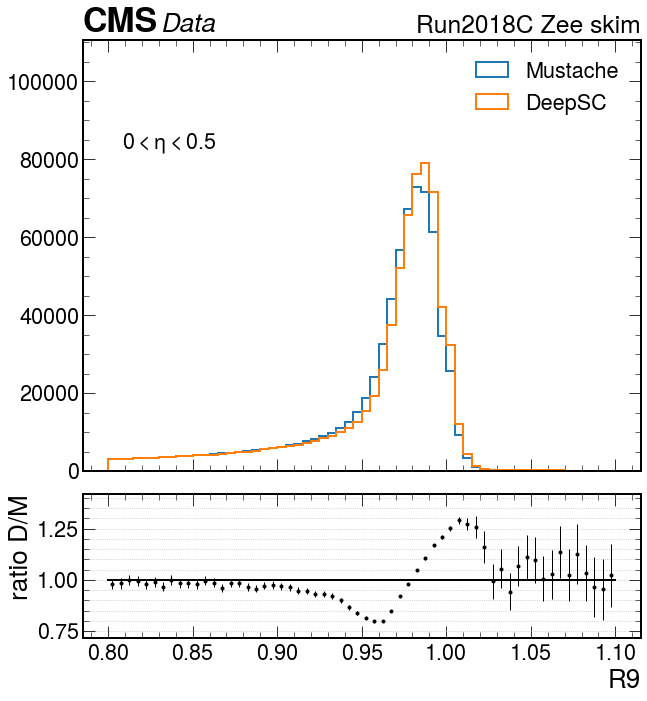

In [97]:
df_cut = df[(abs(df.ele_eta_m)>0.)&(abs(df.ele_eta_m)<0.5)]

plot_comparison(df_cut.r9_m,df_cut.r9_d, var=f"R9", 
                output_folder=output_folder,
                text="$0<\eta<0.5.$",
                 bins=60, xrange=(0.8,1.1), label="R9",
               ratio_lim="auto")

B: 598220.0
A. 600771.0


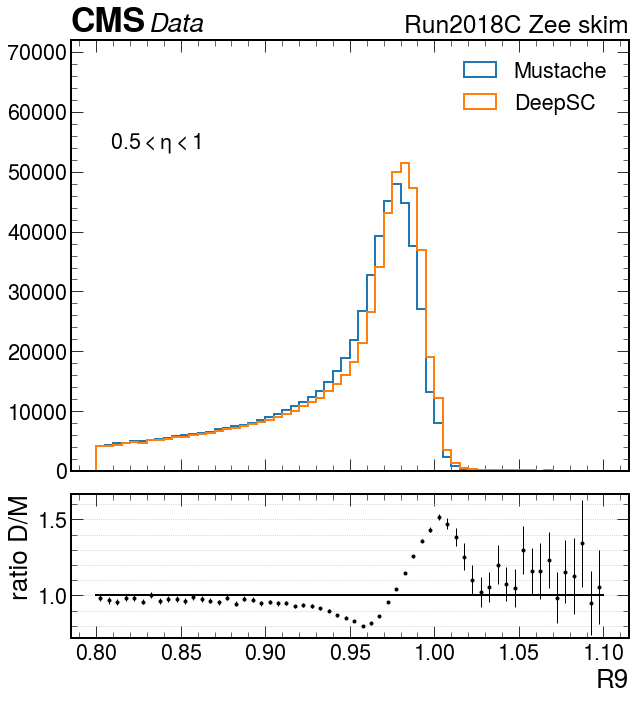

In [98]:
df_cut = df[(abs(df.ele_eta_m)>0.5)&(abs(df.ele_eta_m)<1.0)]

plot_comparison(df_cut.r9_m,df_cut.r9_d, var=f"R9", 
                output_folder=output_folder,
                text="$0.5<\eta<1.$",
                 bins=60, xrange=(0.8,1.1), label="R9",
               ratio_lim="auto")

B: 287407.0
A. 291921.0


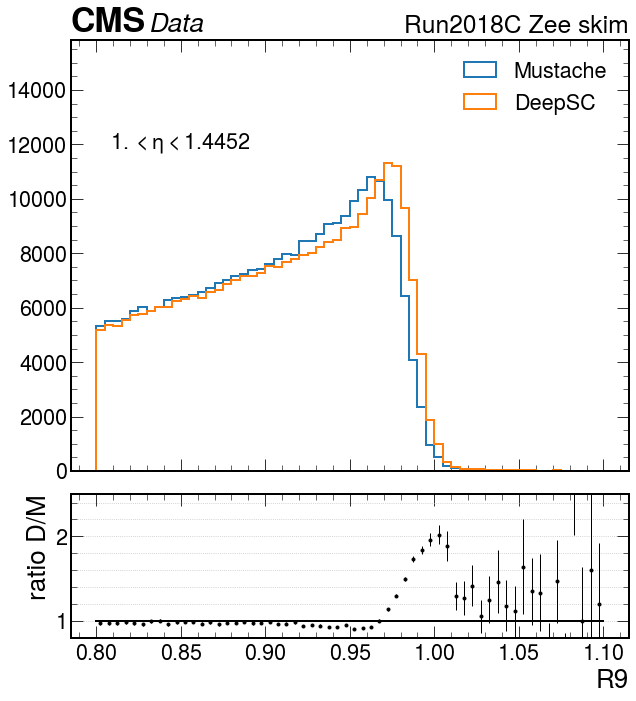

In [110]:
df_cut = df[(abs(df.ele_eta_m)>1.0)&(abs(df.ele_eta_m)<1.4452)]

plot_comparison(df_cut.r9_m,df_cut.r9_d, var=f"R9", 
                output_folder=output_folder,
                text="$1.<\eta<1.4452$",
                 bins=60, xrange=(0.8,1.1), label="R9",
               ratio_lim=(0.8, 2.5))

B: 584804.0
A. 586459.0


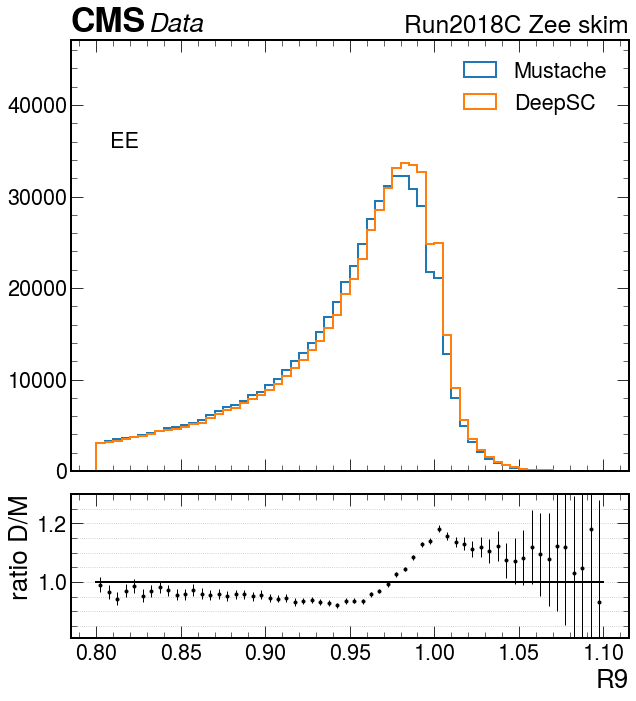

In [102]:
df_cut = df[(abs(df.ele_eta_m)>1.556)&(abs(df.ele_eta_m)<3)]

plot_comparison(df_cut.r9_m,df_cut.r9_d, var=f"R9", 
                output_folder=output_folder,
                text="EE",
                 bins=60, xrange=(0.8,1.1), label="R9",
               ratio_lim="auto")

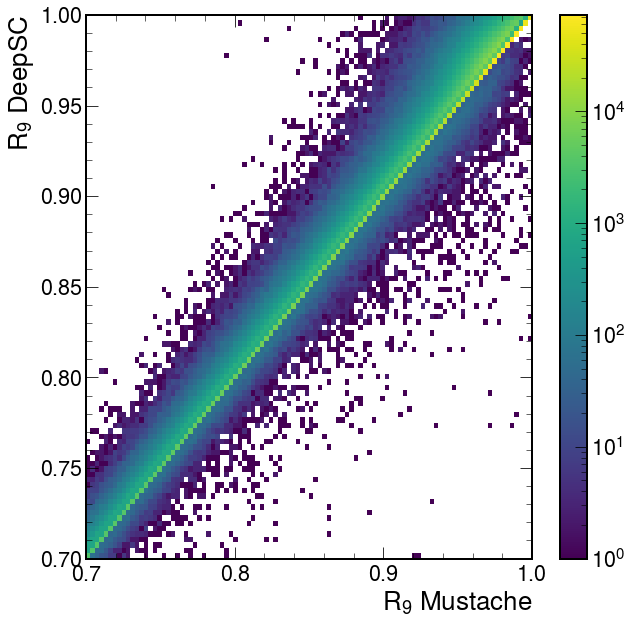

In [24]:
plt.hist2d(df.r9_m, df.r9_d, bins=100, range=((0.7,1),(0.7,1)), norm=LogNorm())
plt.ylabel("$R_9$ DeepSC")
plt.xlabel("$R_9$ Mustache")
plt.colorbar()

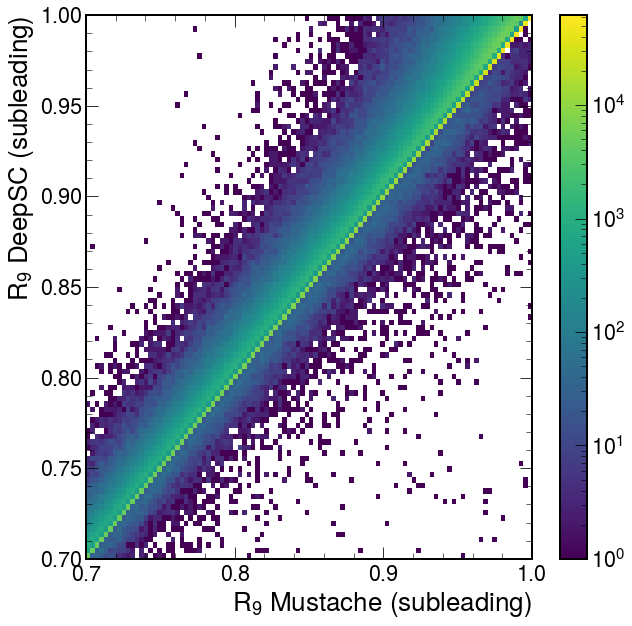

In [81]:
plt.hist2d(df.r9_sublead_m, df.r9_sublead_d, bins=100, range=((0.7,1),(0.7,1)), norm=LogNorm())
plt.ylabel("$R_9$ DeepSC (subleading)")
plt.xlabel("$R_9$ Mustache (subleading)")
plt.colorbar()

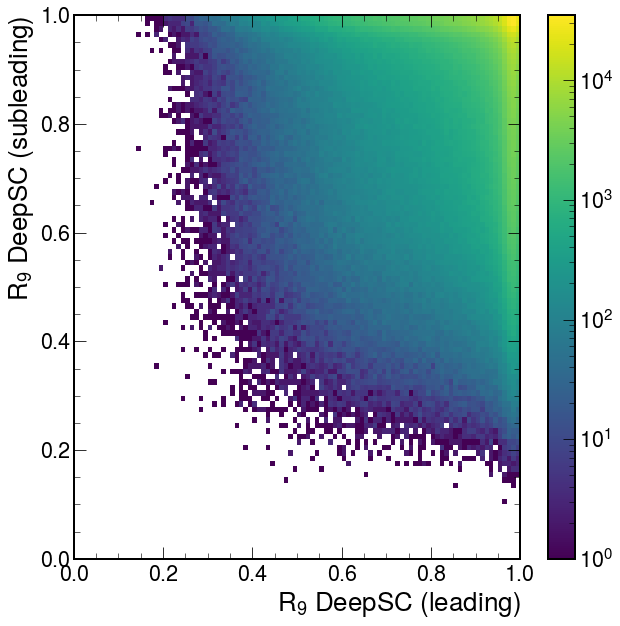

In [89]:
plt.hist2d(df.r9_d, df.r9_sublead_d, bins=100, range=((0.,1),(0.,1)), norm=LogNorm())
plt.xlabel("$R_9$ DeepSC (leading)")
plt.ylabel("$R_9$ DeepSC (subleading)")
plt.colorbar()

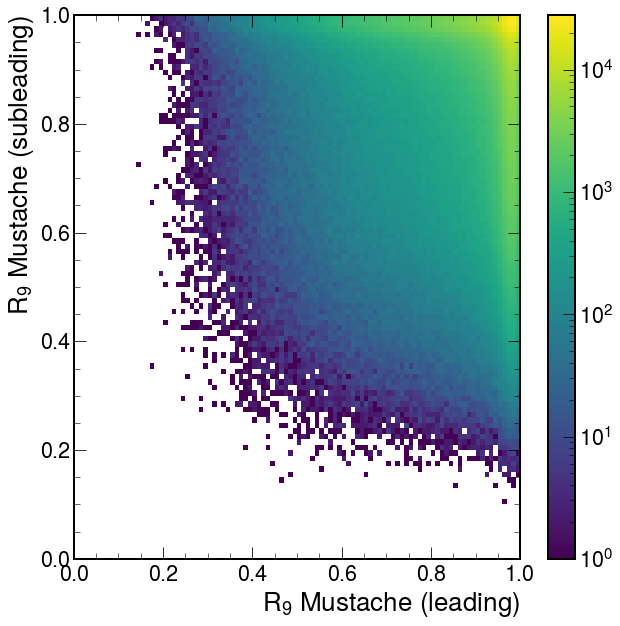

In [90]:
plt.hist2d(df.r9_m, df.r9_sublead_m, bins=100, range=((0.,1),(0.,1)), norm=LogNorm())
plt.xlabel("$R_9$ Mustache (leading)")
plt.ylabel("$R_9$ Mustache (subleading)")
plt.colorbar()

Text(0.1, 0.9, '4th module')

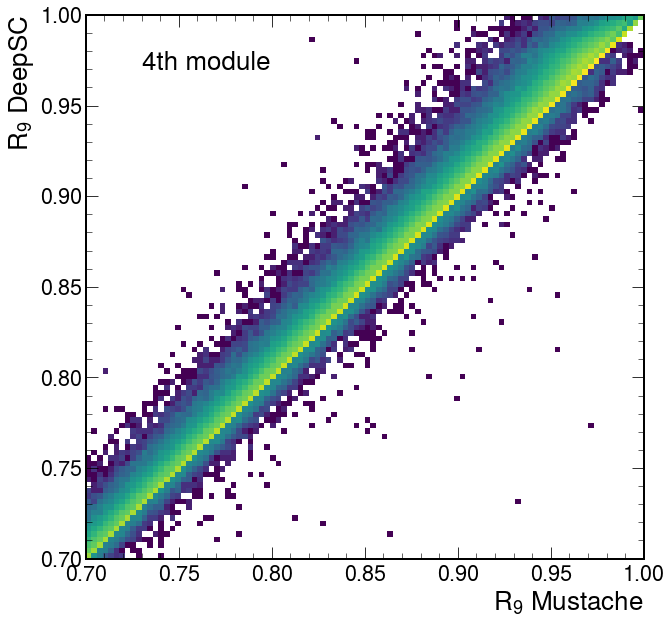

In [26]:
plt.hist2d(df[(abs(df.ele_eta_m)>1.0)&(abs(df.ele_eta_m)<1.4452)].r9_m, 
           df[(abs(df.ele_eta_m)>1.0)&(abs(df.ele_eta_m)<1.4452)].r9_d,
            bins=100, range=((0.7,1),(0.7,1)), norm=LogNorm())
plt.ylabel("$R_9$ DeepSC")
plt.xlabel("$R_9$ Mustache")
plt.text(0.1, 0.9, "4th module", transform=plt.gca().transAxes)

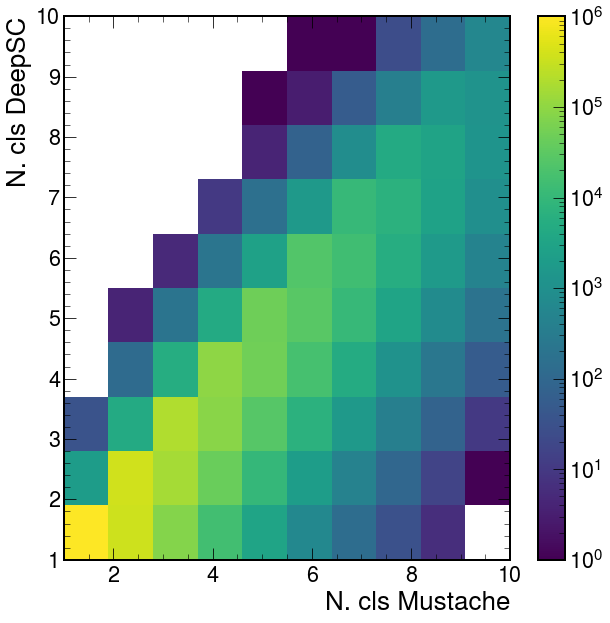

In [27]:
plt.hist2d(df.ncls1_m, df.ncls1_d, bins=(10,10), range=((1,10),(1,10)), norm=LogNorm())
plt.xlabel("N. cls Mustache")
plt.ylabel("N. cls DeepSC")
plt.colorbar()

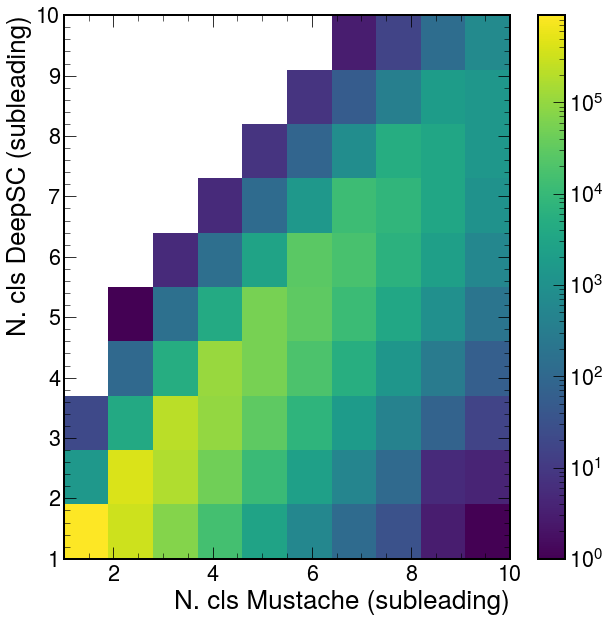

In [28]:
plt.hist2d(df.ncls2_m, df.ncls2_d, bins=(10,10), range=((1,10),(1,10)), norm=LogNorm())
plt.xlabel("N. cls Mustache (subleading)")
plt.ylabel("N. cls DeepSC (subleading)")
plt.colorbar()

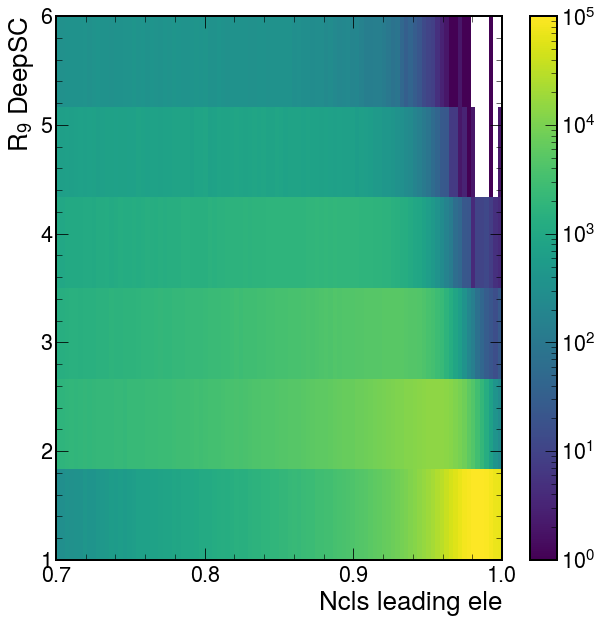

In [30]:
plt.hist2d(df.r9_d, df.ncls1_d, bins=(100, 6), range=((0.7,1),(1,6)), norm=LogNorm())
plt.ylabel("$R_9$ DeepSC")
plt.xlabel("Ncls leading ele")
plt.colorbar()

Text(1, 0, '$R_9$ Mustache')

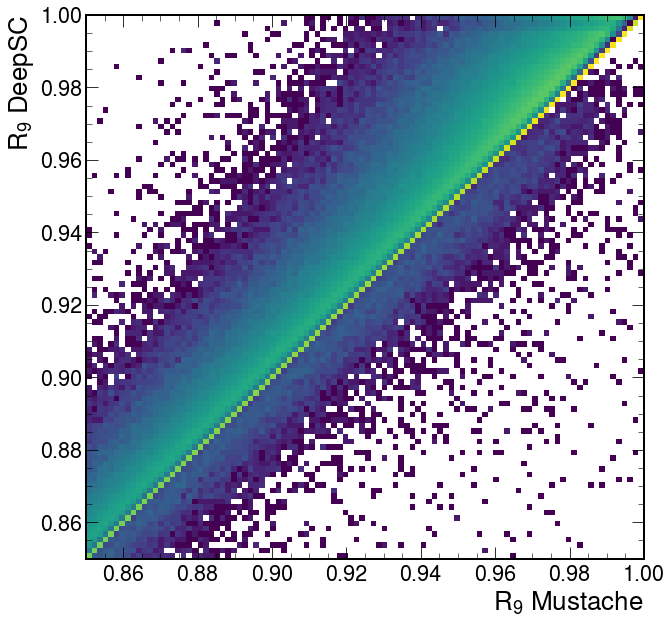

In [31]:
plt.hist2d(df.r9_m, df.r9_d, bins=100, range=((0.85,1),(0.85,1)), norm=LogNorm())
plt.ylabel("$R_9$ DeepSC")
plt.xlabel("$R_9$ Mustache")

B: 2711993.0
A. 2711992.0


<ipython-input-2-d52c1d4c16a5>:49: RuntimeWarning: divide by zero encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-2-d52c1d4c16a5>:49: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-2-d52c1d4c16a5>:49: RuntimeWarning: invalid value encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-2-d52c1d4c16a5>:52: RuntimeWarning: invalid value encountered in divide
  A/B,


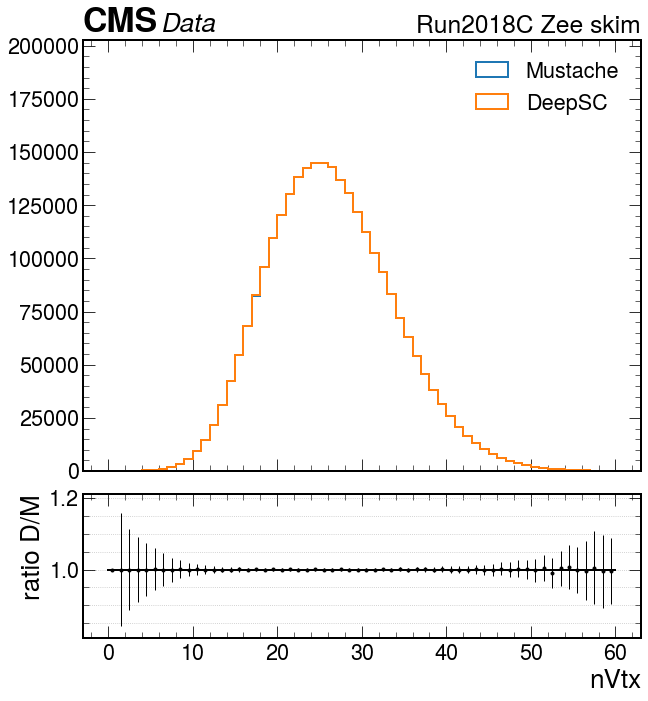

In [123]:
plot_comparison(df.nvtx_m,
                df.nvtx_d,
                var=f"nvtx", 
                output_folder=output_folder,
                 bins=60, xrange=(0,60), label="nVtx",
                text="",
               ratio_lim="auto")

B: 1297684.0
A. 1353326.0


<ipython-input-2-d52c1d4c16a5>:49: RuntimeWarning: divide by zero encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-2-d52c1d4c16a5>:49: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-2-d52c1d4c16a5>:49: RuntimeWarning: invalid value encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-2-d52c1d4c16a5>:52: RuntimeWarning: invalid value encountered in divide
  A/B,


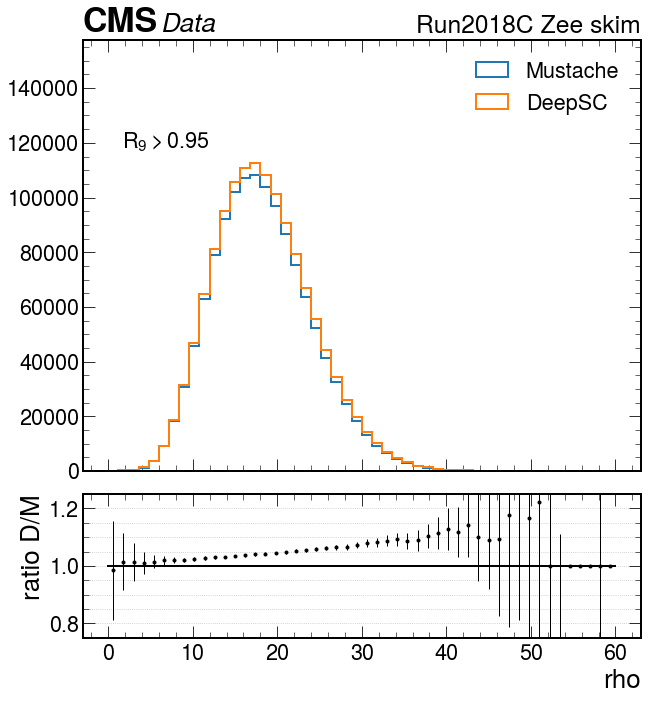

In [32]:
plot_comparison(df[df.r9_m>0.95].rho_m,
                df[df.r9_d>0.95].rho_d,
                var=f"$\rho$", 
                output_folder=output_folder,
                 bins=50, xrange=(0,60), label="rho",
                text="$R_9>0.95$",
               ratio_lim=(0.75, 1.25))

<ipython-input-30-be3926a7de82>:45: RuntimeWarning: divide by zero encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-30-be3926a7de82>:45: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-30-be3926a7de82>:45: RuntimeWarning: invalid value encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-30-be3926a7de82>:48: RuntimeWarning: invalid value encountered in true_divide
  A/B,


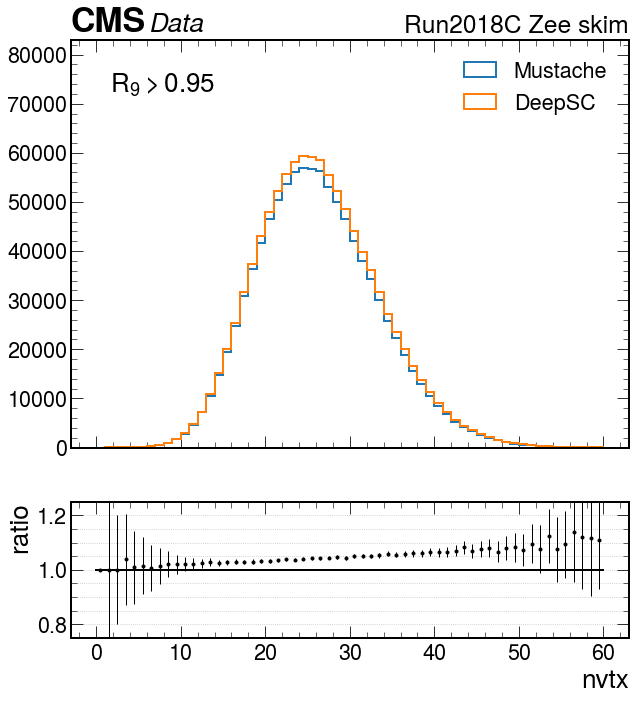

In [156]:
plot_comparison(df[df.r9_m>0.95].nvtx_m,
                df[df.r9_d>0.95].nvtx_d,
                var=f"nvtx", 
                output_folder=output_folder,
                 bins=60, xrange=(0,60), label="nvtx",
                text="$R_9>0.95$",
               ratio_lim=(0.75, 1.25))

<ipython-input-30-be3926a7de82>:45: RuntimeWarning: divide by zero encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-30-be3926a7de82>:45: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-30-be3926a7de82>:45: RuntimeWarning: invalid value encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-30-be3926a7de82>:48: RuntimeWarning: invalid value encountered in true_divide
  A/B,


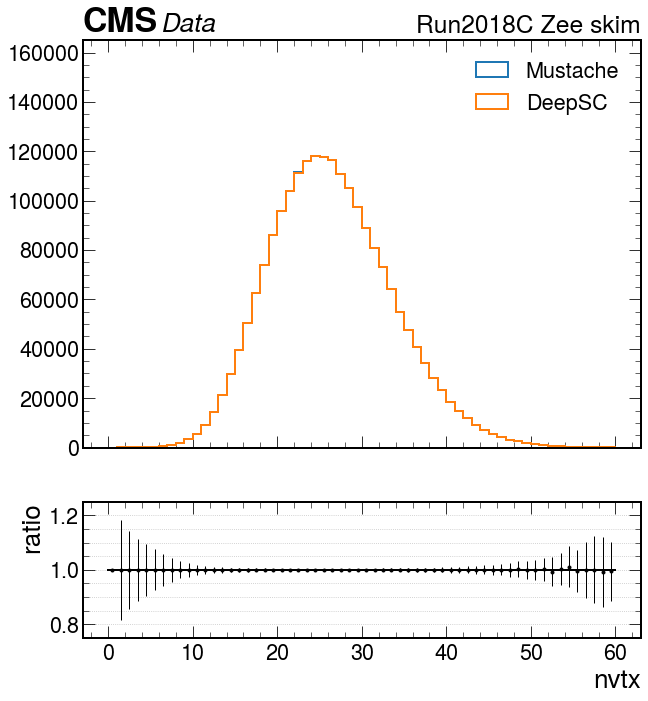

In [155]:
plot_comparison(df.nvtx_m,df.nvtx_d, var=f"nvtx", 
                output_folder=output_folder,
                 bins=60, xrange=(0,60), label="nvtx",
               ratio_lim=(0.75, 1.25))

<ipython-input-2-be3926a7de82>:45: RuntimeWarning: divide by zero encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-2-be3926a7de82>:45: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-2-be3926a7de82>:45: RuntimeWarning: invalid value encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-2-be3926a7de82>:48: RuntimeWarning: invalid value encountered in true_divide
  A/B,


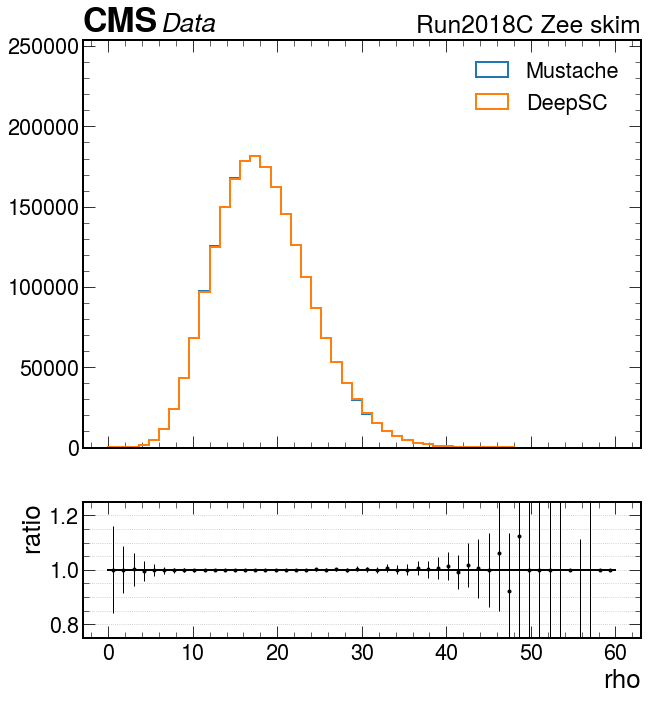

In [25]:
plot_comparison(df.rho_m,df.rho_d, var=f"$\rho$", 
                output_folder=output_folder,
                 bins=50, xrange=(0,60), label="rho",
               ratio_lim=(0.75, 1.25))

## R9 quantile analysis

In [54]:
np.sum(df.r9_m<0.95)/ len(df.r9_m)

0.5215367933046705

In [55]:
df.r9_d.quantile(0.9)

0.9936246395111084

In [56]:
qs = [0.,0.4, 0.5,0.6,0.7,0.8,0.9, 1.]
qR9_d = np.quantile(df.r9_d, qs, method="median_unbiased")
qR9_m = np.quantile(df.r9_m, qs, method="median_unbiased")
#qR9_m[-2] = 0.99999
#qR9_d[-2] = 0.99999
print(qR9_d)
print(qR9_m)

[0.14877339 0.92057362 0.94899619 0.96617252 0.97636974 0.98444531
 0.99317241 2.12292051]
[0.14712755 0.91633463 0.94415373 0.96132055 0.97221168 0.98105049
 0.99049128 2.09863186]


In [57]:
for i in range(len(qs)-1):
    m = len(df[(df.r9_m>qR9_m[i])&(df.r9_m<=qR9_m[i+1])])
    d = len(df[(df.r9_d>qR9_d[i])&(df.r9_d<=qR9_d[i+1])])
    print("Mustache", qR9_m[i], qR9_m[i+1], m)
    print("DeepSC",qR9_d[i], qR9_d[i+1], d)

Mustache 0.14299224317073822 0.9175846616427104 1084887
DeepSC 0.14299224317073822 0.9213107268015543 1084887
Mustache 0.9175846616427104 0.9455435872077942 271224
DeepSC 0.9213107268015543 0.9497753381729126 271222
Mustache 0.9455435872077942 0.9625954031944275 271221
DeepSC 0.9497753381729126 0.9669065395991008 271223
Mustache 0.9625954031944275 0.9733280460039775 271221
DeepSC 0.9669065395991008 0.9769612471262614 271221
Mustache 0.9733280460039775 0.9820387244224549 271223
DeepSC 0.9769612471262614 0.9849838614463806 271223
Mustache 0.9820387244224549 0.9913815259933472 271221
DeepSC 0.9849838614463806 0.9936246713002523 271222
Mustache 0.9913815259933472 2.0986318588256836 271221
DeepSC 0.9936246713002523 2.122920513153076 271220


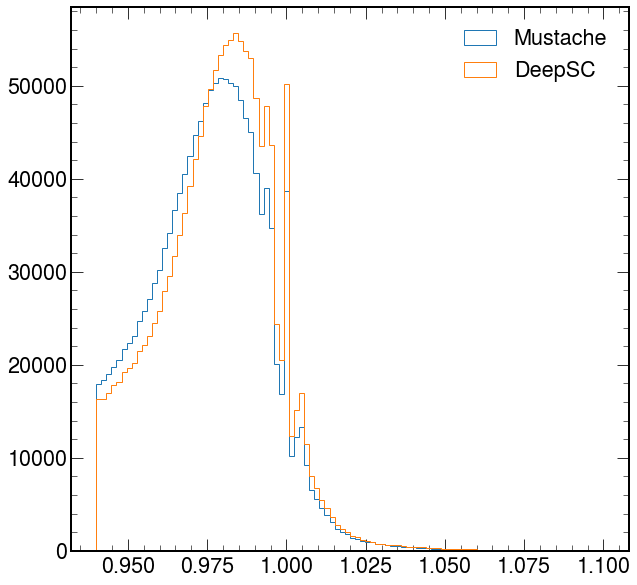

In [58]:
plt.hist(df.r9_m, bins=100, range=(0.94,1.1), histtype="step", label="Mustache")
plt.hist(df.r9_d, bins=100,  range=(0.94,1.1),histtype="step", label="DeepSC")
plt.legend()


#plt.yscale("log")

### Check Nvtx distribution in quantiles

B: 1084782.0
A. 1084784.0


<ipython-input-128-6bfc3ad90a5f>:50: RuntimeWarning: divide by zero encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-128-6bfc3ad90a5f>:50: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-128-6bfc3ad90a5f>:50: RuntimeWarning: invalid value encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-128-6bfc3ad90a5f>:53: RuntimeWarning: invalid value encountered in divide
  A/B,


B: 271197.0
A. 271196.0


<ipython-input-128-6bfc3ad90a5f>:50: RuntimeWarning: divide by zero encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-128-6bfc3ad90a5f>:50: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-128-6bfc3ad90a5f>:50: RuntimeWarning: invalid value encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-128-6bfc3ad90a5f>:53: RuntimeWarning: invalid value encountered in divide
  A/B,


B: 271190.0
A. 271195.0


<ipython-input-128-6bfc3ad90a5f>:50: RuntimeWarning: divide by zero encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-128-6bfc3ad90a5f>:50: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-128-6bfc3ad90a5f>:50: RuntimeWarning: invalid value encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-128-6bfc3ad90a5f>:53: RuntimeWarning: invalid value encountered in divide
  A/B,


B: 271202.0
A. 271205.0


<ipython-input-128-6bfc3ad90a5f>:50: RuntimeWarning: divide by zero encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-128-6bfc3ad90a5f>:50: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-128-6bfc3ad90a5f>:50: RuntimeWarning: invalid value encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-128-6bfc3ad90a5f>:53: RuntimeWarning: invalid value encountered in divide
  A/B,


B: 271205.0
A. 271199.0


<ipython-input-128-6bfc3ad90a5f>:50: RuntimeWarning: divide by zero encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-128-6bfc3ad90a5f>:50: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-128-6bfc3ad90a5f>:50: RuntimeWarning: invalid value encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-128-6bfc3ad90a5f>:53: RuntimeWarning: invalid value encountered in divide
  A/B,


B: 271204.0
A. 271206.0


<ipython-input-128-6bfc3ad90a5f>:50: RuntimeWarning: divide by zero encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-128-6bfc3ad90a5f>:50: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-128-6bfc3ad90a5f>:50: RuntimeWarning: invalid value encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-128-6bfc3ad90a5f>:53: RuntimeWarning: invalid value encountered in divide
  A/B,


B: 271212.0
A. 271206.0


<ipython-input-128-6bfc3ad90a5f>:50: RuntimeWarning: divide by zero encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-128-6bfc3ad90a5f>:50: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-128-6bfc3ad90a5f>:50: RuntimeWarning: invalid value encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-128-6bfc3ad90a5f>:53: RuntimeWarning: invalid value encountered in divide
  A/B,


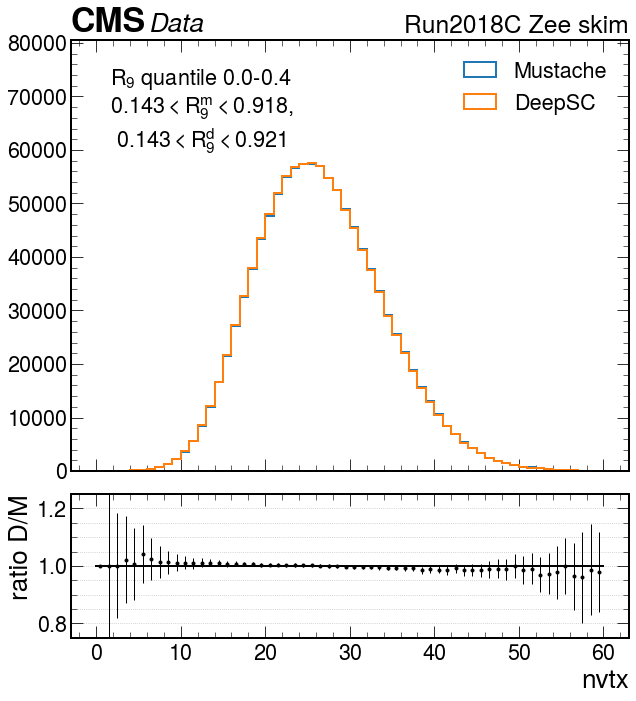

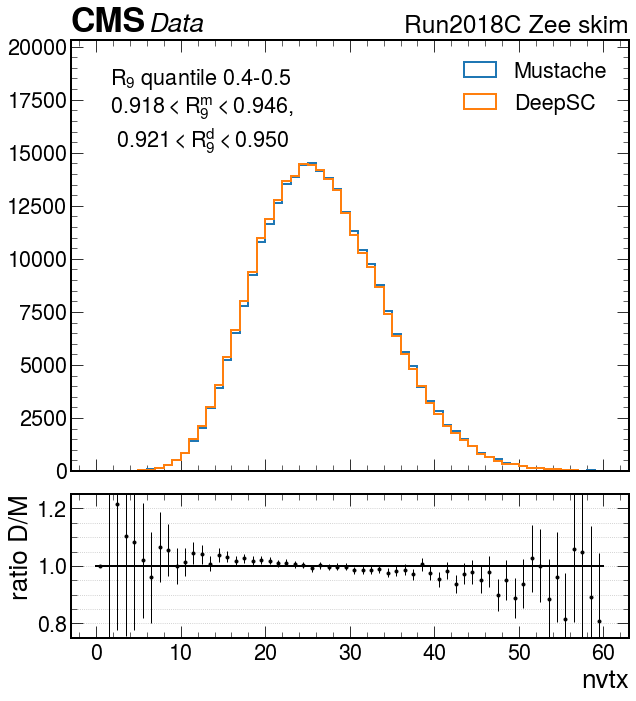

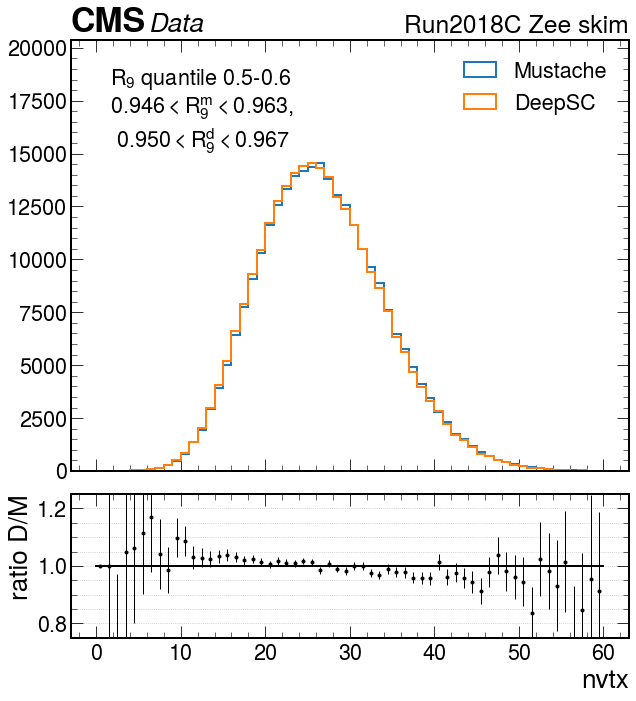

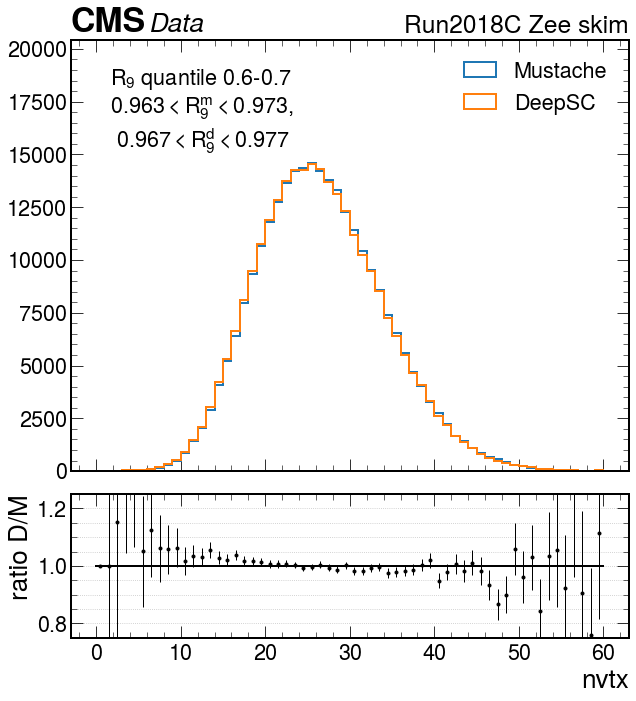

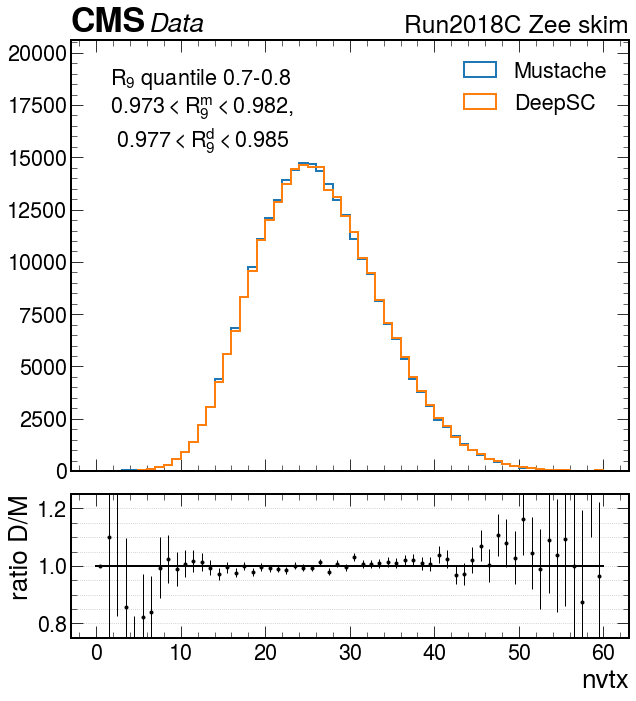

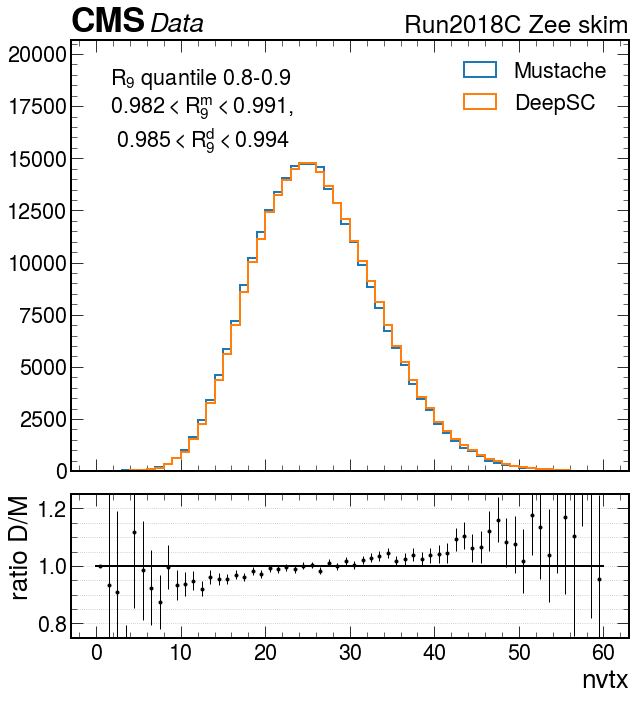

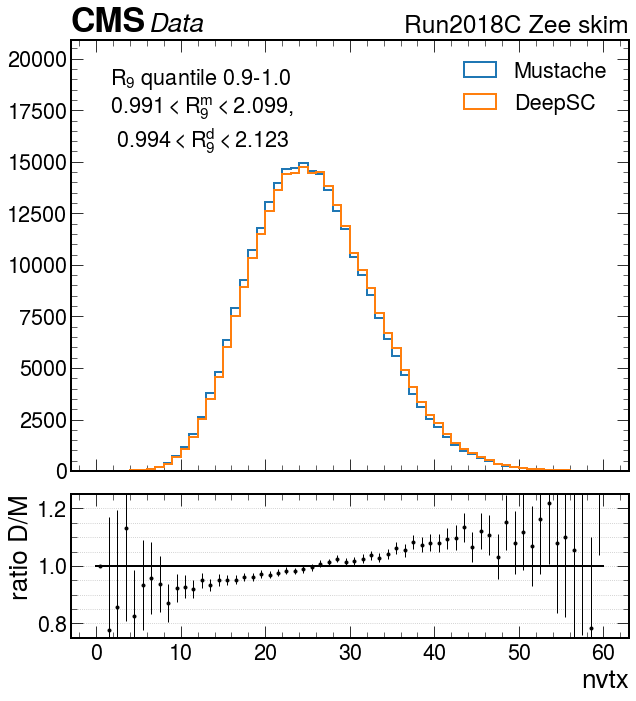

In [133]:
for i in range(len(qs)-1):
    plot_comparison(df[(df.r9_m>=qR9_m[i])&(df.r9_m<qR9_m[i+1])].nvtx_m,
                    df[(df.r9_d>=qR9_d[i])&(df.r9_d<qR9_d[i+1])].nvtx_d,
                    var=f"nvtx", 
                    text=f"$R_9$ quantile {qs[i]}-{qs[i+1]}\n${qR9_m[i]:.3f}<R_9^m<{qR9_m[i+1]:.3f}$,\n ${qR9_d[i]:.3f}<R_9^d<{qR9_d[i+1]:.3f}$",
                output_folder=output_folder,
                 bins=60, xrange=(0,60), label="nvtx",
               ratio_lim=(0.75, 1.25))

[0.14877339 0.92057362 0.94899619 0.96617252 0.97636974 0.98444531
 0.99317241 2.12292051]
[0.14712755 0.91633463 0.94415373 0.96132055 0.97221168 0.98105049
 0.99049128 2.09863186]
B: 597247.0
A. 597248.0


<ipython-input-128-6bfc3ad90a5f>:50: RuntimeWarning: divide by zero encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-128-6bfc3ad90a5f>:50: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-128-6bfc3ad90a5f>:50: RuntimeWarning: invalid value encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-128-6bfc3ad90a5f>:53: RuntimeWarning: divide by zero encountered in divide
  A/B,
<ipython-input-128-6bfc3ad90a5f>:53: RuntimeWarning: invalid value encountered in divide
  A/B,


B: 149312.0
A. 149310.0


<ipython-input-128-6bfc3ad90a5f>:50: RuntimeWarning: divide by zero encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-128-6bfc3ad90a5f>:50: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-128-6bfc3ad90a5f>:50: RuntimeWarning: invalid value encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-128-6bfc3ad90a5f>:53: RuntimeWarning: divide by zero encountered in divide
  A/B,
<ipython-input-128-6bfc3ad90a5f>:53: RuntimeWarning: invalid value encountered in divide
  A/B,


B: 149306.0
A. 149312.0


<ipython-input-128-6bfc3ad90a5f>:50: RuntimeWarning: divide by zero encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-128-6bfc3ad90a5f>:50: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-128-6bfc3ad90a5f>:50: RuntimeWarning: invalid value encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-128-6bfc3ad90a5f>:53: RuntimeWarning: divide by zero encountered in divide
  A/B,
<ipython-input-128-6bfc3ad90a5f>:53: RuntimeWarning: invalid value encountered in divide
  A/B,


B: 149318.0
A. 149321.0


<ipython-input-128-6bfc3ad90a5f>:50: RuntimeWarning: divide by zero encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-128-6bfc3ad90a5f>:50: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-128-6bfc3ad90a5f>:50: RuntimeWarning: invalid value encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-128-6bfc3ad90a5f>:53: RuntimeWarning: divide by zero encountered in divide
  A/B,
<ipython-input-128-6bfc3ad90a5f>:53: RuntimeWarning: invalid value encountered in divide
  A/B,


B: 149320.0
A. 149318.0


<ipython-input-128-6bfc3ad90a5f>:50: RuntimeWarning: divide by zero encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-128-6bfc3ad90a5f>:50: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-128-6bfc3ad90a5f>:50: RuntimeWarning: invalid value encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-128-6bfc3ad90a5f>:53: RuntimeWarning: divide by zero encountered in divide
  A/B,
<ipython-input-128-6bfc3ad90a5f>:53: RuntimeWarning: invalid value encountered in divide
  A/B,


B: 149322.0
A. 149316.0


<ipython-input-128-6bfc3ad90a5f>:50: RuntimeWarning: divide by zero encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-128-6bfc3ad90a5f>:50: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-128-6bfc3ad90a5f>:50: RuntimeWarning: invalid value encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-128-6bfc3ad90a5f>:53: RuntimeWarning: divide by zero encountered in divide
  A/B,
<ipython-input-128-6bfc3ad90a5f>:53: RuntimeWarning: invalid value encountered in divide
  A/B,


B: 149323.0
A. 149322.0


<ipython-input-128-6bfc3ad90a5f>:50: RuntimeWarning: divide by zero encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-128-6bfc3ad90a5f>:50: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-128-6bfc3ad90a5f>:50: RuntimeWarning: invalid value encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-128-6bfc3ad90a5f>:53: RuntimeWarning: divide by zero encountered in divide
  A/B,
<ipython-input-128-6bfc3ad90a5f>:53: RuntimeWarning: invalid value encountered in divide
  A/B,


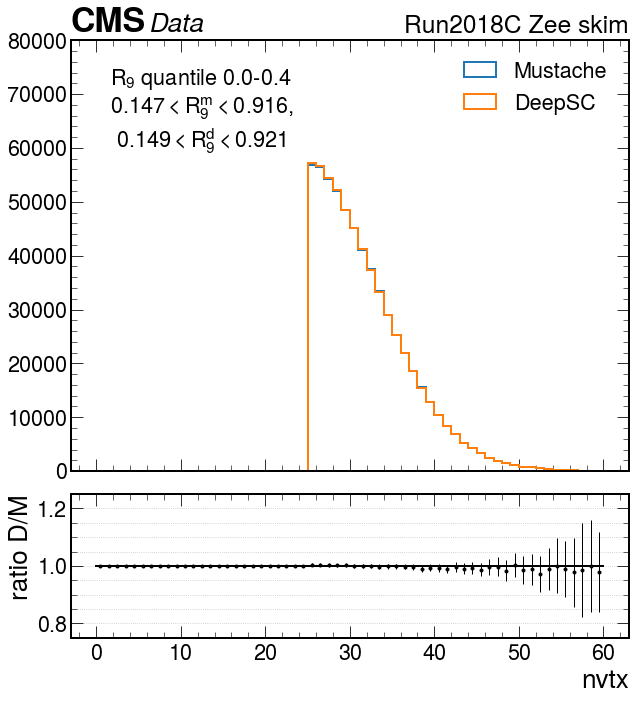

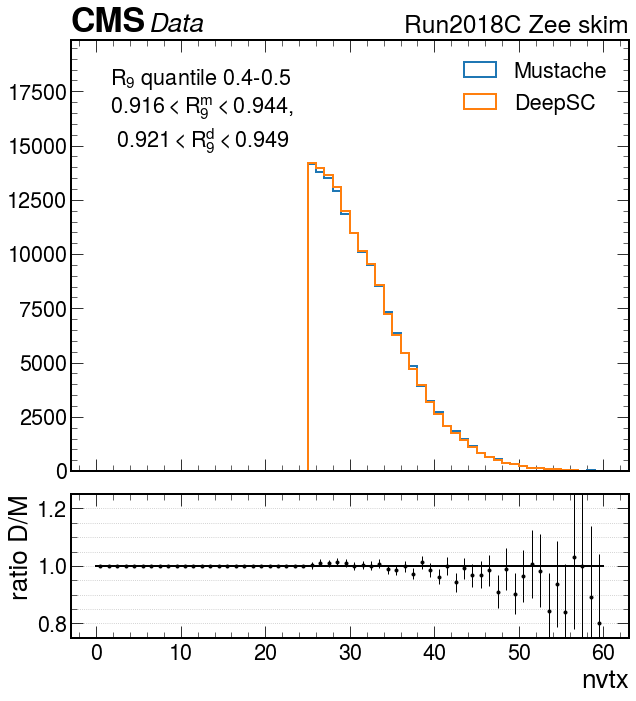

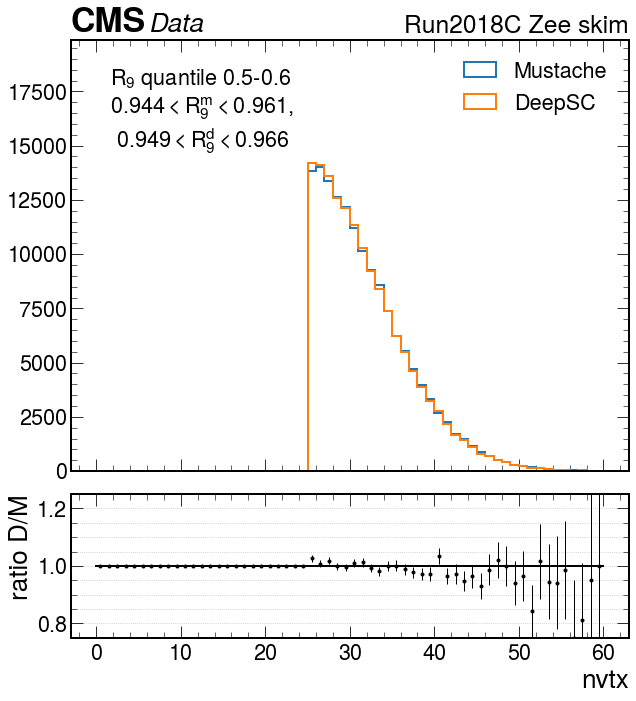

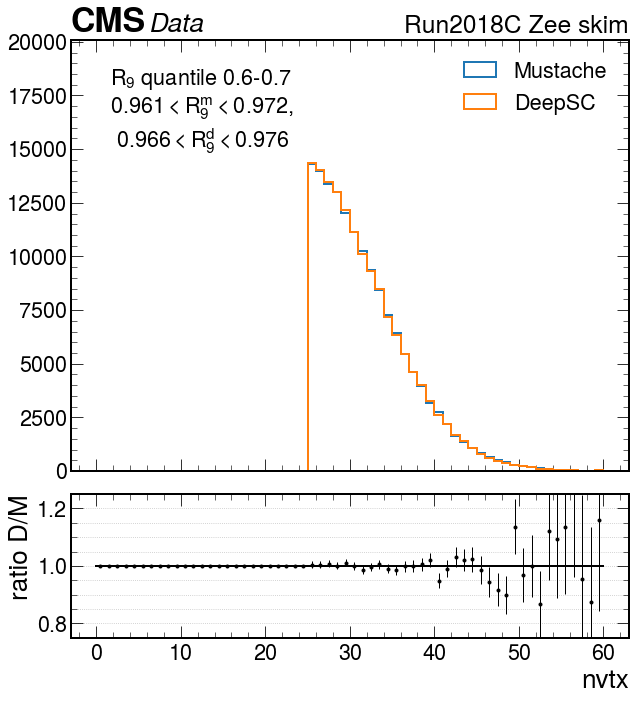

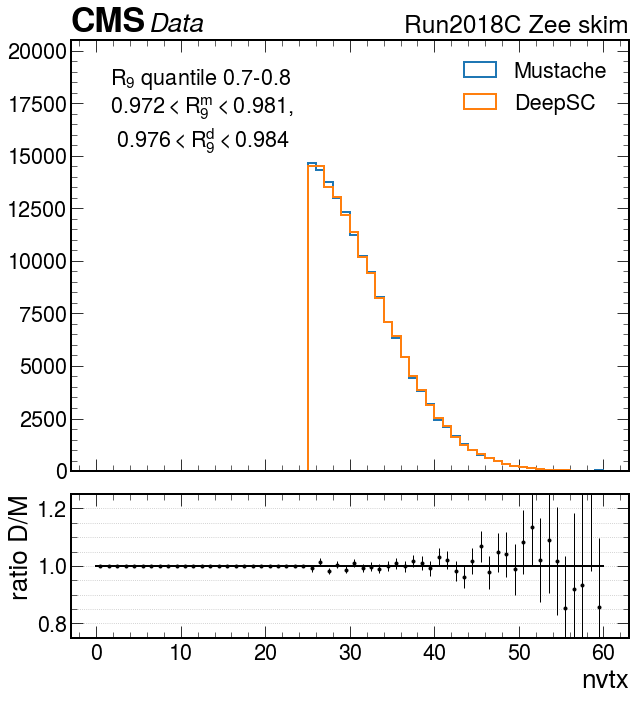

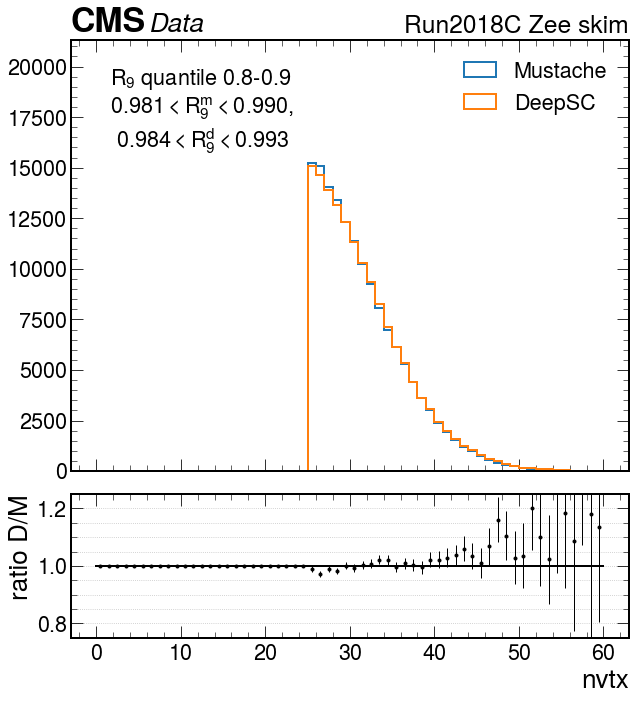

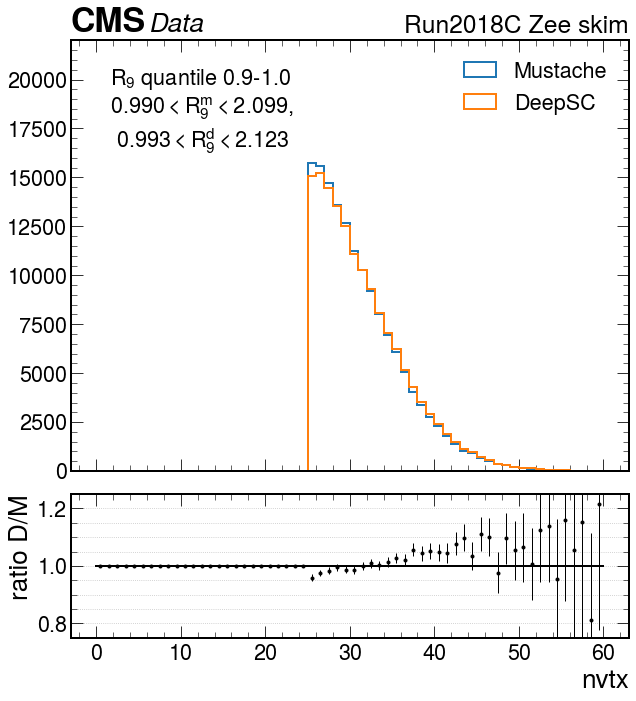

In [141]:
#After redoing the quantiles with the nvtx 25 cut

qs = [0.,0.4, 0.5,0.6,0.7,0.8,0.9, 1.]
qR9_d = np.quantile(df[df.nvtx_m>=25].r9_d, qs, method="median_unbiased")
qR9_m = np.quantile(df[df.nvtx_m>=25].r9_m, qs, method="median_unbiased")
#qR9_m[-2] = 0.99999
#qR9_d[-2] = 0.99999
print(qR9_d)
print(qR9_m)

for i in range(len(qs)-1):
    plot_comparison(df[(df.nvtx_m>=25)&(df.r9_m>=qR9_m[i])&(df.r9_m<qR9_m[i+1])].nvtx_m,
                    df[(df.nvtx_m>=25)&(df.r9_d>=qR9_d[i])&(df.r9_d<qR9_d[i+1])].nvtx_d,
                    var=f"nvtx_cut25", 
                    text=f"$R_9$ quantile {qs[i]}-{qs[i+1]}\n${qR9_m[i]:.3f}<R_9^m<{qR9_m[i+1]:.3f}$,\n ${qR9_d[i]:.3f}<R_9^d<{qR9_d[i+1]:.3f}$",
                output_folder=output_folder,
                 bins=60, xrange=(0,60), label="nvtx",
               ratio_lim=(0.75, 1.25))

B: 1084875.0
A. 1084874.0


<ipython-input-2-d52c1d4c16a5>:49: RuntimeWarning: divide by zero encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-2-d52c1d4c16a5>:49: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-2-d52c1d4c16a5>:49: RuntimeWarning: invalid value encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-2-d52c1d4c16a5>:52: RuntimeWarning: invalid value encountered in divide
  A/B,


B: 271214.0
A. 271215.0


<ipython-input-2-d52c1d4c16a5>:49: RuntimeWarning: divide by zero encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-2-d52c1d4c16a5>:49: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-2-d52c1d4c16a5>:49: RuntimeWarning: invalid value encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-2-d52c1d4c16a5>:52: RuntimeWarning: divide by zero encountered in divide
  A/B,
<ipython-input-2-d52c1d4c16a5>:52: RuntimeWarning: invalid value encountered in divide
  A/B,


B: 271221.0
A. 271221.0


<ipython-input-2-d52c1d4c16a5>:49: RuntimeWarning: divide by zero encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-2-d52c1d4c16a5>:49: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-2-d52c1d4c16a5>:49: RuntimeWarning: invalid value encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-2-d52c1d4c16a5>:52: RuntimeWarning: invalid value encountered in divide
  A/B,


B: 271219.0
A. 271218.0


<ipython-input-2-d52c1d4c16a5>:49: RuntimeWarning: divide by zero encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-2-d52c1d4c16a5>:49: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-2-d52c1d4c16a5>:49: RuntimeWarning: invalid value encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-2-d52c1d4c16a5>:52: RuntimeWarning: divide by zero encountered in divide
  A/B,
<ipython-input-2-d52c1d4c16a5>:52: RuntimeWarning: invalid value encountered in divide
  A/B,


B: 271220.0
A. 271218.0


<ipython-input-2-d52c1d4c16a5>:49: RuntimeWarning: divide by zero encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-2-d52c1d4c16a5>:49: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-2-d52c1d4c16a5>:49: RuntimeWarning: invalid value encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-2-d52c1d4c16a5>:52: RuntimeWarning: divide by zero encountered in divide
  A/B,
<ipython-input-2-d52c1d4c16a5>:52: RuntimeWarning: invalid value encountered in divide
  A/B,


B: 271219.0
A. 271223.0


<ipython-input-2-d52c1d4c16a5>:49: RuntimeWarning: divide by zero encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-2-d52c1d4c16a5>:49: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-2-d52c1d4c16a5>:49: RuntimeWarning: invalid value encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-2-d52c1d4c16a5>:52: RuntimeWarning: divide by zero encountered in divide
  A/B,
<ipython-input-2-d52c1d4c16a5>:52: RuntimeWarning: invalid value encountered in divide
  A/B,


B: 271219.0
A. 271218.0


<ipython-input-2-d52c1d4c16a5>:49: RuntimeWarning: divide by zero encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-2-d52c1d4c16a5>:49: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-2-d52c1d4c16a5>:49: RuntimeWarning: invalid value encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
<ipython-input-2-d52c1d4c16a5>:52: RuntimeWarning: invalid value encountered in divide
  A/B,


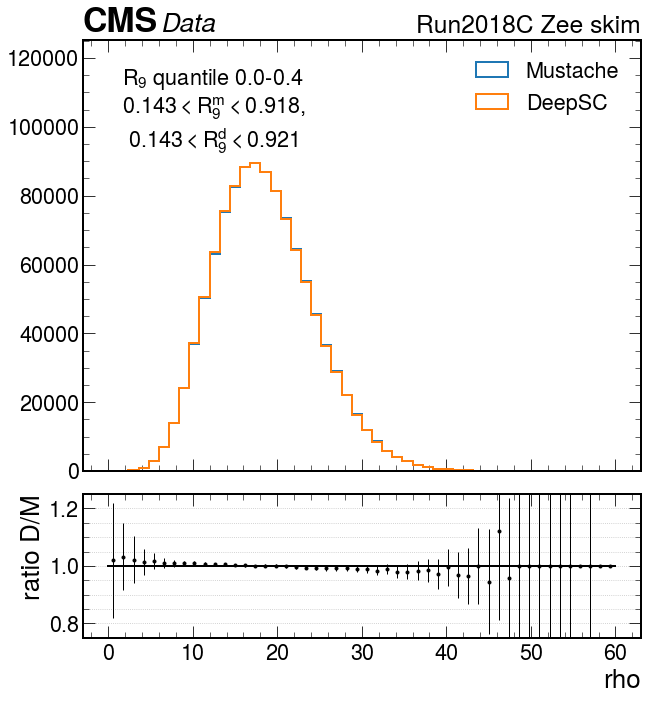

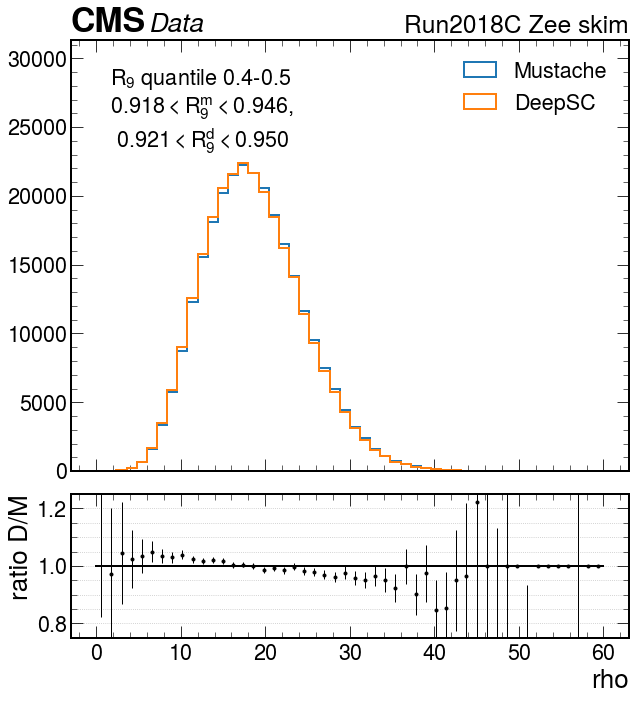

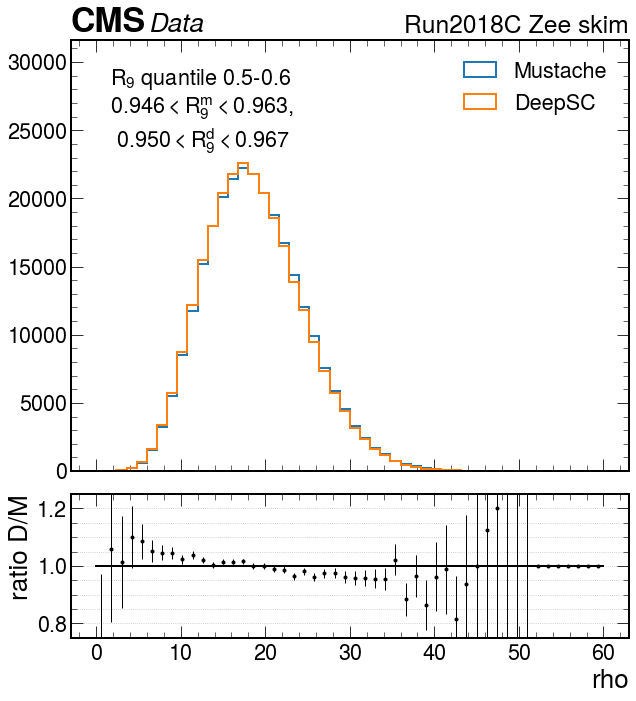

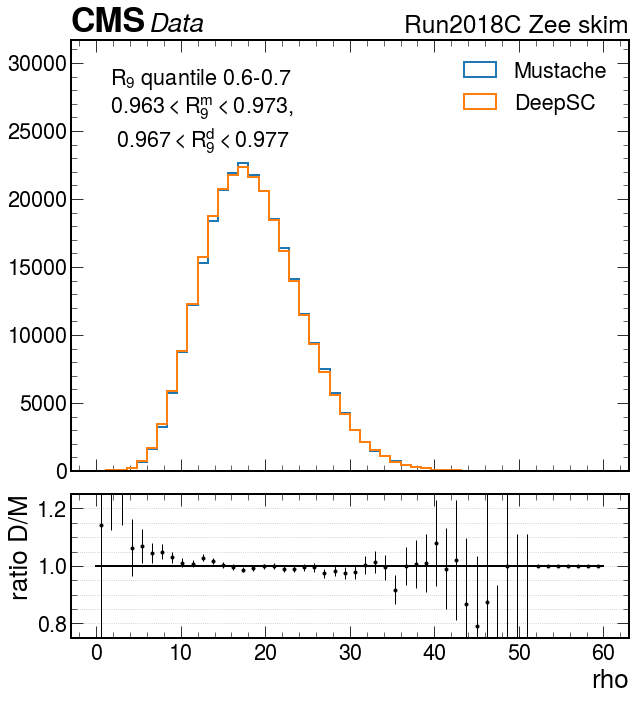

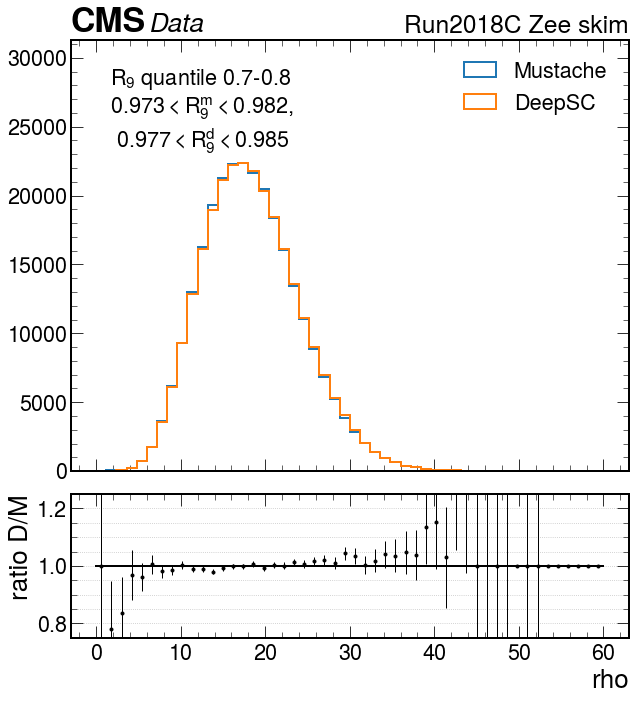

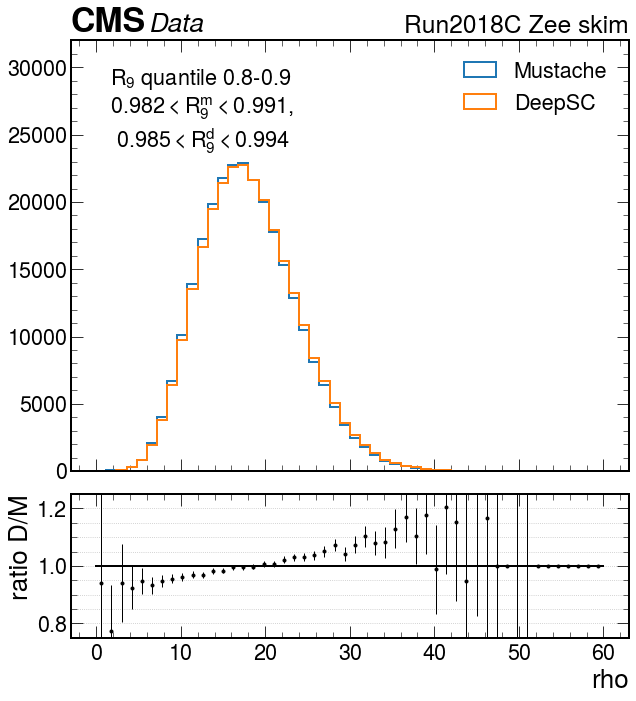

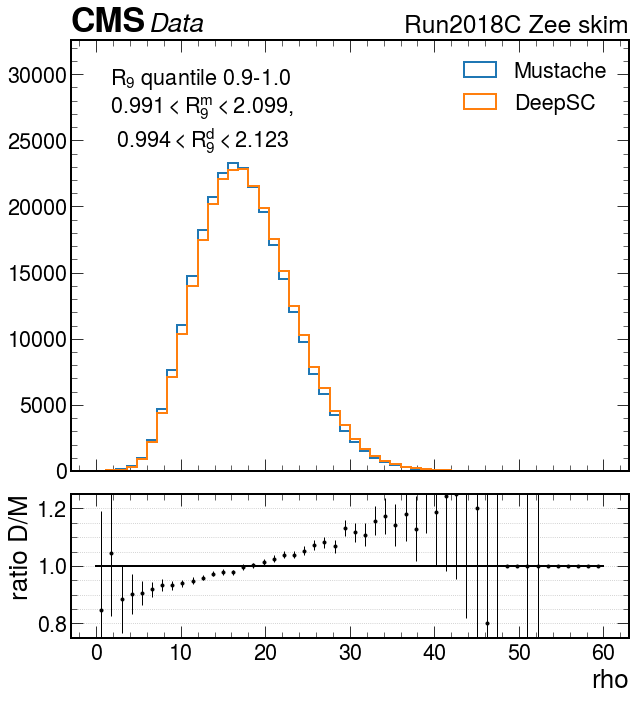

In [61]:
for i in range(len(qs)-1):
    plot_comparison(df[(df.r9_m>=qR9_m[i])&(df.r9_m<qR9_m[i+1])].rho_m,
                    df[(df.r9_d>=qR9_d[i])&(df.r9_d<qR9_d[i+1])].rho_d,
                    var=f"$\rho$", 
                    text=f"$R_9$ quantile {qs[i]}-{qs[i+1]}\n${qR9_m[i]:.3f}<R_9^m<{qR9_m[i+1]:.3f}$,\n ${qR9_d[i]:.3f}<R_9^d<{qR9_d[i+1]:.3f}$",
                output_folder=output_folder,
                 bins=50, xrange=(0,60), label="rho",
               ratio_lim=(0.75, 1.25))

### Z mass inclusive

B: 1784758.0
A. 1784592.0


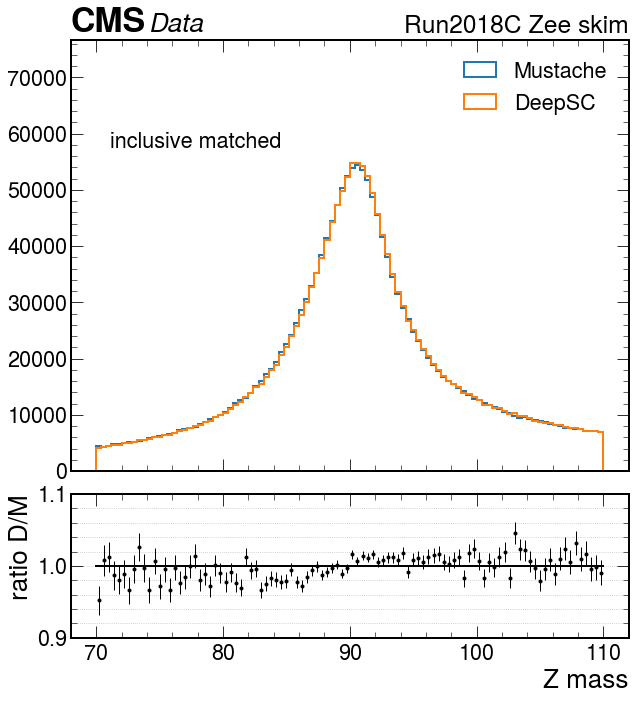

In [19]:
 plot_comparison(df.mass_m,
                    df.mass_d,
                    var="zmass_inclusive", 
                    text=f"inclusive matched",
                 output_folder=output_folder,
                 bins=100, xrange=(70,110), label=f"Z mass", ratio_lim=(0.9, 1.1))

B: 884815.0
A. 884855.0


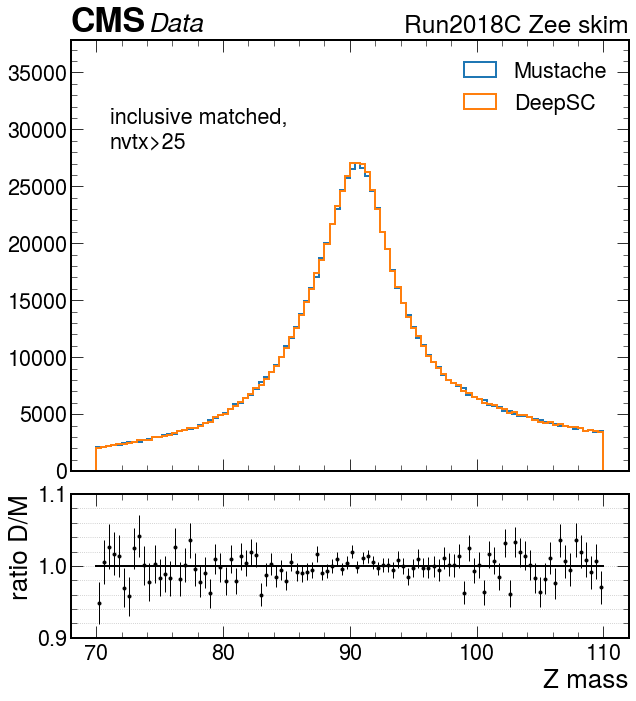

In [20]:
 plot_comparison(df[df.nvtx_m>25].mass_m,
                    df[df.nvtx_m>25].mass_d,
                    var=f"zmass_inclusive_nvtx25", 
                    text=f"inclusive matched,\nnvtx>25",
                 output_folder=output_folder,
                 bins=100, xrange=(70,110), label=f"Z mass", ratio_lim=(0.9, 1.1))

### Z mass by R9

In [105]:
qs = [0.,0.4, 0.5,0.6,0.7,0.8,0.9, 1.]
qR9_d = np.quantile(df.r9_d, qs, method="median_unbiased")
qR9_m = np.quantile(df.r9_m, qs, method="median_unbiased")
#qR9_m[-2] = 0.99999
#qR9_d[-2] = 0.99999
print(qR9_d)
print(qR9_m)

[0.14299224 0.92131073 0.94977534 0.96690654 0.97696125 0.98498386
 0.99362467 2.12292051]
[0.14299224 0.91758466 0.94554359 0.9625954  0.97332805 0.98203872
 0.99138153 2.09863186]


B: 686861.0
A. 686095.0
B: 167358.0
A. 165954.0
B: 174509.0
A. 172822.0
B: 189773.0
A. 192390.0
B: 199925.0
A. 202183.0
B: 200123.0
A. 199643.0
B: 166209.0
A. 165505.0


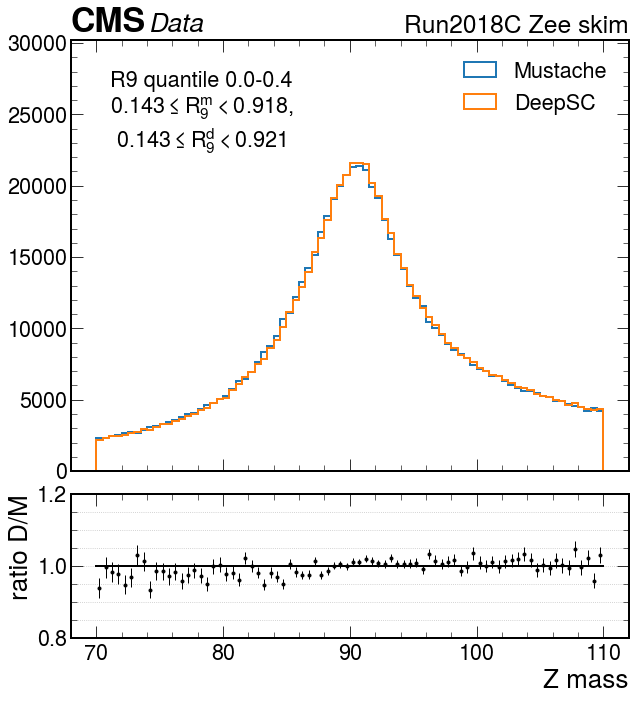

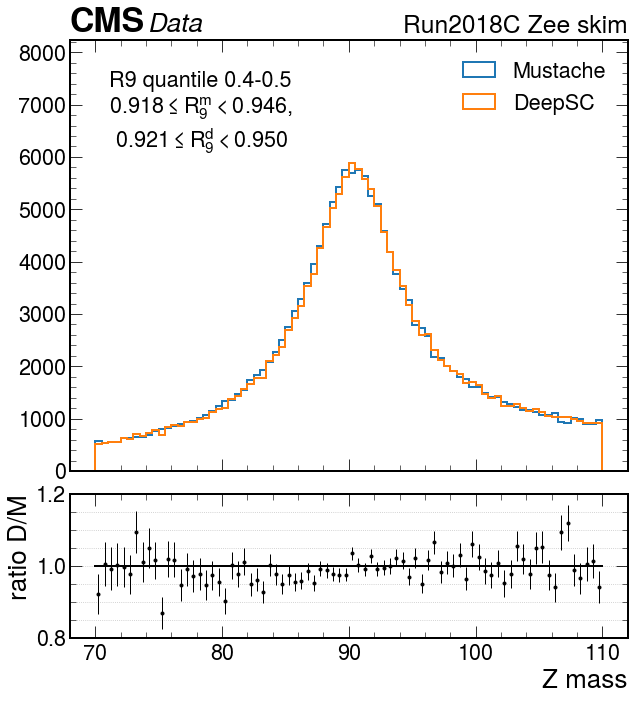

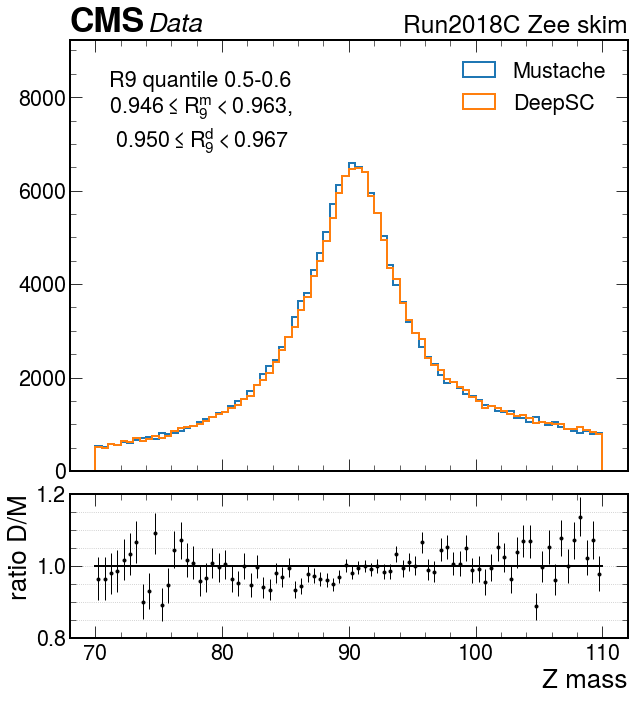

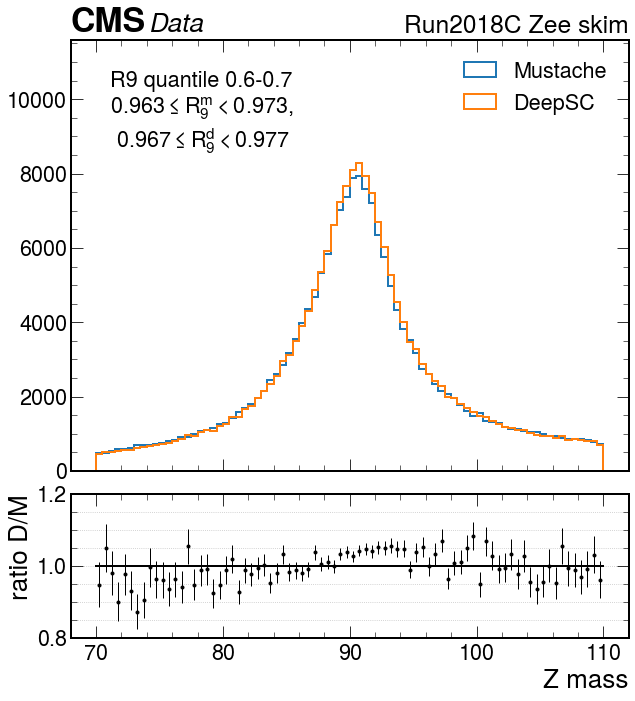

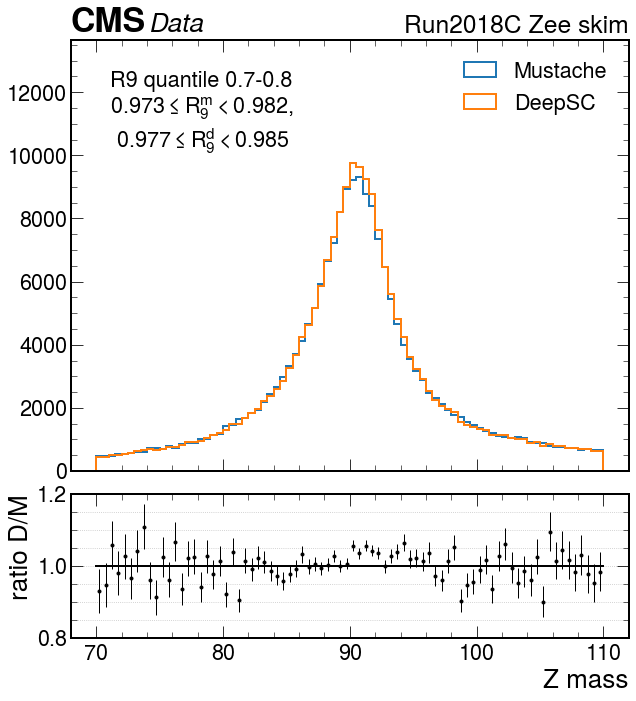

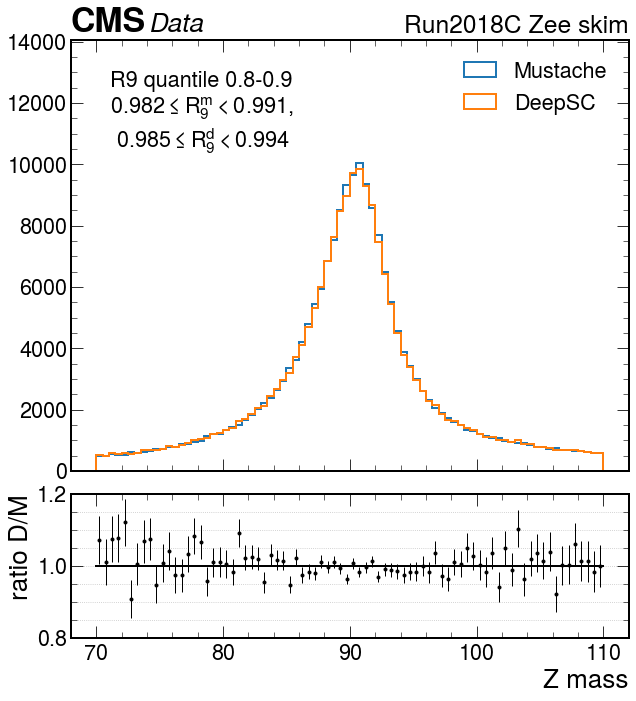

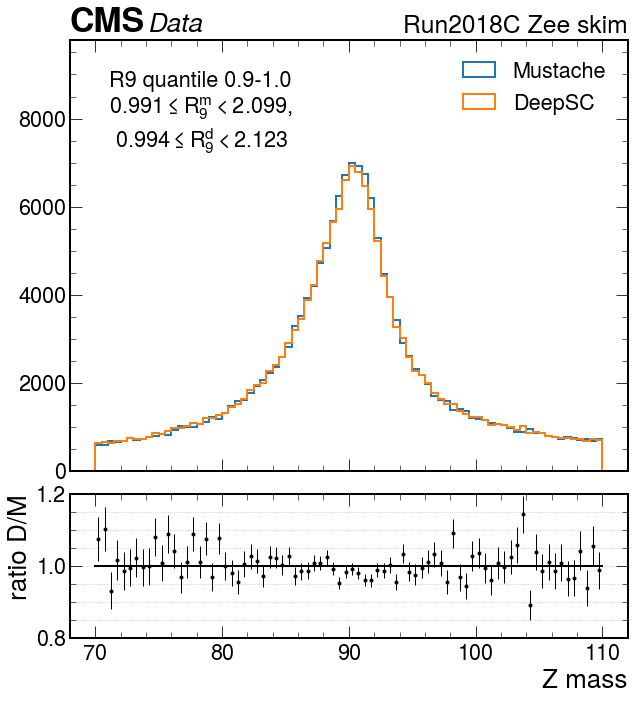

In [132]:
for i in range(len(qs)-1):
    plot_comparison(df[(df.r9_m>=qR9_m[i])&(df.r9_m<qR9_m[i+1])].mass_m,
                    df[(df.r9_d>=qR9_d[i])&(df.r9_d<qR9_d[i+1])].mass_d,
                    var=f"zmass_quantile_{qs[i]}-{qs[i+1]}", 
                    text=f"R9 quantile {qs[i]}-{qs[i+1]}\n${qR9_m[i]:.3f}\leq R_9^m<{qR9_m[i+1]:.3f}$,\n ${qR9_d[i]:.3f} \leq R_9^d<{qR9_d[i+1]:.3f}$",
                 output_folder=output_folder,
                 bins=80, xrange=(70,110), label=f"Z mass")
               #ratio_lim=(0.75, 1.25))

#### Adding cut in nvtx

In [136]:
qs = [0.,0.4, 0.5,0.6,0.7,0.8,0.9, 1.]
qR9_d = np.quantile(df[df.nvtx_m>=25].r9_d, qs, method="median_unbiased")
qR9_m = np.quantile(df[df.nvtx_m>=25].r9_m, qs, method="median_unbiased")
#qR9_m[-2] = 0.99999
#qR9_d[-2] = 0.99999
print(qR9_d)
print(qR9_m)

[0.14877339 0.92057362 0.94899619 0.96617252 0.97636974 0.98444531
 0.99317241 2.12292051]
[0.14712755 0.91633463 0.94415373 0.96132055 0.97221168 0.98105049
 0.99049128 2.09863186]


B: 376889.0
A. 376323.0
B: 91850.0
A. 90957.0
B: 95481.0
A. 94391.0
B: 103632.0
A. 105246.0
B: 109434.0
A. 110906.0
B: 110385.0
A. 110060.0
B: 92650.0
A. 92417.0


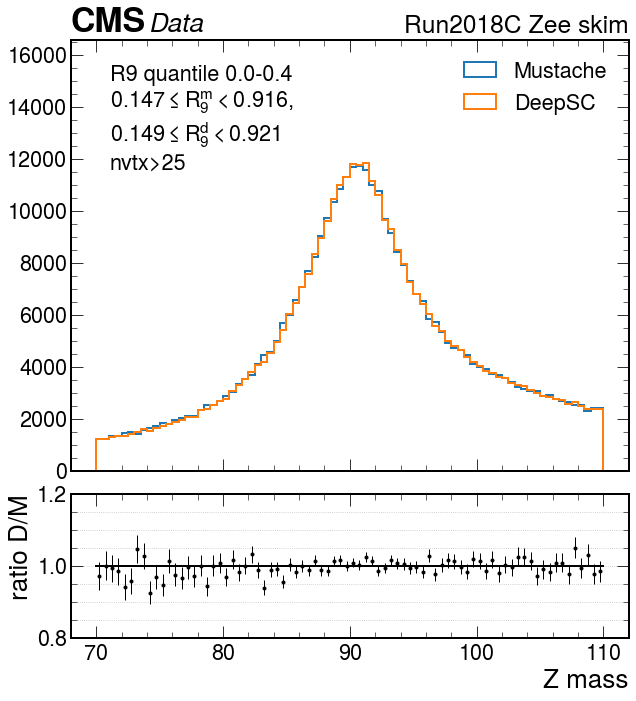

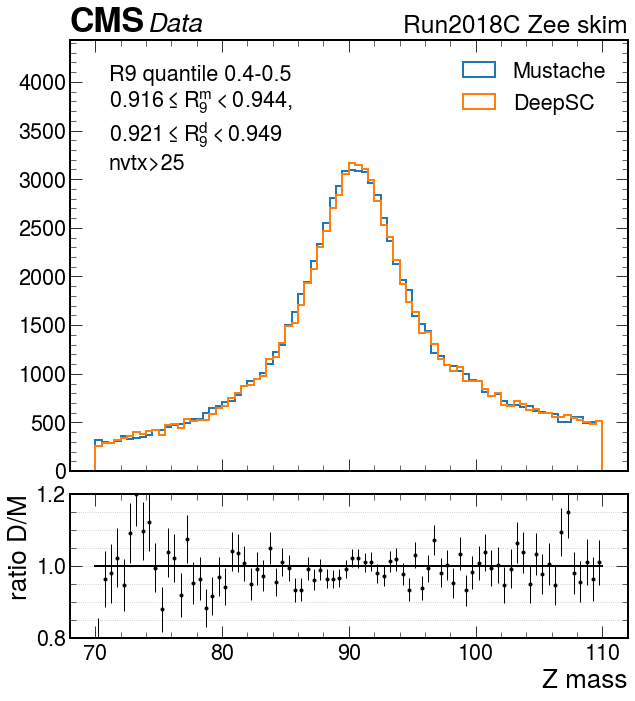

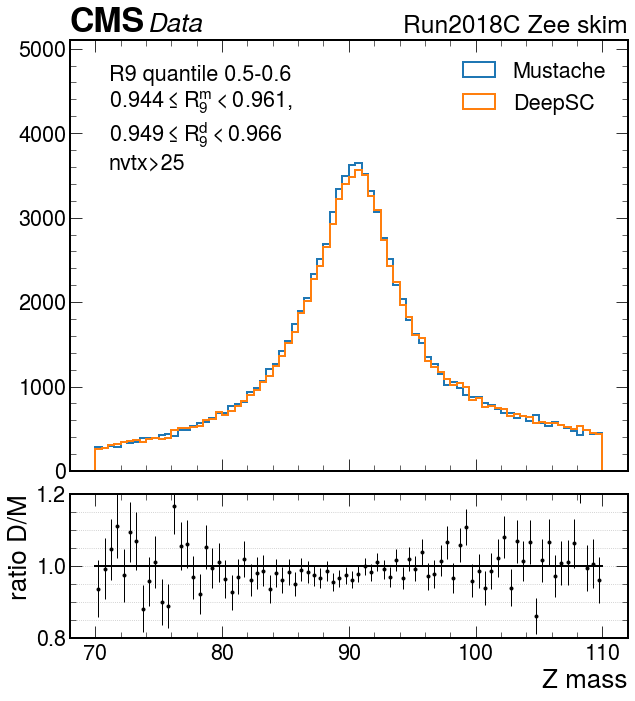

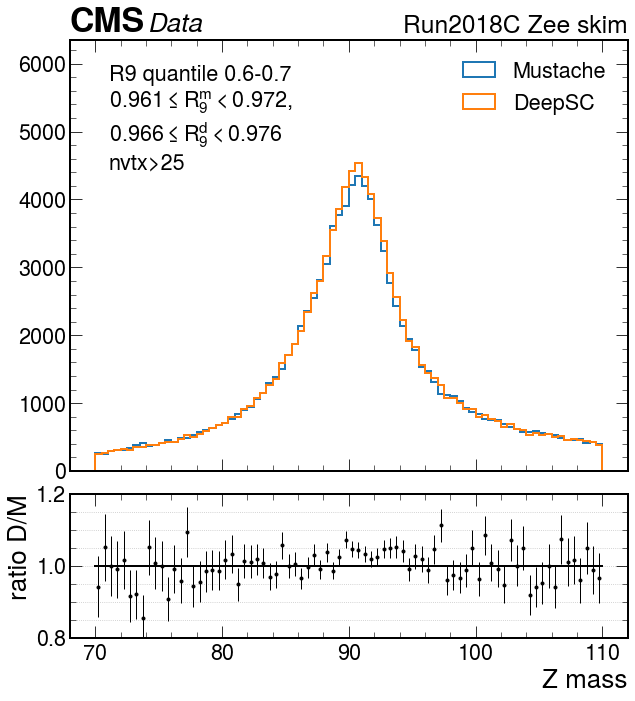

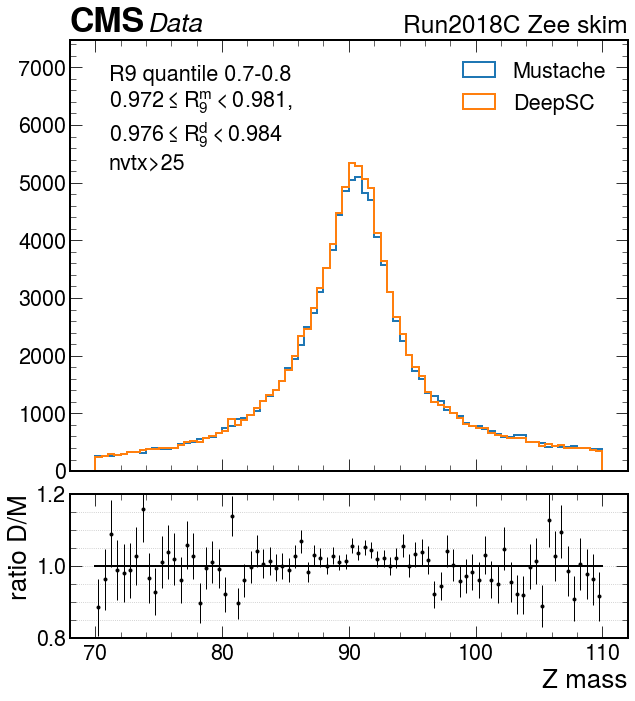

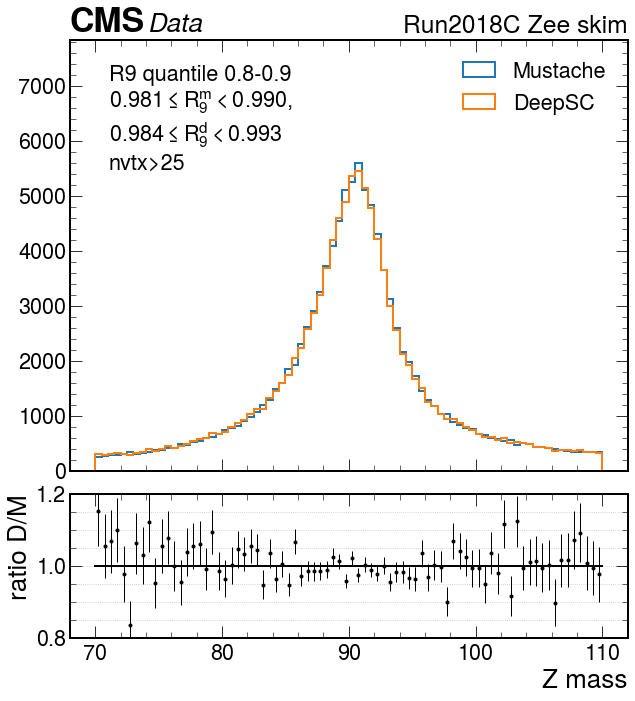

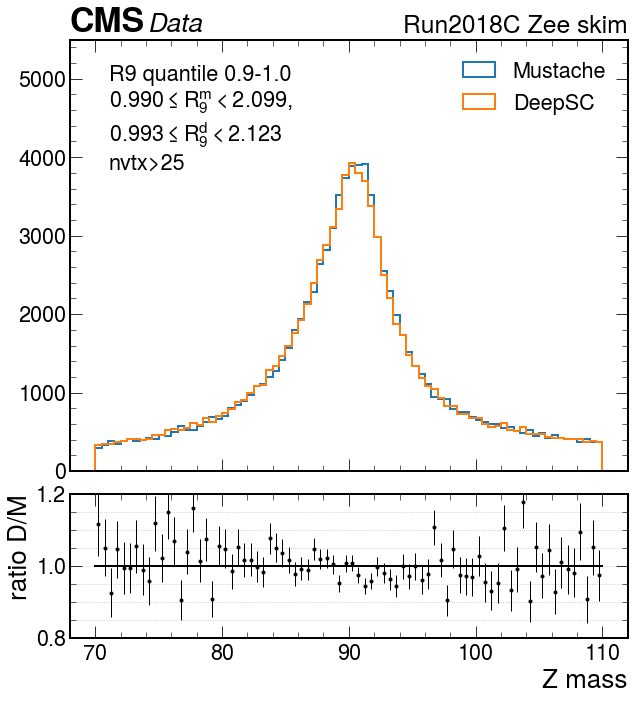

In [138]:
for i in range(len(qs)-1):
    plot_comparison(df[(df.nvtx_m>=25)&(df.r9_m>=qR9_m[i])&(df.r9_m<qR9_m[i+1])].mass_m,
                    df[(df.nvtx_m>=25)&(df.r9_d>=qR9_d[i])&(df.r9_d<qR9_d[i+1])].mass_d,
                    var=f"zmass_quantile_{qs[i]}-{qs[i+1]}_nvtx25", 
                    text=f"R9 quantile {qs[i]}-{qs[i+1]}\n${qR9_m[i]:.3f}\leq R_9^m<{qR9_m[i+1]:.3f}$,\n${qR9_d[i]:.3f} \leq R_9^d<{qR9_d[i+1]:.3f}$\nnvtx>25",
                 output_folder=output_folder, texty=0.7,
                 bins=80, xrange=(70,110), label=f"Z mass")
               #ratio_lim=(0.75, 1.25))

### Cut in Eta in quantiles of R9

B: 487906.0
A. 487844.0
B: 125464.0
A. 125129.0
B: 128453.0
A. 129784.0
B: 131732.0
A. 132877.0
B: 133055.0
A. 133185.0
B: 132287.0
A. 131569.0
B: 124123.0
A. 122460.0


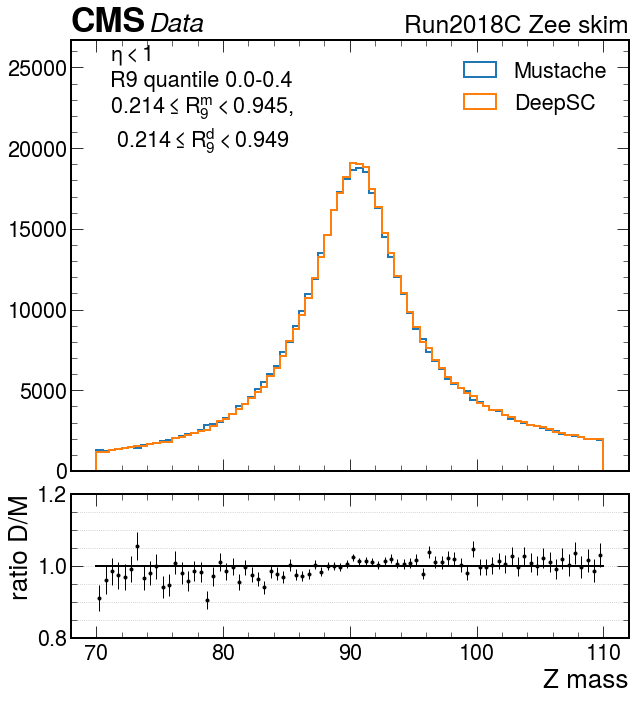

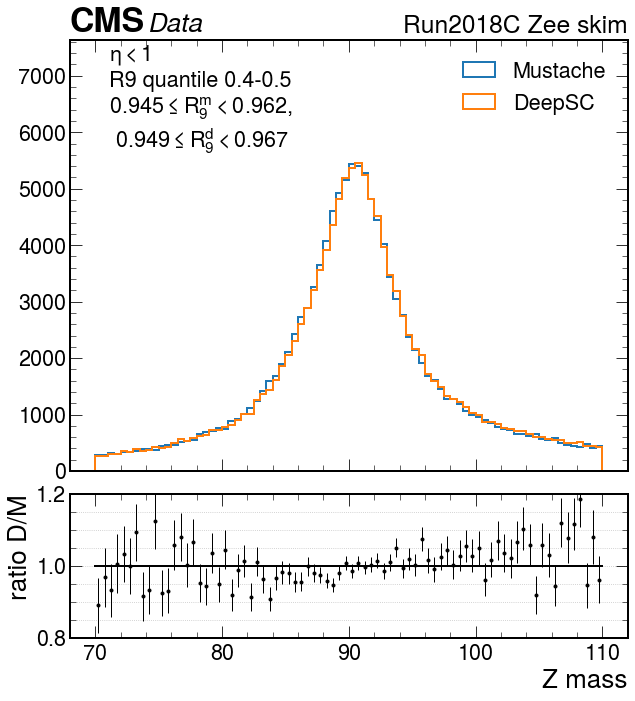

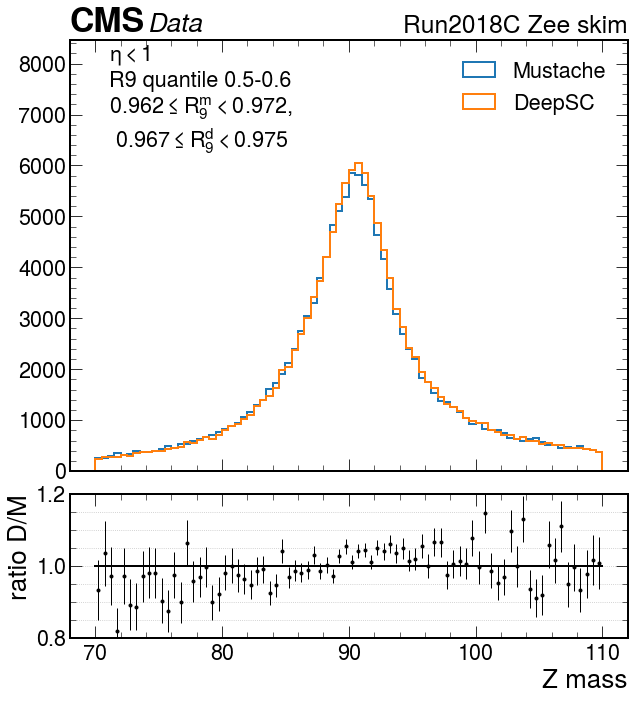

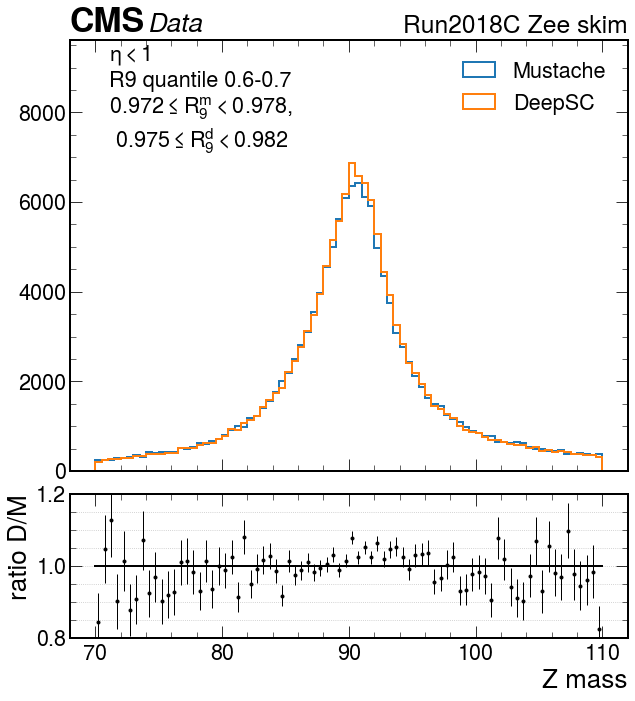

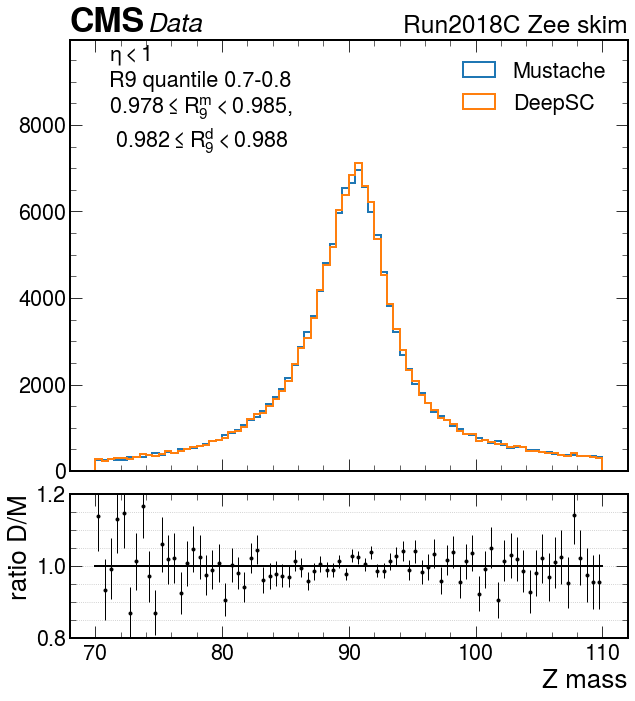

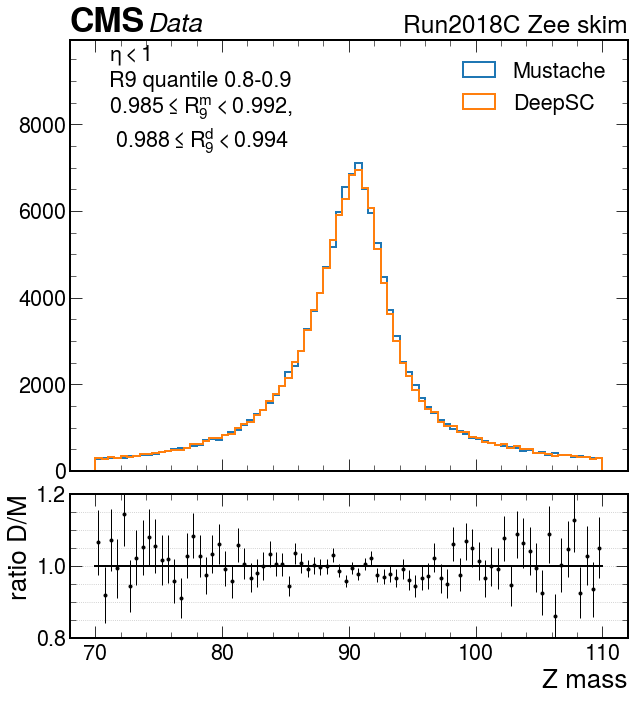

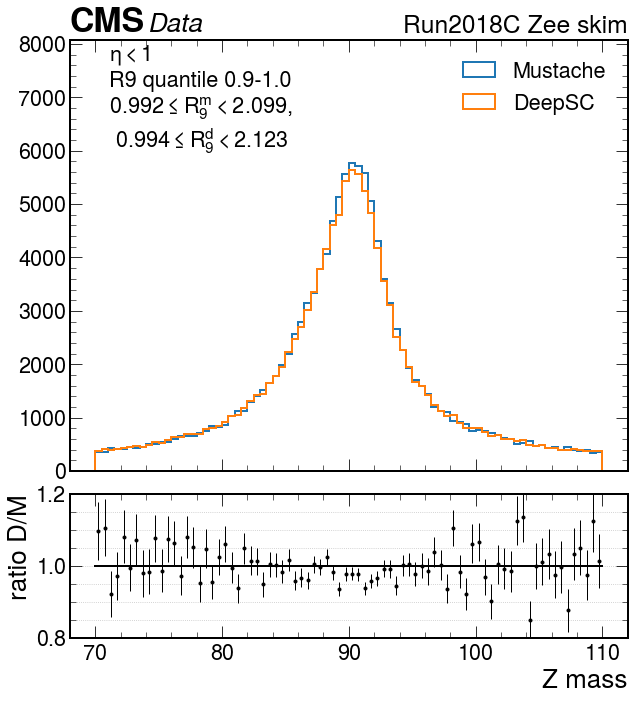

In [70]:
eta_mask = (abs(df.ele_eta_m)<1.0)

qs = [0.,0.4, 0.5,0.6,0.7,0.8,0.9, 1.]
qR9_d_eta = np.quantile(df[eta_mask].r9_d, qs, method="median_unbiased")
qR9_m_eta = np.quantile(df[eta_mask].r9_m, qs, method="median_unbiased")

for i in range(len(qs)-1):
    plot_comparison(df[eta_mask&(df.r9_m>=qR9_m_eta[i])&(df.r9_m<qR9_m_eta[i+1])].mass_m,
                    df[eta_mask&(df.r9_d>=qR9_d_eta[i])&(df.r9_d<qR9_d_eta[i+1])].mass_d,
                    var=f"zmass_quantile_{qs[i]}-{qs[i+1]}", 
                    text=f"$\eta<1.$\nR9 quantile {qs[i]}-{qs[i+1]}\n${qR9_m_eta[i]:.3f}\leq R_9^m<{qR9_m_eta[i+1]:.3f}$,\n ${qR9_d_eta[i]:.3f} \leq R_9^d<{qR9_d_eta[i+1]:.3f}$",
                 output_folder=output_folder,
                 bins=80, xrange=(70,110), label=f"Z mass")
               #ratio_lim=(0.75, 1.25))

B: 71448.0
A. 71346.0
B: 45931.0
A. 46048.0
B: 33293.0
A. 33352.0


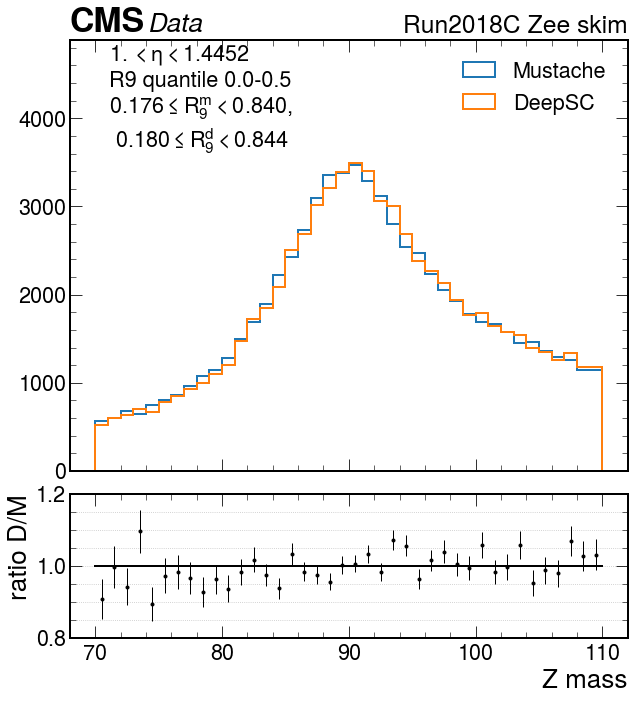

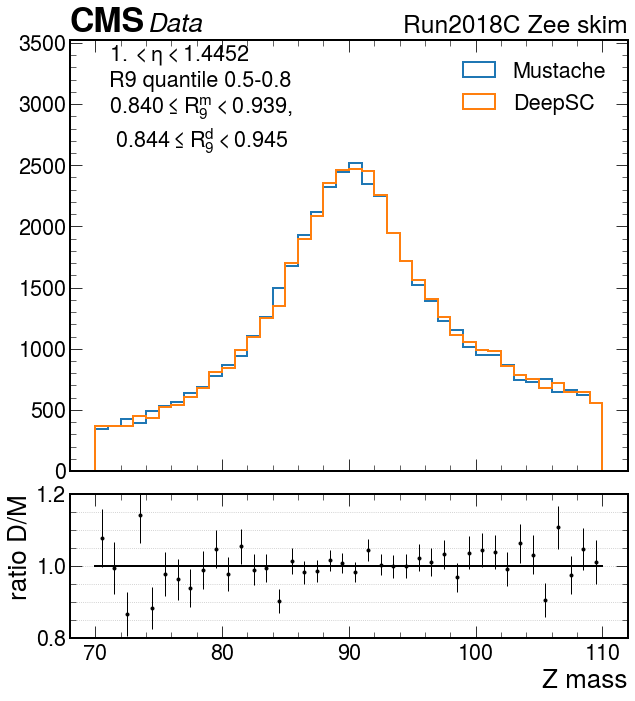

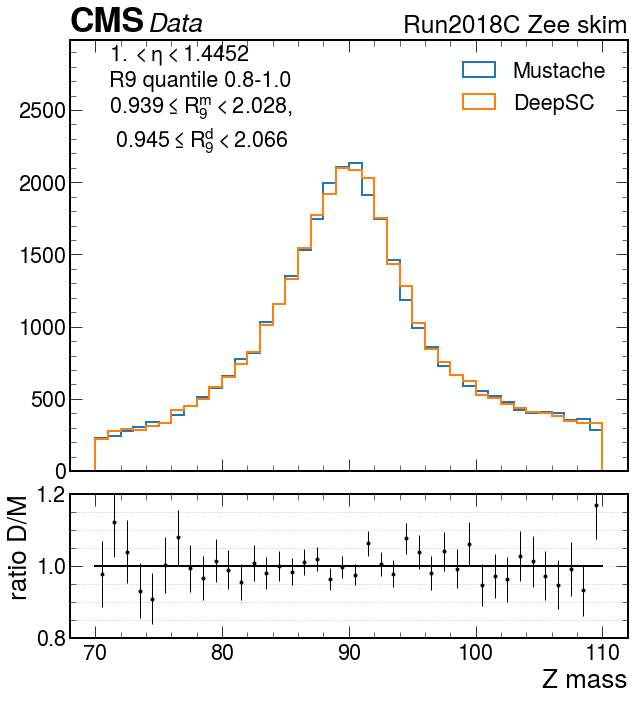

In [71]:
eta_mask = (abs(df.ele_eta_m)<1.4452)&(abs(df.ele_eta_m>1.0))

qs = [0., 0.5, 0.8, 1.]
qR9_d_eta = np.quantile(df[eta_mask].r9_d, qs, method="median_unbiased")
qR9_m_eta = np.quantile(df[eta_mask].r9_m, qs, method="median_unbiased")

for i in range(len(qs)-1):
    plot_comparison(df[eta_mask&(df.r9_m>=qR9_m_eta[i])&(df.r9_m<qR9_m_eta[i+1])].mass_m,
                    df[eta_mask&(df.r9_d>=qR9_d_eta[i])&(df.r9_d<qR9_d_eta[i+1])].mass_d,
                    var=f"zmass_quantile_{qs[i]}-{qs[i+1]}", 
                    text=f"$1.<\eta<1.4452$\nR9 quantile {qs[i]}-{qs[i+1]}\n${qR9_m_eta[i]:.3f}\leq R_9^m<{qR9_m_eta[i+1]:.3f}$,\n ${qR9_d_eta[i]:.3f} \leq R_9^d<{qR9_d_eta[i+1]:.3f}$",
                 output_folder=output_folder,
                 bins=40, xrange=(70,110), label=f"Z mass")
               #ratio_lim=(0.75, 1.25))

B: 1389824.0
A. 1389763.0


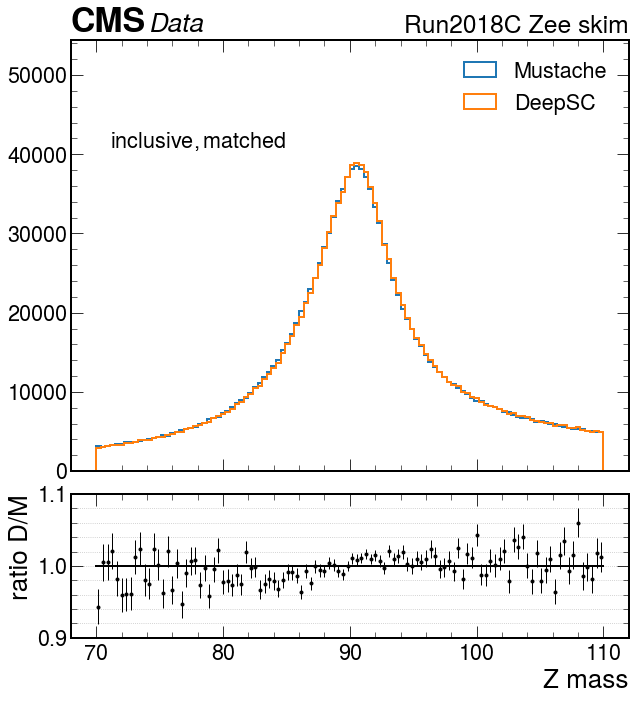

In [46]:
plot_comparison(df.mass_m, df.mass_d,
                var=f"Z_mass_incl_match", 
                output_folder=output_folder,
                bins=110, xrange=(70,110), label="Z mass",
                text="$inclusive, matched$", ratio_lim=(0.9,1.1))


B: 243424.0
A. 243445.0


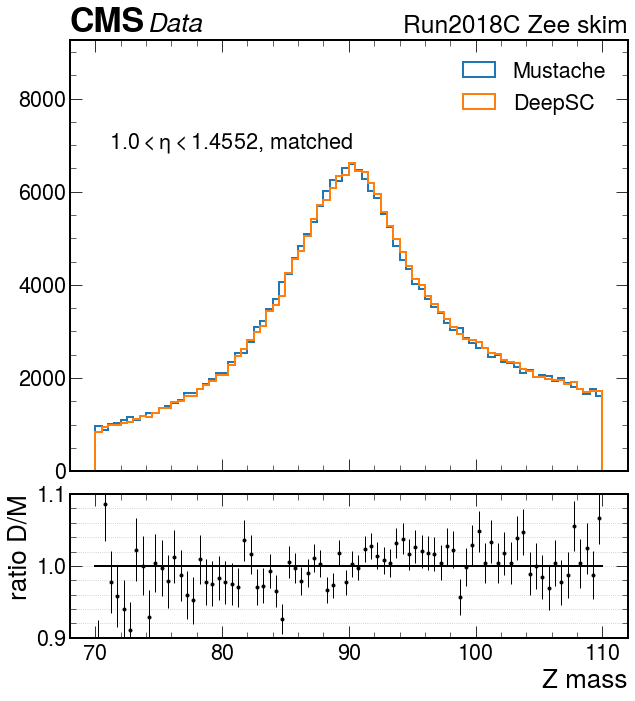

In [51]:
df_cut = df[(abs(df.ele_eta_m)>1.0)&(abs(df.ele_eta_m)<1.4552)]

plot_comparison(df_cut.mass_m, df_cut.mass_d,
                var=f"Z_mass_incl_match", 
                output_folder=output_folder,
                bins=80, xrange=(70,110), label="Z mass",
                text="$1.0 < \eta<1.4552$, matched", ratio_lim=(0.9,1.1))


## Bins in eta

B: 690144.0
A. 690276.0
B: 572876.0
A. 572572.0
B: 307100.0
A. 307116.0
B: 30655.0
A. 30646.0
B: 134070.0
A. 134217.0
B: 49770.0
A. 49636.0


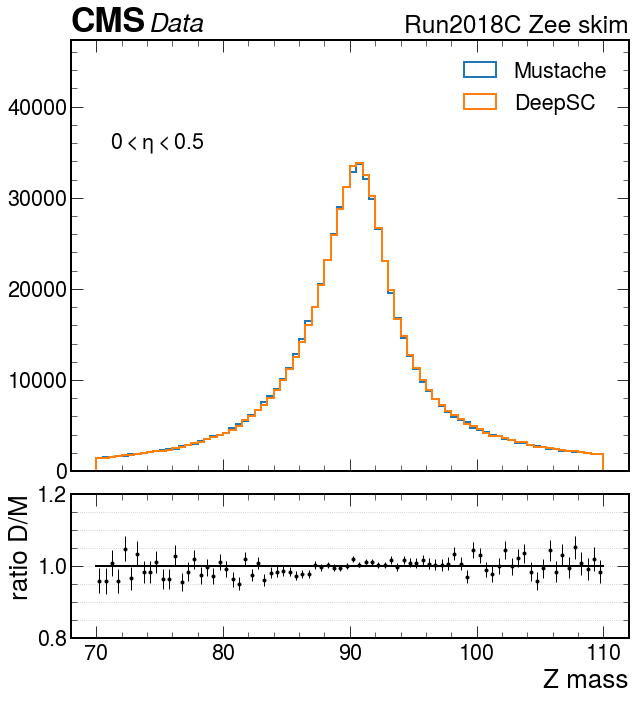

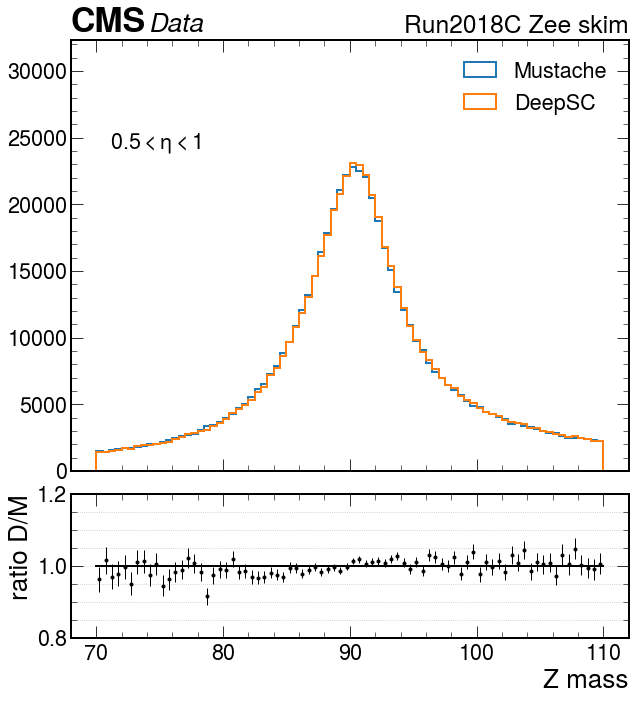

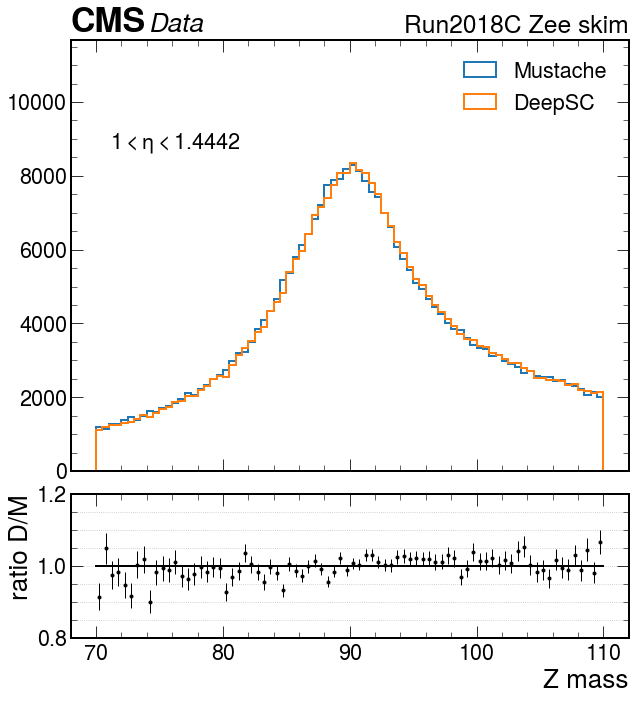

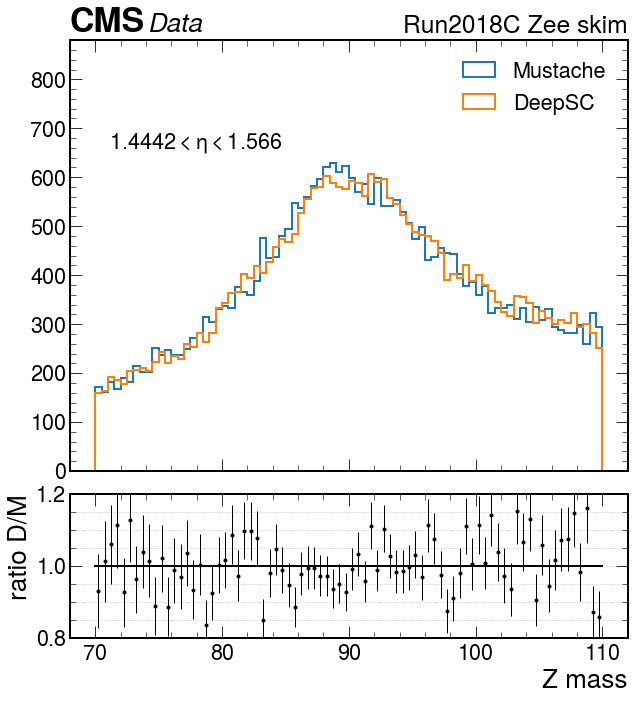

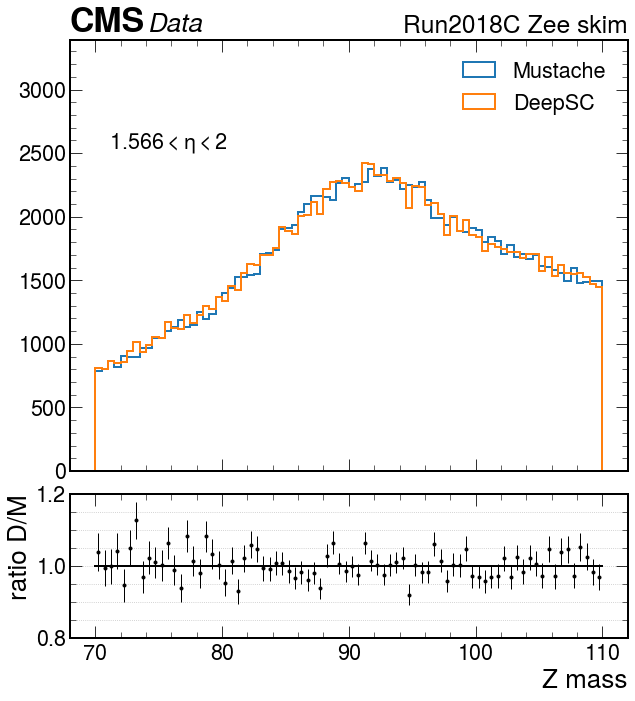

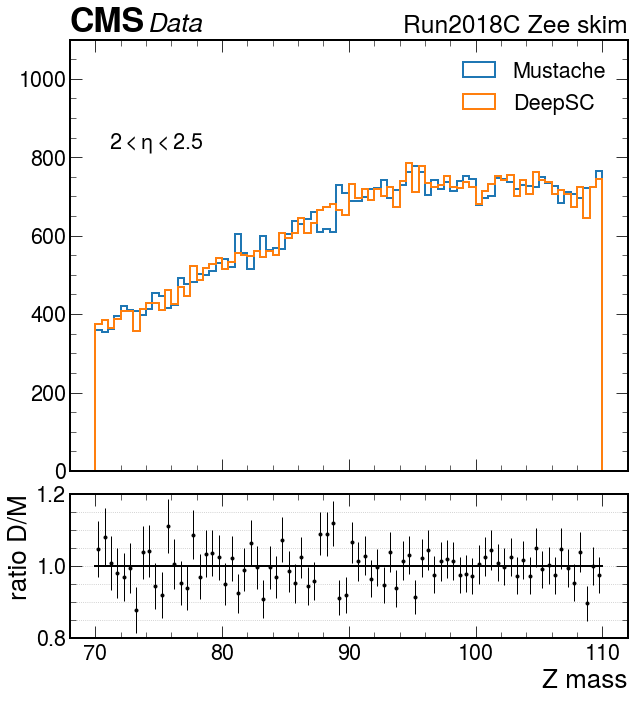

In [72]:
etas = [0, 0.5, 1, 1.4442, 1.566, 2, 2.5]

for i in range(len(etas)-1):
    df_cut = df[(abs(df.ele_eta_m)>etas[i])&(abs(df.ele_eta_m)<etas[i+1])]

    plot_comparison(df_cut.mass_m, df_cut.mass_d,
                    var=f"Z_mass_incl_match", 
                    output_folder=output_folder,
                    bins=80, xrange=(70,110), label="Z mass",
                    text=f"${etas[i]} < \eta<{etas[i+1]}$")


0.9885523319244385 0.9905588626861572
B: 134614.0
A. 133309.0
0.9791414737701416 0.9828940629959106
B: 118303.0
A. 117549.0
0.9381088376045227 0.943954074382782
B: 67722.0
A. 67954.0
0.9845929026603699 0.9872827291488647
B: 36525.0
A. 37629.0


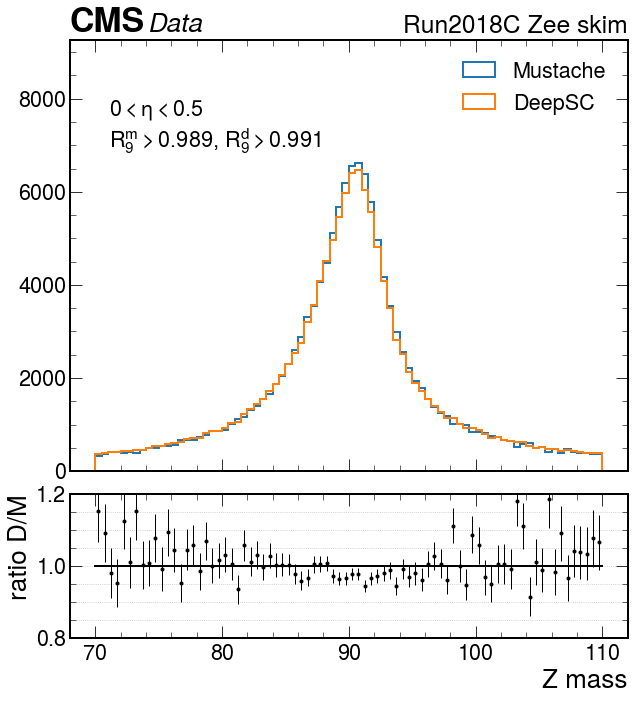

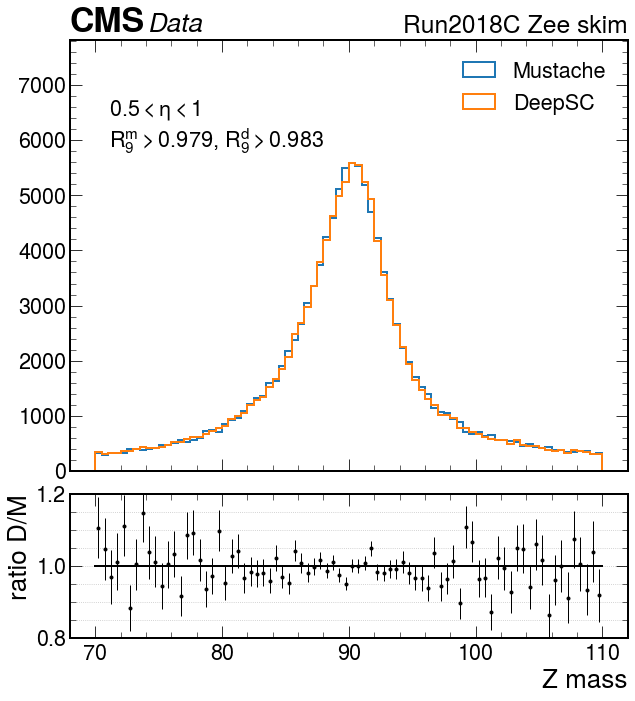

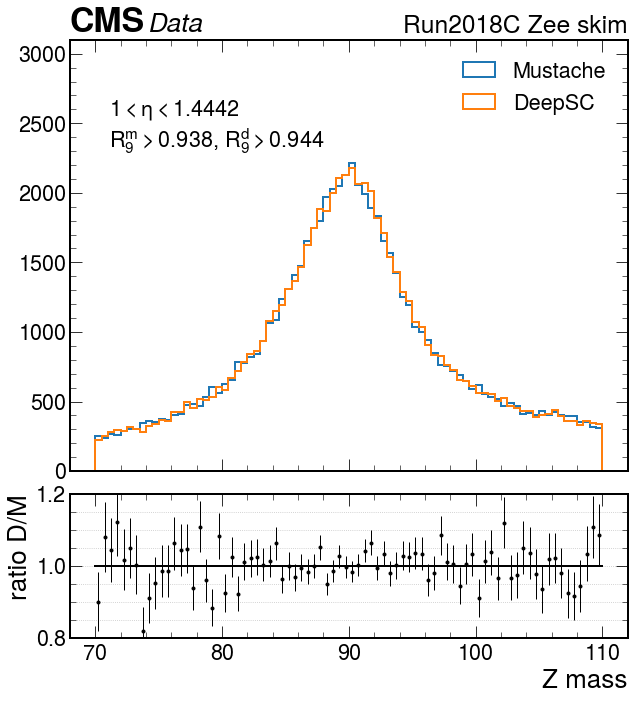

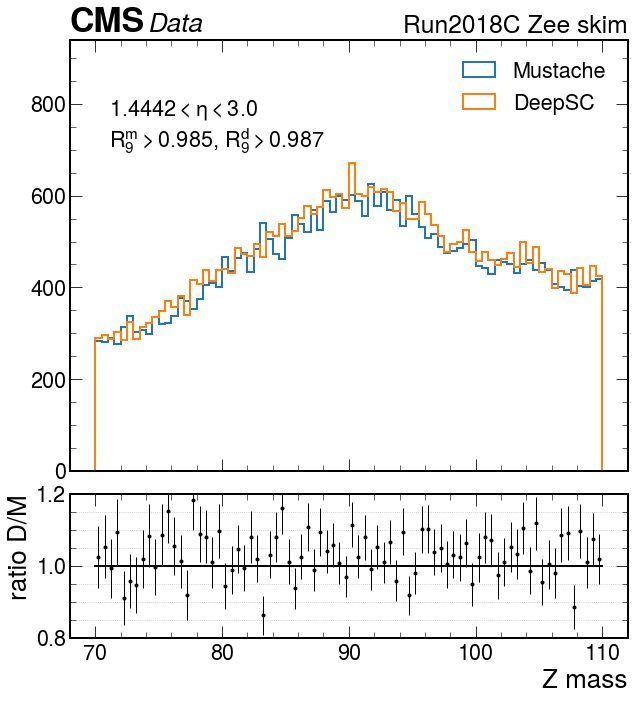

In [77]:
etas = [0, 0.5, 1, 1.4442,3.]

for i in range(len(etas)-1):
    

    df_cut = df[(abs(df.ele_eta_m)>etas[i])&(abs(df.ele_eta_m)<etas[i+1])]

    qm = df_cut.r9_m.quantile(0.8)
    qd = df_cut.r9_d.quantile(0.8)
    print(qm, qd)
    
    plot_comparison(df_cut[df_cut.r9_m>qm].mass_m, 
                    df_cut[df_cut.r9_d>qd].mass_d,
                    var=f"Z_mass_incl_match", 
                    output_folder=output_folder,
                    bins=80, xrange=(70,110), label="Z mass",
                    text=f"${etas[i]} < \eta<{etas[i+1]}$\n$R_9^m > {qm:.3f}$, $R_9^d > {qd:.3f}$")


#### Fixed R9 cut

<ipython-input-139-743c3fac9fb7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plot_comparison(df_cut[(df.nvtx_m>=25)&(df_cut.r9_m>0.95)].mass_m,
<ipython-input-139-743c3fac9fb7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_cut[(df.nvtx_m>=25)&(df_cut.r9_d>0.95)].mass_d,


B: 252200.0
A. 258634.0


<ipython-input-139-743c3fac9fb7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plot_comparison(df_cut[(df.nvtx_m>=25)&(df_cut.r9_m>0.95)].mass_m,
<ipython-input-139-743c3fac9fb7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_cut[(df.nvtx_m>=25)&(df_cut.r9_d>0.95)].mass_d,


B: 154907.0
A. 163859.0


<ipython-input-139-743c3fac9fb7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plot_comparison(df_cut[(df.nvtx_m>=25)&(df_cut.r9_m>0.95)].mass_m,
<ipython-input-139-743c3fac9fb7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_cut[(df.nvtx_m>=25)&(df_cut.r9_d>0.95)].mass_d,


B: 28081.0
A. 33037.0


<ipython-input-139-743c3fac9fb7>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plot_comparison(df_cut[(df.nvtx_m>=25)&(df_cut.r9_m>0.95)].mass_m,
<ipython-input-139-743c3fac9fb7>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_cut[(df.nvtx_m>=25)&(df_cut.r9_d>0.95)].mass_d,


B: 49948.0
A. 53304.0


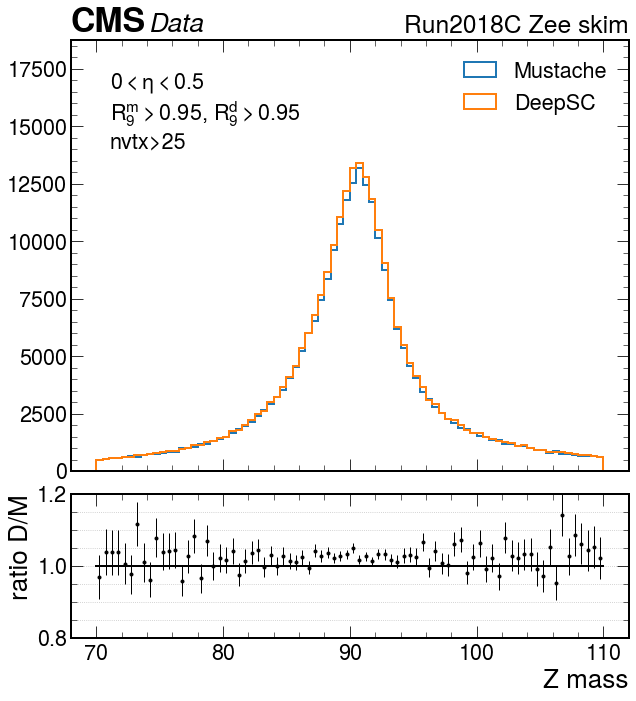

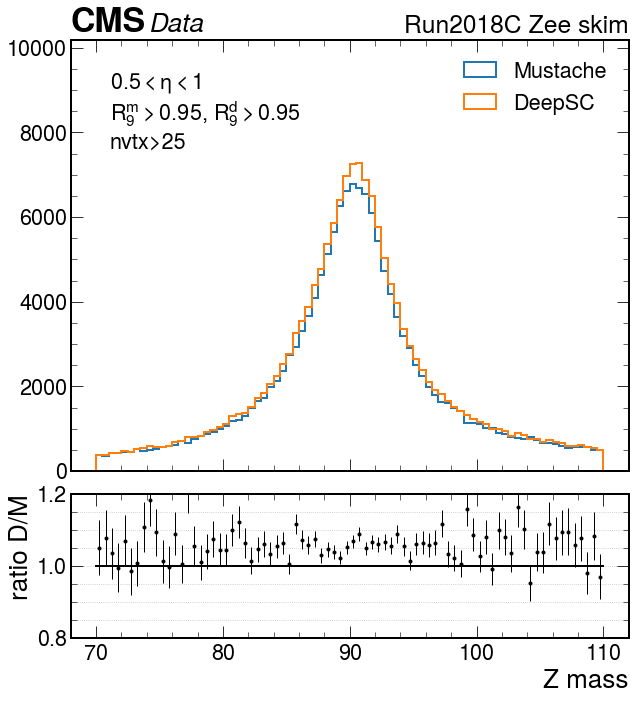

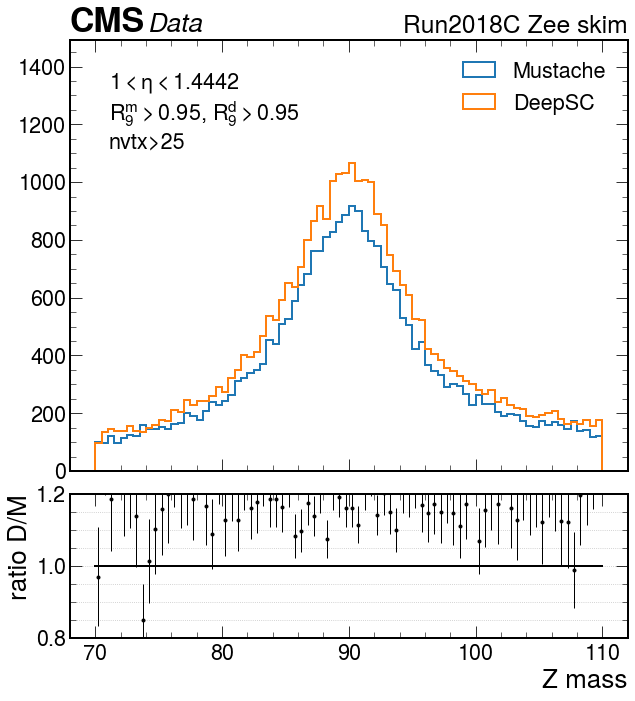

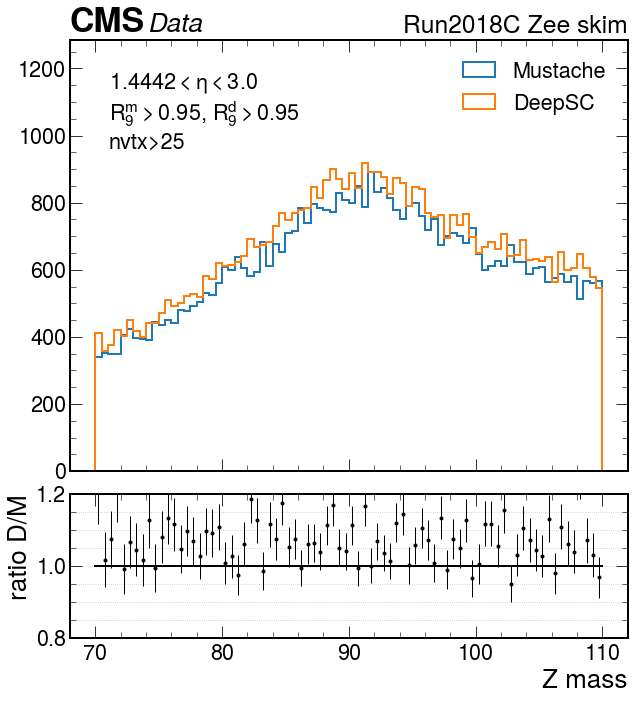

In [139]:
etas = [0, 0.5, 1, 1.4442,3.]

for i in range(len(etas)-1):

    df_cut = df[(abs(df.ele_eta_m)>etas[i])&(abs(df.ele_eta_m)<etas[i+1])]
 
    plot_comparison(df_cut[(df.nvtx_m>=25)&(df_cut.r9_m>0.95)].mass_m, 
                    df_cut[(df.nvtx_m>=25)&(df_cut.r9_d>0.95)].mass_d,
                    var=f"Z_mass_by_eta{etas[i]}_{etas[i+1]}_R90.95_nvtx25", 
                    output_folder=output_folder,
                    bins=80, xrange=(70,110), 
                    label="Z mass",
                    text=f"${etas[i]} < \eta<{etas[i+1]}$\n$R_9^m > 0.95$, $R_9^d > 0.95$\nnvtx>25")


B: 228253.0
A. 218479.0
B: 287801.0
A. 273728.0
B: 254022.0
A. 246276.0
B: 120646.0
A. 115289.0


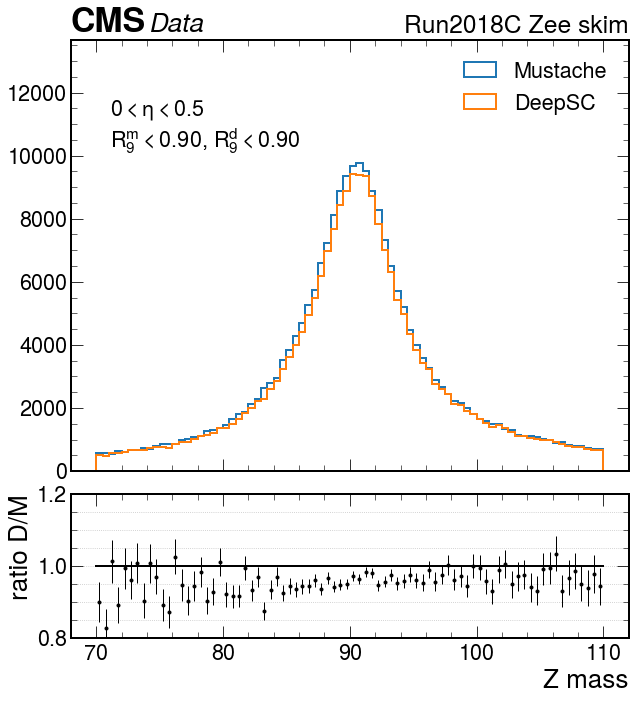

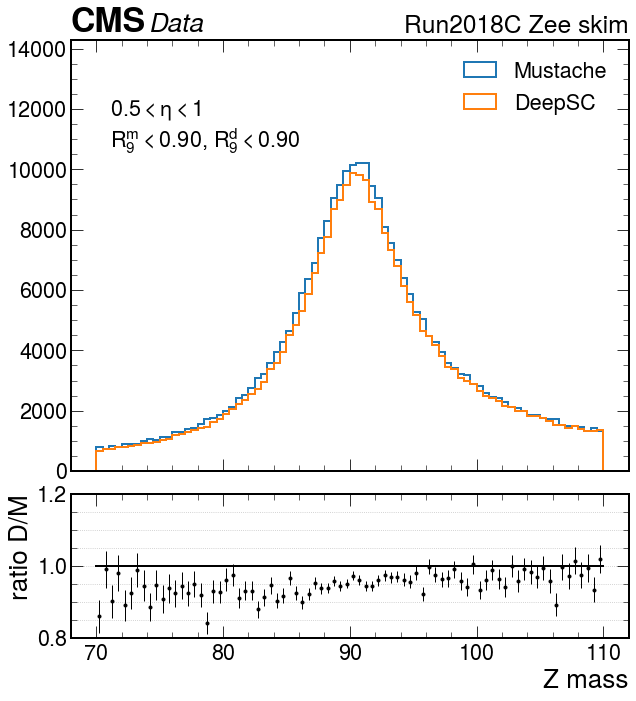

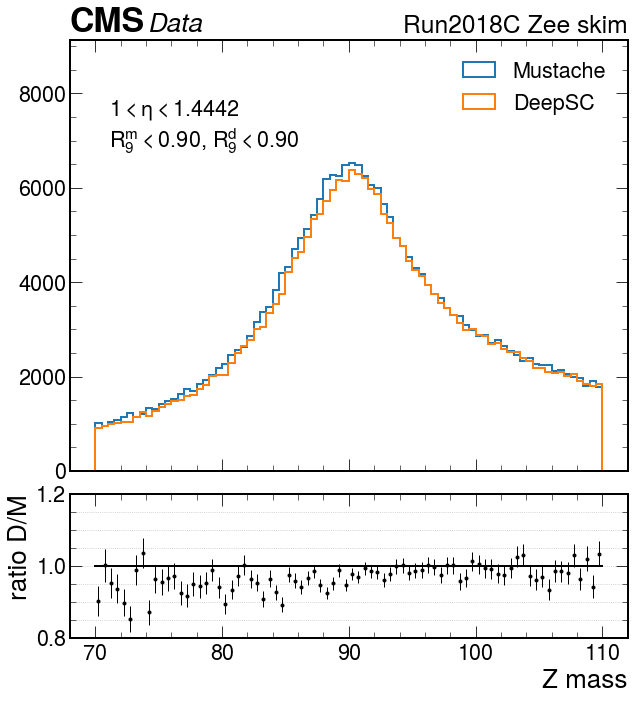

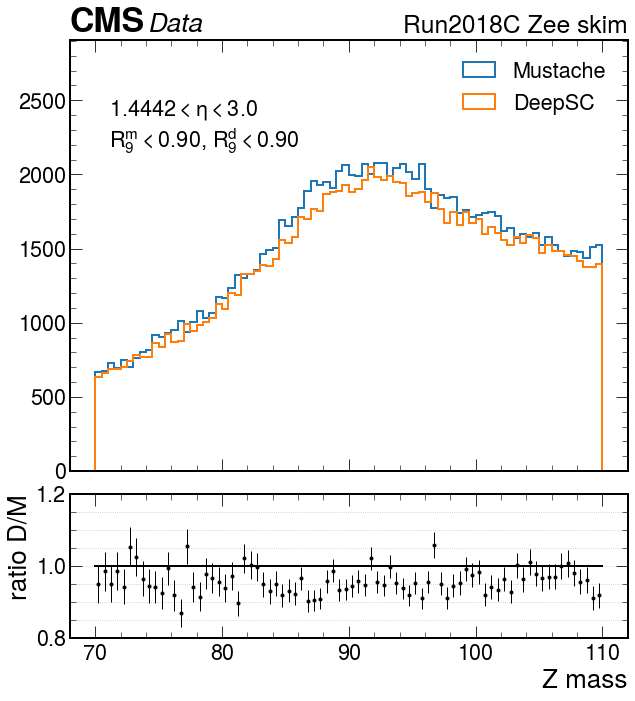

In [125]:
etas = [0, 0.5, 1, 1.4442,3.]

for i in range(len(etas)-1):

    df_cut = df[(abs(df.ele_eta_m)>etas[i])&(abs(df.ele_eta_m)<etas[i+1])]
 
    plot_comparison(df_cut[df_cut.r9_m<0.95].mass_m, 
                    df_cut[df_cut.r9_d<0.95].mass_d,
                    var=f"Z_mass_by_eta{etas[i]}_{etas[i+1]}_R90.95", 
                    output_folder=output_folder,
                    bins=80, xrange=(70,110), 
                    label="Z mass",
                    text=f"${etas[i]} < \eta<{etas[i+1]}$\n$R_9^m < 0.90$, $R_9^d < 0.90$")


B: 228253.0
A. 218479.0
B: 287801.0
A. 273728.0
B: 254022.0
A. 246276.0
B: 120646.0
A. 115289.0


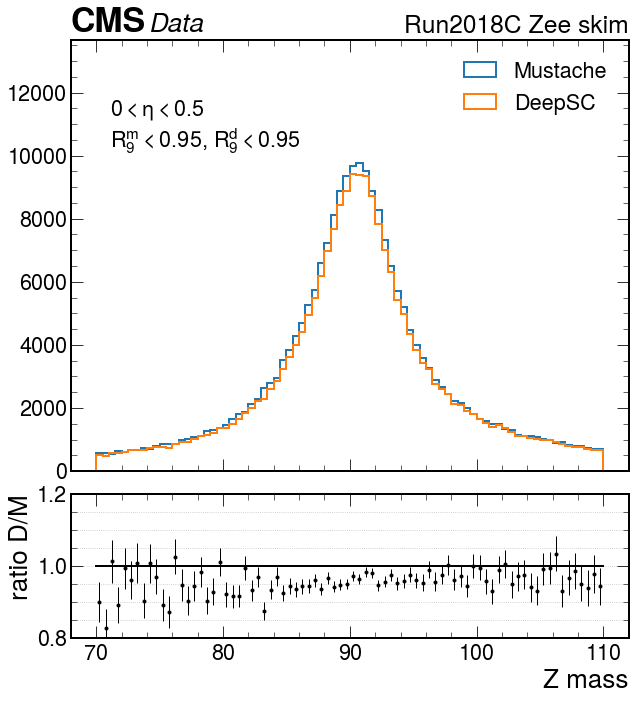

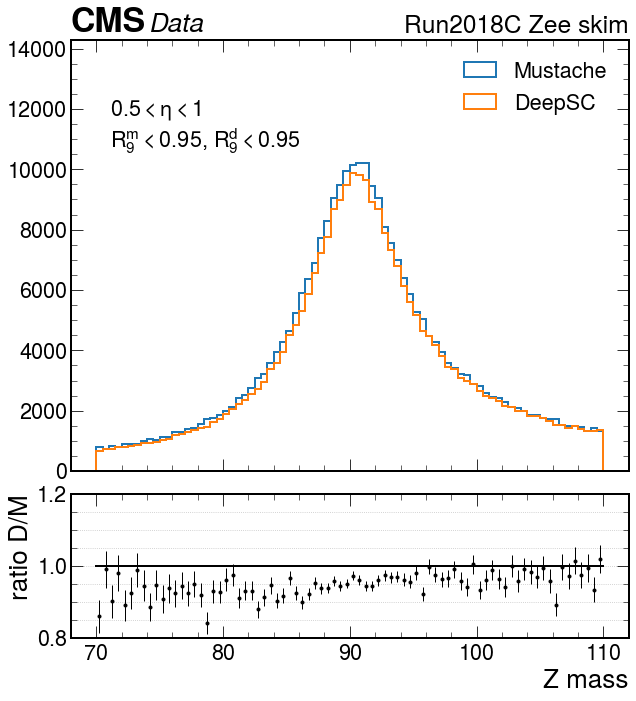

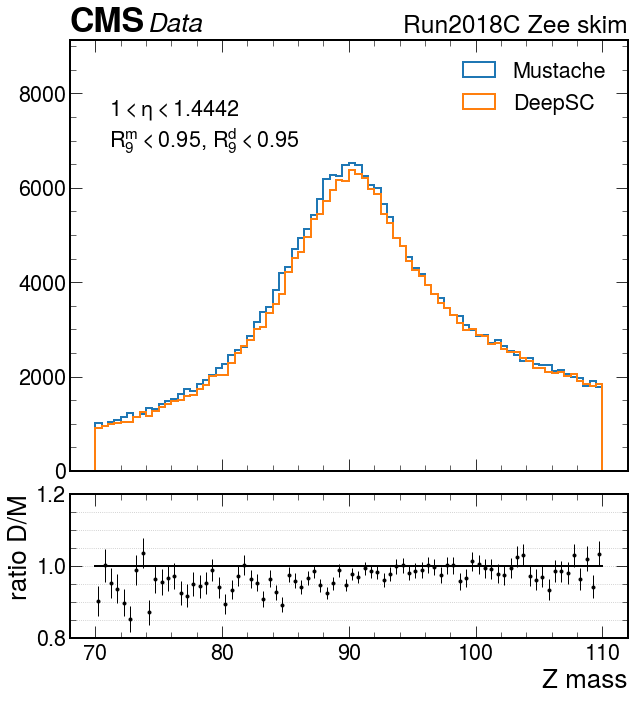

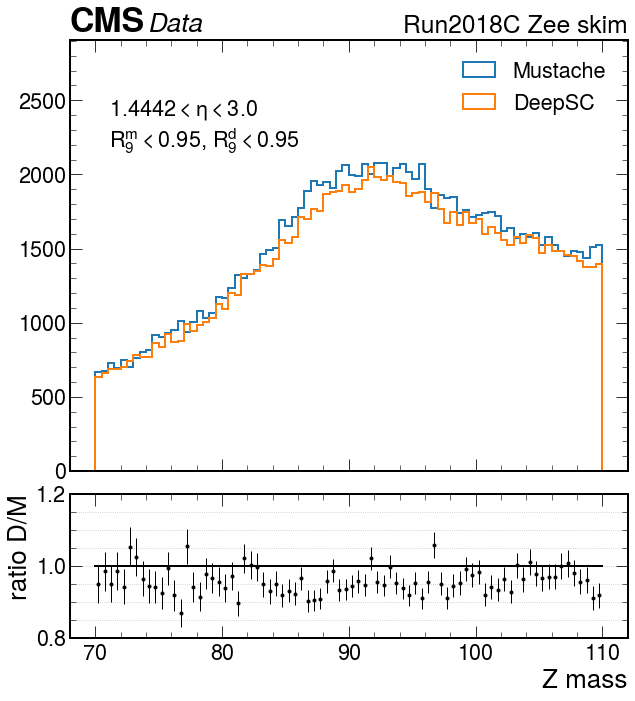

In [80]:
etas = [0, 0.5, 1, 1.4442,3.]

for i in range(len(etas)-1):

    df_cut = df[(abs(df.ele_eta_m)>etas[i])&(abs(df.ele_eta_m)<etas[i+1])]
 
    plot_comparison(df_cut[df_cut.r9_m<0.95].mass_m, 
                    df_cut[df_cut.r9_d<0.95].mass_d,
                    var=f"Z_mass_incl_match", 
                    output_folder=output_folder,
                    bins=80, xrange=(70,110), 
                    label="Z mass",
                    text=f"${etas[i]} < \eta<{etas[i+1]}$\n$R_9^m < 0.95$, $R_9^d < 0.95$")


## R9 ratio event-by-event

Text(1, 0, 'R9 mustache')

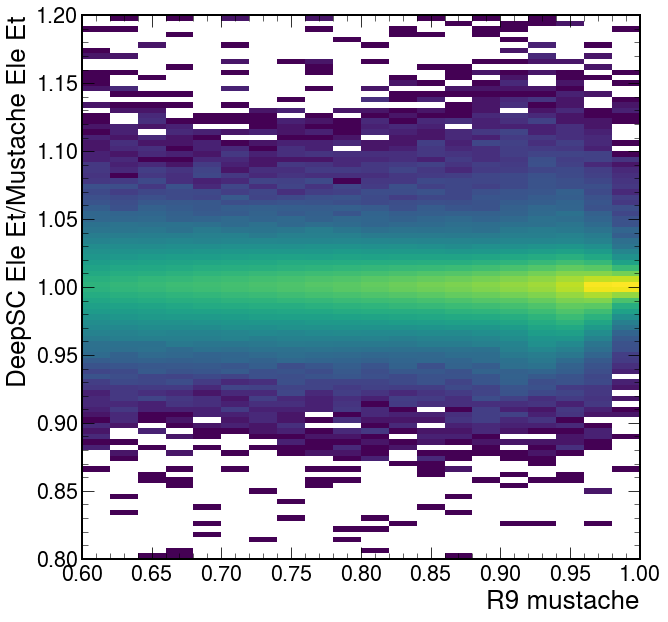

In [137]:
plt.hist2d( df.r9_m, df.ele_et_d/df.ele_et_m, bins=(20,100), range=((0.6, 1), (0.8,1.2)), norm=LogNorm())
#plt.yscale("log")
plt.ylabel("DeepSC Ele Et/Mustache Ele Et")
plt.xlabel("R9 mustache")

Text(1, 0, 'R9 mustache')

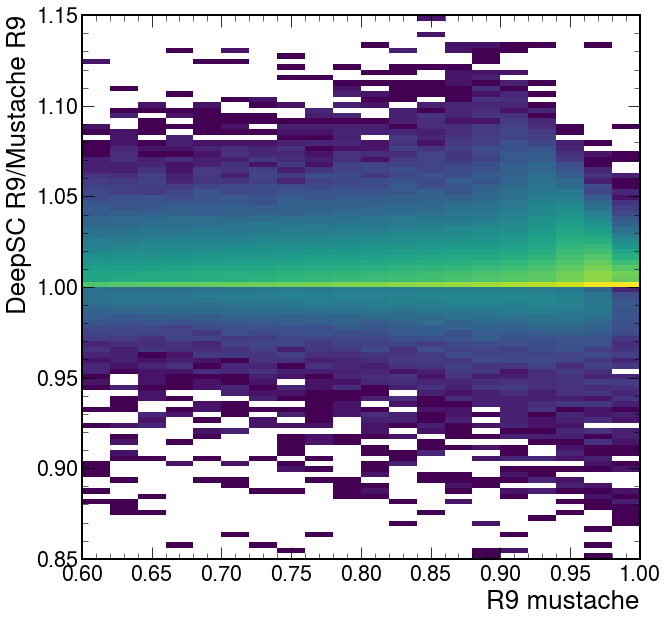

In [119]:
plt.hist2d( df.r9_m, df.r9_d/df.r9_m, bins=(20,100), range=((0.6, 1), (0.85,1.15)), norm=LogNorm())
#plt.yscale("log")
plt.ylabel("DeepSC R9/Mustache R9")
plt.xlabel("R9 mustache")

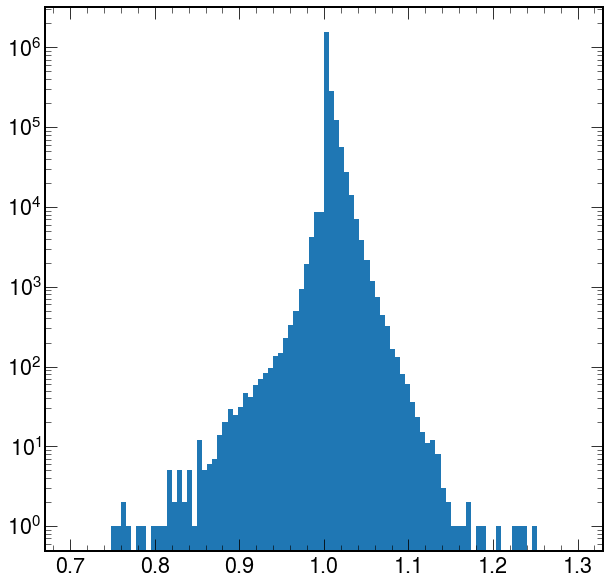

In [85]:
plt.hist(df.r9_d/df.r9_m, bins=100, range=(0.7,1.3))
plt.yscale("log")

In [126]:
qR9_d

array([0.94983685, 0.96692228, 0.97697455, 0.98499172, 0.99362614,
       1.90543914])

B: 34571.0
A. 34616.0


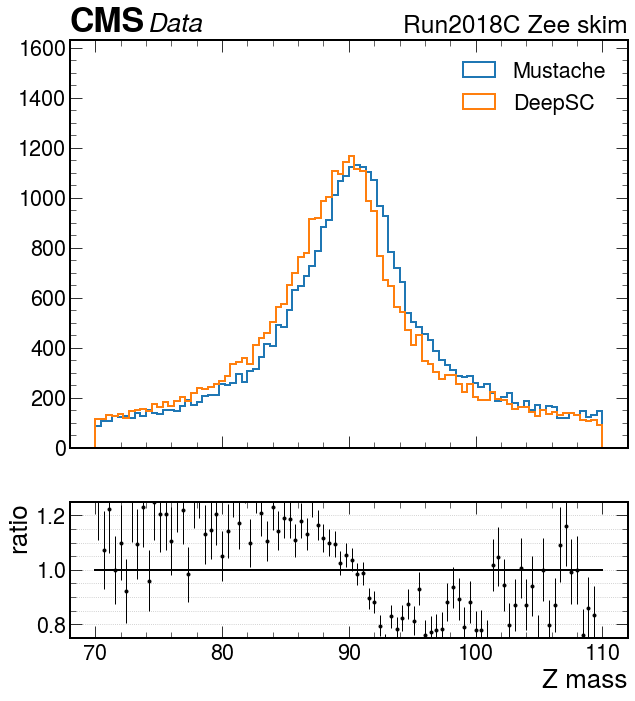

In [130]:
plot_comparison(df[(df.r9_m>0.9)&((df.r9_d/df.r9_m)>1.02)].mass_m,
                df[(df.r9_m>0.9)&((df.r9_d/df.r9_m)>1.02)].mass_d,
                    var=f"zmass_quantile_{qs[i]}-{qs[i+1]}", 
                    text="",
                 output_folder=output_folder,
                 bins=90, xrange=(70,110), label=f"Z mass",
                 ratio_lim=(0.75, 1.25))

B: 121695.0
A. 121766.0


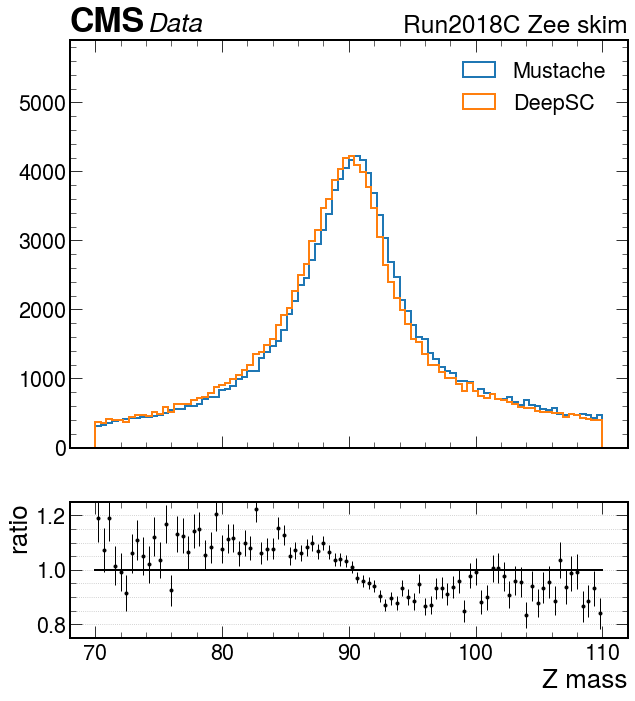

In [134]:
plot_comparison(df[(df.r9_m>0.9)&((df.r9_d/df.r9_m)>1.01)].mass_m,
                df[(df.r9_m>0.9)&((df.r9_d/df.r9_m)>1.01)].mass_d,
                    var=f"zmass_quantile_{qs[i]}-{qs[i+1]}", 
                    text="",
                 output_folder=output_folder,
                 bins=90, xrange=(70,110), label=f"Z mass",
                 ratio_lim=(0.75, 1.25))

B: 4322.0
A. 4284.0


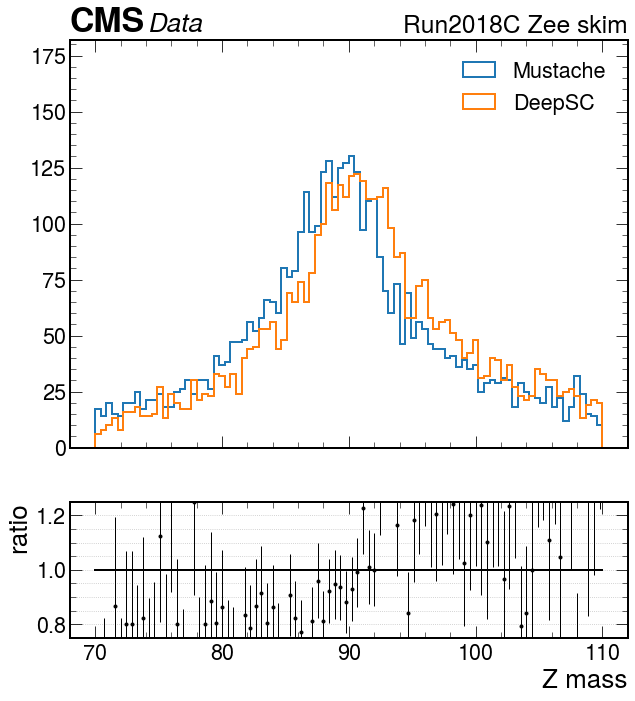

In [131]:
plot_comparison(df[(df.r9_m>0.9)&((df.r9_d/df.r9_m)<1)].mass_m,
                df[(df.r9_m>0.9)&((df.r9_d/df.r9_m)<1)].mass_d,
                    var=f"zmass_quantile_{qs[i]}-{qs[i+1]}", 
                    text="",
                 output_folder=output_folder,
                 bins=90, xrange=(70,110), label=f"Z mass",
                 ratio_lim=(0.75, 1.25))

Text(1, 0, 'DeepSC R9/Mustache R9 (leading)')

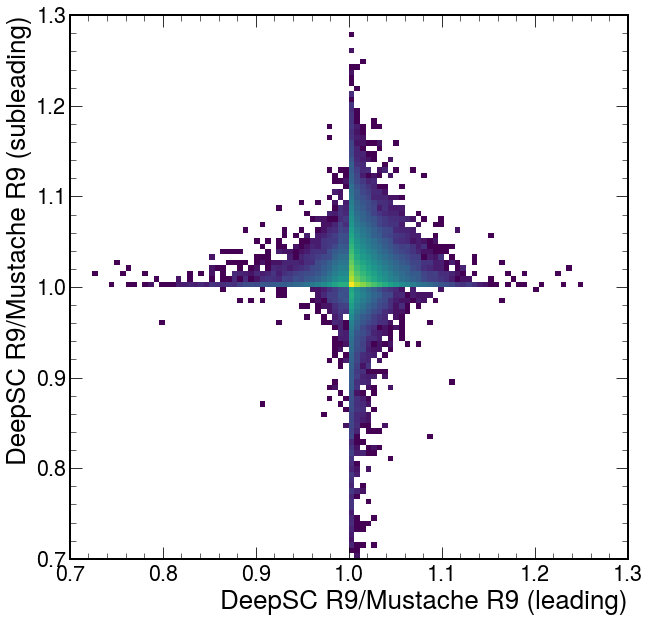

In [92]:
plt.hist2d(df.r9_d/df.r9_m, df.r9_sublead_d/df.r9_sublead_m, bins=(100,100), range=((0.7, 1.3), (0.7,1.3)), norm=LogNorm())
#plt.yscale("log")
plt.ylabel("DeepSC R9/Mustache R9 (subleading)")
plt.xlabel("DeepSC R9/Mustache R9 (leading)")

# Fitting

In [95]:
from plotting_code import *

In [96]:
def do_plot(*, name, df1, df2, res_var1, res_var2, 
            bins1, bins2, binlabel1, binlabel2, binvar1, binvar2, binleg,
            xlabel, ylabel, general_label, ylabelratio,
            yvar, ylims1, ylims2, 
            bin_analysis="cruijff",
            yvar_err=None,
            logy = True,
            exclude_x_bin=-1,
            exclude_y_bin=-1,
            nbins_fit=250, prange=1, 
            legendExt = "",
            xlabel_fit = "$E/E_{true}$",
            fill_between=None,  output_folder=None, 
            plot_fits=False,
            load_from_file=False):
            
        
    binCol1 = binlabel1+"_bin"
    binCol2 = binlabel2+"_bin"
    if not load_from_file:
       
        for df in [df1, df2]:
            df.loc[:,binCol1] = pd.cut(df[binvar1].abs(), bins1, labels=list(range(len(bins1)-1)))
            df.loc[:,binCol2] = pd.cut(df[binvar2].abs(), bins2, labels=list(range(len(bins2)-1)))

        if bin_analysis == "cruijff":
            res = df1.groupby([binCol1,binCol2]).apply(bin_analysis_cruijff(f"{res_var1}", nbins=nbins_fit, prange=prange))
            res_must = df2.groupby([binCol1,binCol2]).apply(bin_analysis_cruijff(f"{res_var2}", nbins=nbins_fit, prange=prange))
        elif bin_analysis == "ext_quantile":
            res = df1.groupby([binCol1,binCol2]).apply(bin_analysis_extquantiles(f"{res_var1}"))
            res_must = df2.groupby([binCol1,binCol2]).apply(bin_analysis_extquantiles(f"{res_var2}"))
        elif bin_analysis == "central_quantile":
            res = df1.groupby([binCol1,binCol2]).apply(bin_analysis_central_smallest(f"{res_var1}"))
            res_must = df2.groupby([binCol1,binCol2]).apply(bin_analysis_central_smallest(f"{res_var2}"))
        res.reset_index(level=0, inplace=True)
        res.reset_index(level=0, inplace=True)
        res_must.reset_index(level=0, inplace=True)
        res_must.reset_index(level=0, inplace=True)

        # computing sigma_Avg
        if bin_analysis == "cruijff":
            res.loc[:,"sigma_avg"] = (res.sigmaL + res.sigmaR)/2
            res.loc[:,"sigma_avg_err"] = 0.5 * np.sqrt( res.sigmaL_err**2 + res.sigmaR_err**2)
            res_must.loc[:,"sigma_avg"] = (res_must.sigmaL + res_must.sigmaR)/2
            res_must.loc[:,"sigma_avg_err"] = 0.5 * np.sqrt( res_must.sigmaL_err**2 + res_must.sigmaR_err**2)
    else:
        res = pd.read_csv(f"{output_folder}/resolution_{name}_deepsc.csv", sep=',')
        res_must = pd.read_csv(f"{output_folder}/resolution_{name}_mustache.csv", sep=',')
    
    
    fig = plt.figure(figsize=(8,9), dpi=200)
    gs = fig.add_gridspec(2, hspace=0.05, height_ratios=[0.75,0.25])
    axs = gs.subplots(sharex=True)

    errx = []
    x = []
    for i in range(len(bins1)-1):
        errx.append((bins1[i+1]- bins1[i])/2)
        x.append((bins1[i+1]+ bins1[i])/2)

    mustl = []
    deepl = []

    res.loc[res[binCol1] == exclude_x_bin, [yvar]] = 0
    res_must.loc[res_must[binCol1] == exclude_x_bin, [yvar]] = 0
    

    for iet, et in enumerate(bins2[:-1]):
        if iet == exclude_y_bin: continue
        if not yvar_err:
            l = axs[0].errorbar(x, res_must[res_must[binCol2] == iet][yvar], xerr=errx, 
                                label=f"[{bins2[iet]}, {bins2[iet+1]}]", fmt = ".")
        else:
            l = axs[0].errorbar(x, res_must[res_must[binCol2] == iet][yvar], 
                                xerr=errx, yerr=res_must[res_must[binCol2] == iet][yvar_err],
                                label=f"[{bins2[iet]}, {bins2[iet+1]}]", fmt = ".", elinewidth=1)
        mustl.append(l)

    i = 0
    for iet, et in enumerate(bins2[:-1]):
        if iet == exclude_y_bin: continue
        if not yvar_err:
            l = axs[0].errorbar(x, res[res[binCol2]== iet][yvar],  
                            xerr=errx,                    
                            label=f"[{bins2[iet]}, {bins2[iet+1]}]", 
                            c=mustl[i].lines[0].get_color(), marker="s", markerfacecolor='none', linestyle='none',elinewidth=0)
        else:
            l = axs[0].errorbar(x, res[res[binCol2]== iet][yvar],  
                            xerr=0,  yerr=res[res[binCol2]== iet][yvar_err],                  
                            label=f"[{bins2[iet]}, {bins2[iet+1]}]", 
                            c=mustl[i].lines[0].get_color(), marker="s", markerfacecolor='none', linestyle='none',elinewidth=1) #not drawing the error
        i+=1
        deepl.append(l)

    if fill_between:
        axs[0].fill_between(fill_between, [ylims1[0]]*2,[ylims1[1]]*2, color="lightgray", alpha=0.5)
        axs[1].fill_between(fill_between, [ylims2[0]]*2,[ylims2[1]]*2, color="lightgray", alpha=0.5)


    for iet, et in enumerate(bins2[:-1]):
        if iet == exclude_y_bin: continue
        rd = res[res[binCol2]==iet][yvar]
        rm = res_must[res_must[binCol2]==iet][yvar]
        var = rd/rm
        if not yvar_err:
            axs[1].errorbar(x, var,xerr=errx, fmt=".", linestyle='none', elinewidth=0)
        else:
            # Error of the ratio
            deep_err = res[res[binCol2]==iet][yvar_err]
            must_err = res_must[res_must[binCol2]==iet][yvar_err]
            err_ratio = np.sqrt( ((1/rm)**2) * deep_err**2 + ((rd/(rm**2))**2 )*must_err**2 )
            axs[1].errorbar(x, var,xerr=errx, yerr=err_ratio,
                            fmt=".", linestyle='none', elinewidth=1)

    axs[0].set_ylabel(ylabel)
    axs[1].set_xlabel(xlabel)
    axs[0].set_ylim(*ylims1)
    axs[1].set_ylim(*ylims2)
    

    axs[1].set_ylabel(ylabelratio, fontsize=22)
    axs[0].get_yaxis().set_label_coords(-0.1,1)
    axs[1].get_yaxis().set_label_coords(-0.1,1)

    l1= axs[0].legend(handles=mustl, title=binleg, title_fontsize=18, loc="upper left", fontsize=18)

    ml = mlines.Line2D([], [], color='black', marker='.', linestyle='None', markersize=10, label='Mustache'+ legendExt )
    dl = mlines.Line2D([], [], color='black', marker='s', markerfacecolor='none', linestyle='None', markersize=10, label='DeepSC'+ legendExt)
    axs[0].legend(handles=[ml,dl], title="Algorithm", title_fontsize=18, loc="upper right", 
                  bbox_to_anchor=(0.93, 1), fontsize=18)
    axs[0].add_artist(l1)

    axs[0].text(0.7, 0.62, general_label, transform=axs[0].transAxes, fontsize=20)

    if logy:
        axs[0].set_yscale("log")
    axs[0].grid(which="both",axis="y")
    axs[1].grid(which="both",axis="y")

    hep.cms.label(rlabel="14 TeV", llabel="Simulation Preliminary", loc=0, ax=axs[0]) 
    
    if (output_folder):
        os.makedirs(output_folder, exist_ok=True)
        os.system(f"cp /eos/user/d/dvalsecc/www/index.php {output_folder}")
        fig.savefig(output_folder + f"/resolution_{name}_{yvar}_ratio.png")
        fig.savefig(output_folder + f"/resolution_{name}_{yvar}_ratio.pdf")
        fig.savefig(output_folder + f"/resolution_{name}_{yvar}_ratio.svg")
        
    #######
    #Plot the single fit bins
    if bin_analysis=="cruijff" and plot_fits and output_folder:
        output_fits = output_folder + "/fits_"+ name
        os.makedirs(output_fits, exist_ok=True)
        os.system(f"cp /eos/user/d/dvalsecc/www/index.php {output_fits}")
        
        for iBin1, bin1, in enumerate(bins1[:-1]):
            for iBin2, bin2 in enumerate(bins2[:-1]):
                df_d = df1[(df1[binCol1] == iBin1)&(df1[binCol2]==iBin2)]
                df_m = df2[(df2[binCol1] == iBin1)&(df2[binCol2]==iBin2)]
                fit_deep = res[(res[binCol1]== iBin1)&(res[binCol2]==iBin2)]
                fit_must = res_must[(res_must[binCol1]== iBin1)&(res_must[binCol2]==iBin2)]
                if fit_deep.sigma_avg.values[0] == -1 or fit_must.sigma_avg.values[0]==-1:
                    print(f"Fit failed iBin1:{iBin1}, iBin2:{iBin2}")
                    continue
                    
                fig = plt.figure(figsize=(9,8), dpi=100)
                ax = plt.gca()
                #using same range and nbins for both plots
                H_m = np.histogram(df_m[res_var2],bins=nbins_fit, range=(fit_must.xmin.values[0], fit_must.xmax.values[0]))
                xm = H_m[1][:-1]
                Ym = H_m[0]
                ax.errorbar(xm, Ym, np.sqrt(Ym),0, linestyle='none',fmt=".", label="Mustache"+legendExt,zorder=0)


                H_d = np.histogram(df_d[res_var1],bins=nbins_fit, range=(fit_deep.xmin.values[0], fit_deep.xmax.values[0]))
                xd = H_d[1][:-1]
                Yd = H_d[0]
                ax.errorbar(xd, Yd, np.sqrt(Yd),0, linestyle='none', fmt=".",label="DeepSC"+legendExt, zorder=1)


                y_cr_D = cruijff(xd, fit_deep.A.values[0], fit_deep.m.values[0], fit_deep.sigmaL.values[0], 
                                 fit_deep.sigmaR.values[0], fit_deep.alphaL.values[0], fit_deep.alphaR.values[0])
                
                y_cr_M = cruijff(xm, fit_must.A.values[0], fit_must.m.values[0], fit_must.sigmaL.values[0],
                                 fit_must.sigmaR.values[0], fit_must.alphaL.values[0], fit_must.alphaR.values[0])
                
                ax.plot(xm, y_cr_M, label="Cruijiff Mustache", linewidth=3, zorder=10, color="green")
                ax.plot(xd, y_cr_D, label="Cruijiff DeepSC", linewidth =3, zorder=11, color="red")

                ax.legend(loc="upper right", bbox_to_anchor=(1, 1), fontsize=17)
                ax.text(0.05, 0.9, f"Mustache:\nm={fit_must.m.values[0]:.3f}, $\sigma_L$={fit_must.sigmaL.values[0]:.3f}, $\sigma_R$={fit_must.sigmaR.values[0]:.3f}",
                        transform=ax.transAxes, fontsize=15, color="green")
                ax.text(0.05, 0.8, f"DeepSC:\nm={fit_deep.m.values[0]:.3f}, $\sigma_L$={fit_deep.sigmaL.values[0]:.3f}, $\sigma_R$={fit_deep.sigmaR.values[0]:.3f}",
                        transform=ax.transAxes, fontsize=15, color="red")

                ax.text(0.05, 0.65, f"{xlabel} [{bins1[iBin1]},{bins1[iBin1+1]}] \n{binleg}: [{bins2[iBin2]},{bins2[iBin2+1]}]",
                        transform=ax.transAxes, fontsize=17)
                
                ax.text(0.65, 0.65, general_label, transform=ax.transAxes, fontsize=20)

                ax.set_ylim(0,max(Yd)*1.5)
                ax.set_xlabel(xlabel_fit)
                hep.cms.label(rlabel="14 TeV",  llabel="Simulation Preliminary", loc=0, ax=ax)

                if (output_folder):
                    fig.savefig(output_fits + f"/cruijff_fit_{binlabel1}{bins1[iBin1]}_{bins1[iBin1+1]}_{binlabel2}{bins2[iBin2]}_{bins2[iBin2+1]}.png")
                    fig.savefig(output_fits + f"/cruijff_fit_{binlabel1}{bins1[iBin1]}_{bins1[iBin1+1]}_{binlabel2}{bins2[iBin2]}_{bins2[iBin2+1]}.pdf")
                    fig.savefig(output_fits + f"/cruijff_fit_{binlabel1}{bins1[iBin1]}_{bins1[iBin1+1]}_{binlabel2}{bins2[iBin2]}_{bins2[iBin2+1]}.svg")
                plt.close()
                
    if output_folder:
        res.to_csv(f"{output_folder}/resolution_{name}_deepsc.csv", sep=',', index=False)
        res_must.to_csv(f"{output_folder}/resolution_{name}_mustache.csv", sep=',', index=False)
    
    return res, res_must

Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed iBin1:0, iBin2:0
Fit failed iBin1:0, iBin2:1
Fit failed iBin1:0, iBin2:2
Fit failed iBin1:0, iBin2:3
Fit failed iBin1:1, iBin2:0
Fit failed iBin1:1, iBin2:1
Fit failed iBin1:1, iBin2:2
Fit failed iBin1:1, iBin2:3
Fit failed iBin1:2, iBin2:0
Fit failed iBin1:2, iBin2:1
Fit failed iBin1:2, iBin2:2
Fit failed iBin1:2, iBin2:3


/tmp/ipykernel_12955/3011205683.py:201: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0,max(Yd)*1.5)
/tmp/ipykernel_12955/3011205683.py:201: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0,max(Yd)*1.5)
/tmp/ipykernel_12955/3011205683.py:201: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0,max(Yd)*1.5)
/tmp/ipykernel_12955/3011205683.py:201: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0,max(Yd)*1.5)


Fit failed iBin1:4, iBin2:0
Fit failed iBin1:4, iBin2:1
Fit failed iBin1:4, iBin2:2
Fit failed iBin1:4, iBin2:3
Fit failed iBin1:5, iBin2:0
Fit failed iBin1:5, iBin2:1
Fit failed iBin1:5, iBin2:2
Fit failed iBin1:5, iBin2:3


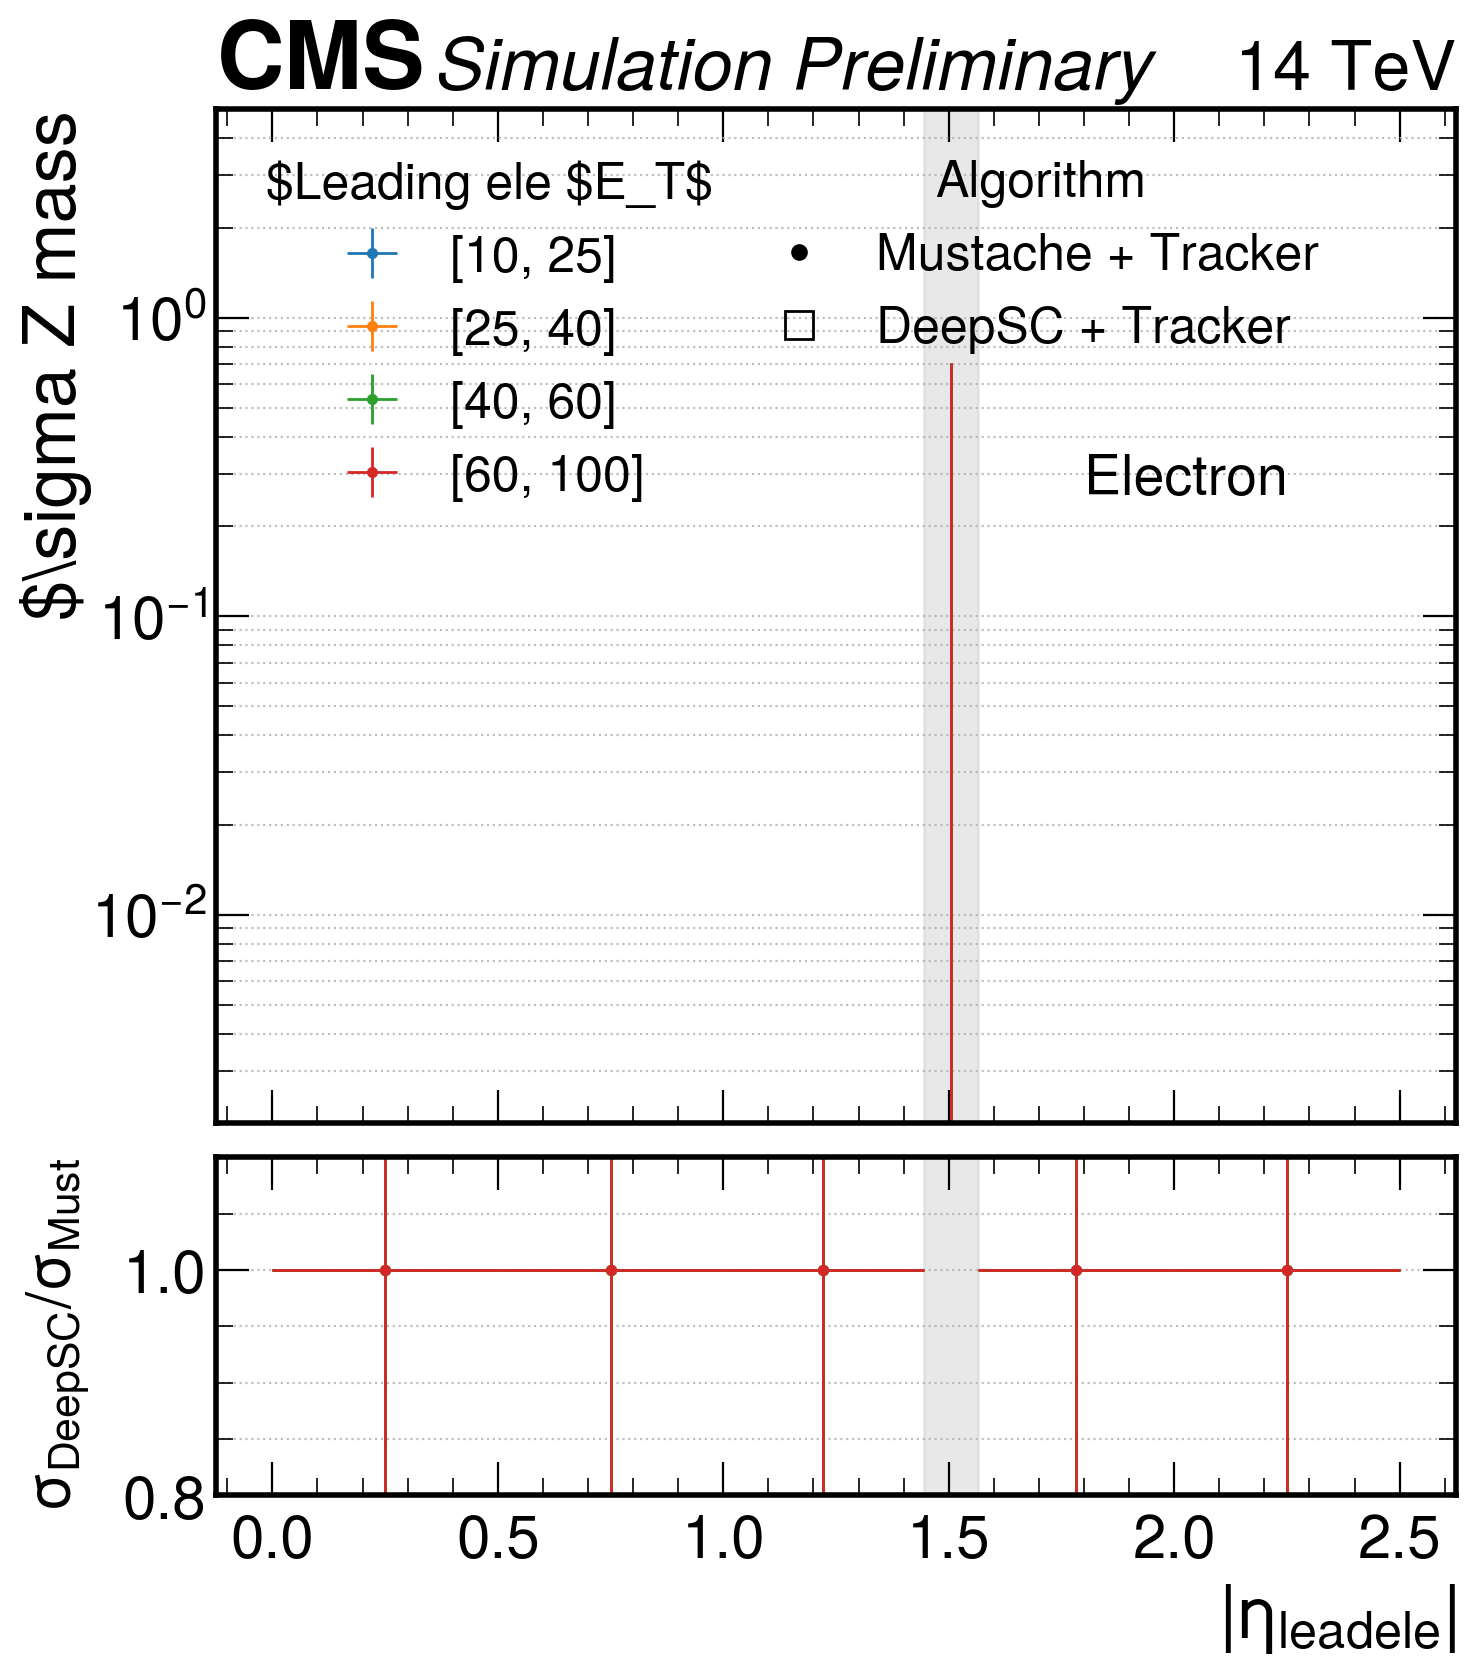

In [99]:
res_d, res_m = do_plot(name="test",
        df1=Zm, 
        df2=Zd,
        res_var1="mass", 
        res_var2="mass",
        bins1=[0, 0.5,1.0,1.4442, 1.566, 2.,2.5],
        bins2=[10,25, 40, 60,100], 
        binlabel1="ele_eta",
        binlabel2="ele_et",
        binleg="$Leading ele $E_T$", 
        binvar1="ele_eta", 
        binvar2="ele_et", 
        nbins_fit=350, 
        prange=0.965, 
        exclude_x_bin=3, 
        general_label="Electron", 
        legendExt = " + Tracker",
        xlabel_fit = "$E_{calib}/E_{Gen}$",
        xlabel="$|\eta_{lead ele}|$", 
        ylabel="$\sigma Z mass",
        ylabelratio="$\sigma_{DeepSC}/\sigma_{Must}$", 
        yvar="sigma_avg",
        bin_analysis="cruijff",
        yvar_err="sigma_avg_err",
        ylims1=(2e-3,5),
        ylims2=(0.8, 1.1),
        fill_between=[1.4442, 1.566],
        output_folder=output_folder, 
        plot_fits=True, 
        load_from_file=False)
